In [8]:
library(ComplexHeatmap)
library(ggplot2)
library(Seurat)
library(Matrix)
library(ggpubr)
library(RColorBrewer)
library(circlize)
library(data.table)
library(dplyr)
library(tidyr)
library(SeuratWrappers)
library(ROCR)
library(GSVA)

library(infercnv)
#library(poolr)
library(stringr)
library(flexmix)
library(GenomicRanges)
library(mixtools)
library(readxl)

library(GenomicDataCommons)
library(TCGAbiolinks, lib.loc = '../R/4.0/library/')
library(parallelDist)

library(survminer)
library(survival)
library(umap)

library(GEOquery)
library(stringr)
library(DESeq2)
library(fgsea)
library(HiClimR)
library(GEOquery)
library(lmerTest)
library(rtracklayer)
library(DoubletFinder)
    library(BiocParallel)

library(edgeR)

library(biomaRt)

source("gene_set_scoring.R")
source("compute_gene_set_scores.R")
source("deg_gsea_analysis.R")

mart_mouse = useMart("ensembl", dataset="mmusculus_gene_ensembl",verbose=F,host="https://useast.ensembl.org") 
mart_human = useMart("ensembl", dataset="hsapiens_gene_ensembl",verbose=F,host="https://useast.ensembl.org")

get_orthologs <- function(gene_names,from_species,to_species) {
    if (from_species == "mouse") {
        from_mart <- mart_mouse
        to_mart <- mart_human
    } else {
        from_mart <- mart_human
        to_mart <- mart_mouse
    }
    
    ortholog_dt <- getLDS(attributes=c("external_gene_name"),
            filters="external_gene_name", values=gene_names, mart=from_mart,
            attributesL=c("external_gene_name"), martL=to_mart, verbose=F) %>% data.table(.) %>%
     setnames(.,"Gene.name.1",paste(to_species,"gene_name",sep="_")) %>% 
    setnames(.,"Gene.name",paste(from_species,"gene_name",sep="_"))
    
    return(ortholog_dt)
}


Attaching package: ‘survival’


The following object is masked from ‘package:survminer’:

    myeloma


Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Setting options('download.file.method.GEOquery'='auto')

Setting options('GEOquery.inmemory.gpl'=FALSE)

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following objects are masked from ‘package:Biobase’:

    anyMissing, rowMedians


The following object is masked from ‘package:GenomicDataCommons’:

    count


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCol

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


# inferCNV Analysis

In [ ]:
count_df <- 
obj@meta.data %>% 
group_by(cluster, sample_type, site, patient_code) %>%
dplyr::count() %>%
dplyr::filter(site %in% c("Lung","Liver")) %>%
mutate(site=factor(site,levels=c("Lung","Liver")),
      sample_type=factor(sample_type,levels=c("Healthy","Adj_Tissue","ACC_Met")))

clusters <- unique(count_df$cluster)
coef_df <- data.frame()
for (cluster_ in clusters) {
    cluster_counts_df <- dplyr::filter(count_df,cluster == cluster_)
    
    unique_sites <- unique(cluster_counts_df$site)
    if (length(unique_sites) == 1)
        next
    
    out <- lme4::glmer(n ~ (1|patient_code) + site*sample_type, 
                      data=cluster_counts_df,family="poisson")  
        
    temp_df <- as.data.frame( coef(summary(out)) ) %>%
    tibble::rownames_to_column("coef") %>%
    dplyr::select(-c(`Std. Error`,`Estimate`)) %>%
    dplyr::filter(coef != "(Intercept)") %>%
    mutate(coef=gsub("site|sample_type","",coef)) %>%
    mutate(cell_type=cluster_)
    
    coef_df <- rbind(coef_df,temp_df)
}

p_value_df <- dplyr::select(coef_df,-`z value`)  %>%
mutate(coef=case_when(coef == "Liver" ~ "Liver vs Lung",
                     coef == "Adj_Tissue" ~ "Adj_Tissue vs Healthy",
                     coef == "ACC_Met" ~ "ACC_Met vs Healthy",
                     TRUE ~ coef))
z_value_df <- dplyr::select(coef_df,-`Pr(>|z|)`) %>%
mutate(coef=case_when(coef == "Liver" ~ "Liver vs Lung",
                     coef == "Adj_Tissue" ~ "Adj_Tissue vs Healthy",
                     coef == "ACC_Met" ~ "ACC_Met vs Healthy",
                     TRUE ~ coef))

z_value_mat <- tidyr::pivot_wider(z_value_df,names_from="coef",values_from="z value",
                  values_fill=0) %>% tibble::column_to_rownames("cell_type") %>%
as.matrix

p_value_mat <- tidyr::pivot_wider(p_value_df,names_from="coef",values_from="Pr(>|z|)",
                  values_fill=0) %>% tibble::column_to_rownames("cell_type") %>%
as.matrix
z_value_mat[p_value_mat > 0.05] <- 0

colors <- circlize::colorRamp2(c(quantile(z_value_mat,0.025),0,quantile(z_value_mat,0.975)),c("blue","white","red"))
# display_cols <- colnames(z_value_mat)
# display_cols <- gsub("^Liver$",)
options(repr.plot.width=5,repr.plot.height=6)
Heatmap( z_value_mat, na_col = "gray",# col=colors, 
        name="Z value", cluster_columns=F, cluster_rows=T, 
       rect_gp=gpar(lwd=1,col="black"))
options(repr.plot.width=7,repr.plot.height=7)

## Pre-HMM output

Below, we load the results of running inferCNV. 

The threshold for a copy number amplification or deletion is set as the 97.5th percentile and 2.5th percentile of gene-wise inferCNV scores,respectively, across all background i.e., healthy cells that are guaranteed to not have a copy number change. This reference consists
of all cells from our healthy donor cohort along with immune, endothelial and fibroblast cells from our ACC patient cohort.

The total CNV score of each cell in the ACC cohort (i.e., that are not immune, endothelial or fibroblast) is computed as the sum of the number of genes with a CNV score above the 97.5th percentile of the CNV scores of background cells plus the number of genes with a CNV score below the 2.5th percentile of the CNV scores of background cells. 

In [3]:
temp <- readRDS("../processed_data/Obj6_infercnv_out/run.final.infercnv_obj")
infercnv_obj <- readRDS("../processed_data/Obj6_infercnv_out/21_denoise.NF_NA.SD_1.5.NL_FALSE.infercnv_obj")
infercnv_mat <- infercnv_obj@expr.data
colnames(infercnv_mat) <- gsub("_[0-9][0-9]*$","",colnames(infercnv_mat))
combined_meta_data_df <- fread("Obj6_All_Cells_Basic_Metadata.csv")

ref_cells <- unlist(infercnv_obj@reference_grouped_cell_indices) #%>% gsub("_[0-9][0-9]*$","",.)
ref_cell_names <- colnames(infercnv_mat)[ref_cells]
foreground_cells <- unlist(infercnv_obj@tumor_subclusters$subclusters) %>% gsub("_[0-9][0-9]*$","",.)
foreground_cells <- setdiff(colnames(infercnv_mat),ref_cell_names)
 
lower_thresh <- quantile(infercnv_mat[,ref_cell_names],0.025) ##Threshold for determining whether a given gene is deleted
upper_thresh <- quantile(infercnv_mat[,ref_cell_names],0.975) ##Threshold for determining whether a given gene is amplified
num_dels_df <- colSums(infercnv_mat < lower_thresh) %>% tibble::enframe(name="cell.name",value="num_dels")
num_amps_df <- colSums(infercnv_mat > upper_thresh) %>% tibble::enframe(name="cell.name",value="num_amps")
merged_cnvs_df <- merge( num_dels_df, num_amps_df, by="cell.name") %>%
mutate(num_cnvs=num_amps+num_dels) %>% 
merge(.,
                                             dplyr::select(combined_meta_data_df,cell.name,infercnv_cluster,orig.ident,
                                                           sample_type,cluster,nCount_RNA,nFeature_RNA),by="cell.name") %>%
mutate(sample_type=ifelse(grepl("Adj",sample_type),"Adj_Norm",sample_type)) %>% unique

cells <- setdiff(merged_cnvs_df$cell.name,"TCACAAGAGACGACGT-1_2")
merged_cnvs_df <- dplyr::filter(merged_cnvs_df,cell.name %in% cells)
cnv_thresh <- dplyr::filter(merged_cnvs_df,sample_type == "Healthy") %>% pull(num_cnvs) %>%
quantile(0.95) 
merged_cnvs_df$is_malignant <- ifelse(merged_cnvs_df$num_cnvs > cnv_thresh,1,0) ##Presumptively malignnat cells

After running the code above, each cell is associated with a value of the variable `is_malignant`. `is_malignant` = 1 for presumptively malignant cells and `is_malignant` = 0 otherwise. All cells, both presumptively malignant and non-malignant, are clustered in the code below with `n = 30` PCs, a Louvain clustering resolution of `1.5` and without any batch correction.

In [ ]:
if (!"is_malignant" %in% colnames(epithelial_obj@meta.data)) {
    meta_data_df <- tibble::rownames_to_column(epithelial_obj@meta.data,"cell.name") %>%
    merge(.,merged_cnvs_df %>% dplyr::select(is_malignant,num_amps,num_dels,num_cnvs,cell.name),
         by="cell.name") %>%
    mutate(sample_type=ifelse(sample_type == "Normal","Healthy",sample_type)) %>%
    mutate(is_known_infercnv_false_positive=ifelse(is_malignant == 1 & sample_type == "Healthy",1,0)) %>%
    tibble::column_to_rownames("cell.name")

    epithelial_obj <- AddMetaData(epithelial_obj,meta_data_df)
    cells <- rownames(dplyr::filter(meta_data_df,sample_type %in% c("ACC_Met","Adj_Norm","Healthy")))
    epithelial_obj <- subset(epithelial_obj,cells=cells)
    epithelial_obj <- AddMetaData( epithelial_obj, epithelial_obj@meta.data %>%
    mutate(patient_code=ifelse(grepl("Healthy",sample_type),orig.ident,gsub("_.*","",orig.ident))) )
    
    
    epithelial_obj <-  NormalizeData(epithelial_obj) %>%
    FindVariableFeatures %>% ScaleData %>% RunPCA(.,npcs=30) %>%
    FindNeighbors %>% FindClusters(.,resolution=1.5) %>% RunUMAP(.,dims=1:30)
    
    saveRDS(epithelial_obj,"../processed_data/ACC_Obj6_Non_Batch_Corrected_Epithelial_nLung.nLiver.rds")
} else {
    epithelial_obj <- readRDS("../processed_data/ACC_Obj6_Non_Batch_Corrected_Epithelial_nLung.nLiver.rds")
    
}

Below, we run FastMNN on the PCs computed in the code block above and batch-correct all cells.

In [ ]:
epithelial_obj <- NormalizeData(epithelial_obj) %>%
FindVariableFeatures 
epithelial_obj <- RunFastMNN(object.list = SplitObject(epithelial_obj, split.by = "patient_code"))
epithelial_obj <- FindNeighbors(epithelial_obj, reduction = "mnn", dims = 1:30) %>%
RunUMAP(., reduction = "mnn", dims = 1:30)
epithelial_obj <- FindClusters(epithelial_obj)
saveRDS(epithelial_obj,"../processed_data/Obj6_ACC_New_nLung_nLiver_Epithelial_FastMNN.rds")

## Pick out clusters exclusively containing healthy cells

Below, we also compute a clustering of cells with 30 PCs and a resolution of 0.8. We eventually use  resolution = 0.8 for final separation of malignant and non-malignant cells.

In [ ]:
epithelial_non_batch_obj <- readRDS("../processed_data/ACC_Obj6_Non_Batch_Corrected_Epithelial_nLung.nLiver.rds")

epithelial_non_batch_obj <- 
NormalizeData(epithelial_non_batch_obj) %>%
    FindVariableFeatures %>% ScaleData %>% RunPCA(.,npcs=30) %>%
    FindNeighbors %>% FindClusters(.,resolution=0.8) %>% RunUMAP(.,dims=1:30)

saveRDS( subset( epithelial_non_batch_obj, subset = seurat_clusters %in% malignant_clusters &
                sample_type %in% c("ACC_Met","Adj_Norm") ), 
        "../processed_data/Obj6_ACC_New_nLung_nLiver_Malignant_Only.rds" )


In [ ]:
#Resolution 1.5 (This was first attempted as a resolution for clustering but 0.8 gave better results)
# normal_clusters <- c(2,3,7,19,25,33,35,38,8,11,15,22,31,32,41,42,37)
# unsure_clusters <- c(10,14,16,21,24,30,28,40,43)
# malignant_clusters <- c(0,1,4,5,6,9,12,13,17,18,20,23,26,27,29,34,36,39)

#Resolution 0.8
normal_clusters <- c(0,8,13,18,26,30,5,6,15,25,32,29,24,23,20,7)
malignant_clusters <- c(1,2,3,4,9,11,12,14,16,19,21,22,27,28)
unsure_clusters <- c(10,17,31)

saveRDS( subset( epithelial_non_batch_obj, subset = seurat_clusters %in% malignant_clusters &
                sample_type %in% c("ACC_Met","Adj_Norm") ), 
        "../processed_data/Obj6_ACC_New_nLung_nLiver_Malignant_Only.rds" )
epithelial_non_batch_obj@meta.data %>%
mutate(cluster=ifelse(is.na(cluster),orig.ident,cluster),
      sample_type_malignant=paste(sample_type,is_malignant,sep="_")) %>%
dplyr::filter(!seurat_clusters %in% c(normal_clusters)) %>%
dplyr::count(sample_type,seurat_clusters) %>%
tidyr::pivot_wider(names_from="sample_type",values_from="n",values_fill=0)


In [ ]:
normal_sub_clusters <- c(4,5,6,7,8,9,13,15)
malignant_sub_clusters <- c(0,1,2,10,11,12,14,3)

malignant_obj1 <- subset(epithelial_non_batch_obj,subset = seurat_clusters %in% malignant_clusters) %>% DietSeurat
malignant_obj2 <- subset(subset_epithelial_obj,subset = seurat_clusters %in% malignant_sub_clusters) %>% DietSeurat
malignant_obj <- merge(malignant_obj1,malignant_obj2)
cells <- WhichCells(malignant_obj,expression = sample_type != "Healthy")
malignant_obj <- subset(malignant_obj,cells=cells)
malignant_obj$published_anno <- malignant_obj$cluster


cols_to_keep <- c("orig.ident","nCount_RNA","nFeature_RNA","site","sample_type","published_anno",
                 "compartment","is_malignant","num_amps","num_dels","num_cnvs","is_known_infercnv_false_positive",
                 "patient_code","seurat_clusters")
for (col in colnames(malignant_obj@meta.data)) {
    if (!col %in% cols_to_keep) {
        malignant_obj[[col]] <- NULL
    }
}

non_malignant_obj1 <- subset(epithelial_non_batch_obj, subset = seurat_clusters %in% normal_clusters ) %>% DietSeurat
non_malignant_obj2 <- subset(subset_epithelial_obj, subset = seurat_clusters %in% normal_sub_clusters ) %>% DietSeurat
non_malignant_obj <- merge(non_malignant_obj1,non_malignant_obj2)

cols_to_keep <- c("orig.ident","nCount_RNA","nFeature_RNA","site","sample_type","published_anno",
                 "compartment","is_malignant","num_amps","num_dels","num_cnvs","is_known_infercnv_false_positive",
                 "patient_code","seurat_clusters")
for (col in colnames(non_malignant_obj@meta.data)) {
    if (!col %in% cols_to_keep) {
        non_malignant_obj[[col]] <- NULL
    }
}

malignant_obj[["mnn.reconstructed"]] <- NULL
non_malignant_obj[["mnn.reconstructed"]] <- NULL

non_malignant_obj@meta.data %>% dplyr::count(sample_type)
malignant_obj@meta.data %>% dplyr::count(sample_type)

saveRDS(malignant_obj,"../processed_data/Obj6_ACC_Non_Batch_Corrected_Malignant_Only.rds")
saveRDS(non_malignant_obj,"../processed_data/Obj6_ACC_Non_Batch_Corrected_nLung_nLiver_Non_Malignant_Only.rds")

# Comparing CCME and MME with PMN

Below, we map cluster-specific and organ-specific signatures of myeloid, lymphoid and endothelial compartments onto their mouse orthologs. Only signatures with at least 10 genes are retained for further analysis

In [20]:
lung_myeloid_list <- readRDS("Lung_Myeloid_Markers_Met_Adj_Normal_By_cluster.rds")
lung_lymphoid_list <- readRDS("Lung_Lymphoid_Markers_Met_Adj_Normal_By_cluster.rds")
lung_endo_list <- readRDS("Lung_Endothelial_Markers_Met_Adj_Normal_By_cluster.rds")
liver_endo_list <- readRDS("Liver_Endothelial_Markers_Met_Adj_Normal_By_cluster.rds")
liver_myeloid_list <- readRDS("Liver_Myeloid_Markers_Met_Adj_Normal_By_cluster.rds")
liver_lymphoid_list <- readRDS("Liver_Lymphoid_Markers_Met_Adj_Normal_By_cluster.rds")

deg_list <- list("Lung_Myeloid"=lung_myeloid_list,"Lung_Lymphoid"=lung_lymphoid_list,
                "Liver_Myeloid"=liver_myeloid_list,"Liver_Lymphoid"=liver_lymphoid_list,
                "Lung_Endothelial"=lung_endo_list,"Liver_Endothelial"=liver_endo_list)

organ_specific_comparison_signature_list <- list()
organ_specific_mouse_comparison_signature_list <- list()
ortholog_dt <- fread("../processed_data/Human_Mouse_Orthologs.csv")
combined_deg_df <- data.frame()
for (compartment in names(deg_list)) {
    m_list <- deg_list[[compartment]]
    for (cluster in names(m_list)) {
        parts <- str_split(compartment,pattern = "_") %>% unlist
        deg_df <- m_list[[cluster]] %>% dplyr::filter(p_val_adj < 0.1 & avg_log2FC > 0) %>%
        mutate(comparison=case_when(comparison == "ACC_Met_vs_Adj_Tissue" ~ "MME_vs_AME",
                                   comparison == "ACC_Met_vs_Healthy" ~ "MME_vs_HD",
                                   comparison == "Adj_Tissue_vs_Healthy" ~ "AME_vs_HD"))
        comparisons <- unique(deg_df$comparison)
        combined_deg_df <- rbind(combined_deg_df,m_list[[cluster]] %>% 
                                 mutate(comparison=case_when(comparison == "ACC_Met_vs_Adj_Tissue" ~ "MME_vs_AME",
                                   comparison == "ACC_Met_vs_Healthy" ~ "MME_vs_HD",
                                   comparison == "Adj_Tissue_vs_Healthy" ~ "AME_vs_HD"),
                                 organ=parts[1],compartment=parts[2],cluster=cluster))
        for (comparison_ in comparisons) {
            sig_name <- paste(comparison_,compartment,cluster,sep=":")
            genes <- dplyr::filter(deg_df,comparison == comparison_) %>% pull(gene)
            organ_specific_comparison_signature_list[[sig_name]] <- genes
            organ_specific_mouse_comparison_signature_list[[sig_name]] <- dplyr::filter(ortholog_dt,human_gene_name %in% genes) %>%
            pull(mouse_gene_name) %>% unique
        }
    }
}
gene_set_sizes <- sapply(organ_specific_mouse_comparison_signature_list,length)
min_gene_set_size <- 10
organ_specific_mouse_comparison_signature_list <- organ_specific_mouse_comparison_signature_list[gene_set_sizes >= min_gene_set_size]

## Re-analyze Yofe et. al data

In [ ]:
if (file.exists(file.path("..","processed_data","Filtered_Yofe_etal_Object.rds"))) {
    filtered_yofe_etal_obj <- readRDS(file.path("..","processed_data","Filtered_Yofe_etal_Object.rds"))
    sample_types <- unique(filtered_yofe_etal_obj$sample_type)
    met_pmn_normal_yofe_etal_obj <- subset(filtered_yofe_etal_obj,sample_type %in% sample_types)


    #######################
    ##Re-label Yofe et. al cluster annotations to the closest cell types in our data. The goal is to evaluate each of our cluster
    ##specific signatures in the corresponding cluster in Yofe et. al. For simplicity, we aggregate NK Cell, T cell, DC, Neutrophil subtypes
    ##to increase the number of cells available for comparison.
    #######################
    meta_data_df <- met_pmn_normal_yofe_etal_obj@meta.data %>%
        mutate(compartment=case_when(grepl("^T_|^B$",annot) ~ "Lymphoid",
                                    grepl("^Mon_|^Mac|^DC",annot) ~ "Myeloid_NoNeut",
                                    TRUE ~ "Misc."),
               coarse_annot=case_when(annot == "T_Treg" ~ "Treg",
                                      annot == "B" ~ "B_Cells",
                                      annot %in% c("NK_Ncr1","NK_Xcl1") ~ "NK_Cells",
                                      annot %in% c("T_CD4_Lef1","T_CD4_S100a4") ~ "CD4_T_Cells",
                                      grepl("CD8",annot) ~ "CD8_T_Cells",
                                      grepl("^Mon_",annot) ~ "Monocytes",
                                     grepl("^Mac",annot) ~ "Macrophages",
                                     annot %in% c("DC_cDC2","DC_cDC1") ~ "cDC",
                                      annot %in% c("DC_migDC") ~ "migDC",
                                      annot %in% c("DC_pDC") ~ "pDC",
                                      annot %in% c("Neut_Lcn2","Neut_Camp","Neut_Ifit3","Neut_Ptgs2") ~ "Neutrophils",
                                      annot == "Neut_PMN-MDSC" ~ "MDSCs",
                                    TRUE ~ NA))

    met_pmn_normal_yofe_etal_obj <- AddMetaData(met_pmn_normal_yofe_etal_obj,meta_data_df)
} else {
    temp <- getGEO("GSE231915",destdir=file.path("..","processed_data"))
    supp_out <- GEOquery::getGEOSuppFiles("GSE231915",baseDir=file.path("..","processed_data"))
    mat_files_path <- rownames(supp_out)[1]
    untar(mat_files_path,verbose=T,exdir=file.path("..","processed_data","GSE231915"))
    meta_data_path <- rownames(supp_out)[2]
    sample_meta_data_dt <- rbind( pData(temp$`GSE231915-GPL19057_series_matrix.txt.gz`), 
    pData(temp$`GSE231915-GPL24247_series_matrix.txt.gz`) )

    cell_meta_data_dt <- fread(meta_data_path)

    read_count_file_paths <- list.files(file.path("..","processed_data","GSE231915"),pattern="AB[0-9][0-9]*.txt.gz",full.names = T)
    amp_meta_data_df <- data.frame()
    read_count_mat <- NULL
    amp_batch_ids <- c()
    for (read_count_file_path in read_count_file_paths) {
        amp_batch_id <- str_match(read_count_file_path,pattern="AB[0-9][0-9]*") %>% as.character
        sample_count_mat <- fread(read_count_file_path) %>% tibble::column_to_rownames("V1") %>% as.matrix

        amp_batch_ids <- c(amp_batch_ids,amp_batch_id)
        flush.console()
        if (is.null(read_count_mat)) {
            read_count_mat <- sample_count_mat
            gene_order <- rownames(read_count_mat)
        } else {
            read_count_mat <- cbind(read_count_mat,sample_count_mat[gene_order,])
        }
    }

    exp_frac <- 0.001
    genes_to_keep <- names(which(rowMeans(read_count_mat > 0) >= exp_frac))
    read_count_mat <- read_count_mat[genes_to_keep,]

    yofe_etal_obj <- CreateSeuratObject(read_count_mat,meta.data=cell_meta_data_dt %>% dplyr::select(-V1) %>% 
                                       tibble::column_to_rownames("Well_ID"))
    yofe_etal_obj$percent.mt <- PercentageFeatureSet(yofe_etal_obj,pattern = "^mt-")
    filtered_yofe_etal_obj <- subset(yofe_etal_obj, subset = nCount_RNA > 500)
    filtered_yofe_etal_obj <- RunMiQC(filtered_yofe_etal_obj) %>% subset(.,subset = miQC.keep == "keep")

    temp_dt <- sample_meta_data_dt %>% dplyr::select(Amp_batch_ID=title,sort=`sorted cells_(gating):ch1`,
                                        sample_type=characteristics_ch1.5,area=`area:ch1`,mouse_id=`mouse id:ch1`,
                                                    status=`status:ch1`) %>%
    mutate(sample_type=gsub("sample type: ","",sample_type)) %>%
    merge(.,filtered_yofe_etal_obj@meta.data %>% tibble::rownames_to_column("well_id"),by="Amp_batch_ID") %>%
    tibble::column_to_rownames("well_id")
    filtered_yofe_etal_obj <- AddMetaData(filtered_yofe_etal_obj,temp_dt)

    clusters <- na.omit( unique(filtered_yofe_etal_obj$annot))
    filtered_yofe_etal_obj <- subset(filtered_yofe_etal_obj,subset = annot %in% clusters)
    
    meta_data_df <- filtered_yofe_etal_obj@meta.data %>%
    mutate(compartment=case_when(grepl("^T_|^B$",annot) ~ "Lymphoid",
                                grepl("^Mon_|^Mac|^DC",annot) ~ "Myeloid_NoNeut",
                                TRUE ~ "Misc."),
           coarse_annot=case_when(grepl("^T_",annot) ~ "T_Cells",
                                  grepl("^B_",annot) ~ "B_Cells",
                                  grepl("^Mon_",annot) ~ "Monocytes",
                                 grepl("^Mac",annot) ~ "Macrophages",
                                 annot %in% c("DC_cDC2","DC_cDC1","DC_migDC") ~ "DC",
                                  annot %in% c("DC_pDC") ~ "pDC",
                                  grepl("^Neut_",annot) ~ "Neutrophils",
                                TRUE ~ NA))
    
    filtered_yofe_etal_obj <- AddMetaData( filtered_yofe_etal_obj, meta_data_df )
    saveRDS(filtered_yofe_etal_obj,file.path("..","processed_data","Filtered_Yofe_etal_Object.rds"))
}

### Organ-specific signatures

In [ ]:
met_pmn_normal_yofe_etal_obj <- NormalizeData(met_pmn_normal_yofe_etal_obj)
lung_sets <- grep("Lung",names(organ_specific_mouse_comparison_signature_list),value=T) %>%
grep("Myeloid|Lymphoid",.,value=T)
yofe_auc_out <- compute_AUCell_scores(met_pmn_normal_yofe_etal_obj,
                                      gene_sets = organ_specific_mouse_comparison_signature_list[lung_sets],
                                      compute_thresholds = F,nCores=4)

yofe_auc_df <- as.data.frame( yofe_auc_out$auc_mat ) %>% tibble::rownames_to_column("cell.name") %>%
merge(., tibble::rownames_to_column(met_pmn_normal_yofe_etal_obj@meta.data, "cell.name"),
      by="cell.name" ) %>% mutate(compartment=ifelse(compartment == "Myeloid_NoNeut","Myeloid",compartment))

comparisons <- c("MME_vs_HD"="MET Core:Normal",#"MME_vs_HD"="MET Invasive margin:Normal", #MME vs HD
                 "AME_vs_HD"="Pre-MET:Normal","AME_vs_HD"="Distal normal tissue:Normal",#"AME_vs_HD"="MET Invasive margin:Normal", #AME vs HD
                 "MME_vs_AME"="MET Core:Pre-MET","MME_vs_AME"="MET Core:Distal normal tissue")#MME vs AME #"MME_vs_AME"="MET Core:MET Invasive margin", 
#                  "MME_vs_AME"="MET Invasive margin:Pre-MET",
#                  "MME_vs_AME"="MET Invasive margin:Distal normal tissue") #MME vs AME
cell_type_to_coarse_annot_vec <- c("RNASE1_Mac"="Macrophages","CD16_monocytes"="Monocytes","C1Q_Mac"="Macrophages",
                                  "cDCs2_cDCs3"="DC","CD14_Monocytes_I"="Monocytes","CD14_Monocytes_II"="Monocytes",
                                  "CD14_Monocytes_III"="Monocytes","SPP1_Mac"="Macrophages","Alveolar_Mac_II"="Macrophages",
                                  "Alveolar_Mac_I"="Macrophages","CD4_Tregs"="Treg","Naive_T_cell"="CD8_T_Cells",
                                  "CD8_CTLs"="CD8_T_Cells","Proliferating_CD8_CTLs"="CD8_T_Cells","GMDSCs"="MDSCs",
                                  "FGFBP2_NK"="NK_Cells","HAVCAR2_CD4_T_cell"="CD4_T_Cells","Pro_B_cell"="B_Cells",
                                  "Memory_T_cell"="CD8_T_Cells","XCL1_NK"="NK_Cells","Memory_B_cell"="B_Cells")
comparison_types <- names(comparisons)

min_cells <- 30
yofe_coef_df <- data.frame()
signatures_present <- intersect(names(organ_specific_mouse_comparison_signature_list),
                               colnames(yofe_auc_df))

for (comparison_idx in 1:length(comparisons)) {
    target_comparison_type <- comparison_types[comparison_idx]
    comparison <- comparisons[comparison_idx] 
    elements <- str_split(comparison,pattern = ":") %>% unlist
    ident_1 <- elements[1]
    ident_2 <- elements[2]
    sub_obj <- subset(met_pmn_normal_yofe_etal_obj,subset = status %in% c(elements))
    sub_auc_df <- dplyr::filter(yofe_auc_df,cell.name %in% Cells(sub_obj)) %>%
    mutate(status=factor(status,levels=c(ident_2,ident_1)))
    
    coarse_annots <- sub_auc_df %>% dplyr::count(coarse_annot,status) %>% na.omit %>%
    dplyr::filter(n >= min_cells) %>% dplyr::count(coarse_annot) %>% dplyr::filter(n == 2) %>%
    pull(coarse_annot)
    
    print(comparison)
    print(coarse_annots)
    flush.console()
    for (coarse_annot_ in coarse_annots) {
        cluster_auc_df <- dplyr::filter(sub_auc_df,coarse_annot == coarse_annot_)
        
        target_compartment <- dplyr::filter(sub_auc_df,coarse_annot == coarse_annot_) %>% pull(compartment) %>% unique
        for (signature in signatures_present) {
            elements <- str_split(signature,pattern=":") %>% unlist
            source_comparison_type <- elements[1]
            temp <- str_split(elements[2],"_") %>% unlist
            source_compartment <- temp[2]
            organ <- temp[1]
            acc_cell_type <- elements[3]
            
            if (!acc_cell_type %in% names(cell_type_to_coarse_annot_vec))
                next
            
            matched_yofe_etal_cell_type <- cell_type_to_coarse_annot_vec[acc_cell_type]
            
            if ( matched_yofe_etal_cell_type != coarse_annot_ | source_compartment != target_compartment | source_comparison_type != target_comparison_type)
                next
            
            
            glm_out <- lmerTest::lmer(as.formula(sprintf('`%s` ~ status + (1|mouse_id) + log_nCount_RNA',signature)),data=cluster_auc_df %>%
                                     mutate(log_nCount_RNA=log10(nCount_RNA)))
            temp_df <- as.data.frame(coef(summary(glm_out))[,c("Estimate","Pr(>|t|)")]) %>%
            dplyr::rename(p_val=`Pr(>|t|)`)
            temp_df <- temp_df[2,] %>% mutate(comparison=comparison,coarse_annot=coarse_annot_,
                                             signature=signature,source_compartment=source_compartment,organ=organ,
                                             source_comparison=source_comparison_type,acc_cell_type=acc_cell_type,
                                              matched_cell_type=matched_yofe_etal_cell_type,
                                             cohort="Yofe_etal")
            rownames(temp_df) <- NULL
            yofe_coef_df <- rbind(yofe_coef_df,temp_df)
        }
    }
}
yofe_coef_df$p_adj <- p.adjust(yofe_coef_df$p_val)

In [ ]:
options(repr.plot.width=5,repr.plot.height=7)
p <- ggplot(yofe_coef_df) + geom_boxplot(aes(x=source_comparison,y=Estimate,fill=source_compartment)) +
facet_wrap(~organ,nrow=1) + theme_pubr(base_size=15) + theme(axis.text.x=element_text(angle=90,
                                                                                     hjust=1,vjust=0.5)) +
geom_hline(aes(yintercept=0),color="red")

pdf('Yofe_etal_PMN.pdf', width=5, height=5)
print(p)
dev.off()

print(p)
options(repr.plot.width=7,repr.plot.height=7)

## Re-analyze mouse PMN data

In [5]:
pmn_obj <- readRDS("../processed_data/LungNoS553_20ptMt_NoDblNeg_precomputed_annotated.rds")
meta_data_df <- pmn_obj@meta.data %>% mutate(expt_type=case_when(grepl("NoTumor_NoGEMy",orig.ident) ~ "Control",
                          grepl("_Tumor_NoGEMy",orig.ident) ~ "PMN_Untreated",
                          grepl("_Tumor_GEMy",orig.ident) ~ "PMN_Treated",
                          TRUE ~ "Control_Treated"))
meta_data_df <- merge( tibble::rownames_to_column(meta_data_df,"cell.name"),
tibble::enframe(Idents(pmn_obj),name="cell.name",value="cell_type"),
by="cell.name" ) %>%
tibble::column_to_rownames("cell.name")
pmn_obj <- AddMetaData(pmn_obj,meta_data_df)

pmn_control_obj <- subset(pmn_obj,subset=expt_type %in% c("Control","PMN_Untreated"))
DefaultAssay(pmn_control_obj) <- "RNA"
pmn_control_obj <- NormalizeData(pmn_control_obj)

Warning message in rm(Lung.filter5):
“object 'Lung.filter5' not found”


### Organ-specific signatures

In [ ]:
pmn_control_obj <- NormalizeData(pmn_control_obj)
lung_sets <- grep("Lung",names(organ_specific_mouse_comparison_signature_list),value=T) %>%
grep("Myeloid|Lymphoid",.,value=T)

sabina_auc_out <- compute_AUCell_scores(pmn_control_obj,gene_sets = organ_specific_mouse_comparison_signature_list[lung_sets],
                                      compute_thresholds = F,nCores=6)

sabina_auc_df <- as.data.frame( sabina_auc_out$auc_mat ) %>% tibble::rownames_to_column("cell.name") %>%
merge(., tibble::rownames_to_column(pmn_control_obj@meta.data, "cell.name"),
      by="cell.name" )


acc_to_sabina_cell_type_vec <- c("RNASE1_Mac"="Macrophages","CD16_monocytes"="Monocytes","C1Q_Mac"="Macrophages",
                                  "cDCs2_cDCs3"="Dendritic_Cells","CD14_Monocytes_I"="Monocytes","CD14_Monocytes_II"="Monocytes",
                                  "CD14_Monocytes_III"="Monocytes","SPP1_Mac"="Macrophages","Alveolar_Mac_II"="Macrophages",
                                  "Alveolar_Mac_I"="Macrophages","CD4_Tregs"="Non-Cytotoxic_T_Cells","Naive_T_cell"="Cytotoxic_T_Cells",
                                  "CD8_CTLs"="Cytotoxic_T_Cells","Proliferating_CD8_CTLs"="Cytotoxic_T_Cells",
                                  "FGFBP2_NK"="NK_Cells","HAVCAR2_CD4_T_cell"="Non-Cytotoxic_T_Cells","Pro_B_cell"="B_Cells",
                                  "Memory_T_cell"="Cytotoxic_T_Cells","XCL1_NK"="NK_Cells","Memory_B_cell"="B_Cells")

min_cells <- 30
sabina_coef_df <- data.frame()
signatures_present <- intersect(names(organ_specific_mouse_comparison_signature_list),
                               colnames(sabina_auc_df))

cell_types <- sabina_auc_df %>% dplyr::count(cell_type,expt_type) %>% na.omit %>%
dplyr::filter(n >= min_cells) %>% dplyr::count(cell_type) %>% dplyr::filter(n == 2) %>%
pull(cell_type)

sabina_auc_df$expt_type <- factor(sabina_auc_df$expt_type,levels=c("PMN_Untreated","Control"))

for (cell_type_ in cell_types) {
    cluster_auc_df <- dplyr::filter(sabina_auc_df,cell_type == cell_type_)

    for (signature in signatures_present) {
        elements <- str_split(signature,pattern=":") %>% unlist
        source_comparison_type <- elements[1]
        temp <- unlist(str_split(elements[2],"_"))
        organ <- temp[1]
        source_compartment <- temp[2]
        acc_cell_type <- elements[3]

        if (!acc_cell_type %in% names(acc_to_sabina_cell_type_vec))
            next

        matched_sabina_etal_cell_type <- acc_to_sabina_cell_type_vec[acc_cell_type]
        if (matched_sabina_etal_cell_type != cell_type_)
            next

        glm_out <- lmerTest::lmer(as.formula(sprintf('`%s` ~ expt_type + (1|orig.ident) + log_nCount_RNA',signature)),
                                  data=cluster_auc_df %>% mutate(log_nCount_RNA=log(nCount_RNA)))
        temp_df <- as.data.frame(coef(summary(glm_out))[,c("Estimate","Pr(>|t|)")]) %>%
        dplyr::rename(p_val=`Pr(>|t|)`)
        temp_df <- temp_df[2,] %>% mutate(cell_type=cell_type_,
                                         signature=signature,organ=organ,compartment=source_compartment,
                                         source_comparison=source_comparison_type,acc_cell_type=acc_cell_type,
                                          matched_cell_type=matched_sabina_etal_cell_type,
                                         cohort="sabina_etal")
        rownames(temp_df) <- NULL
        sabina_coef_df <- rbind(sabina_coef_df,temp_df)
    }
}
sabina_coef_df$p_adj <- p.adjust(sabina_coef_df$p_val)

In [ ]:
options(repr.plot.width=5,repr.plot.height=7)
p <- ggplot( sabina_coef_df %>% dplyr::filter(source_comparison == "AME_vs_HD") ) + 
geom_boxplot(aes(x=cell_type,y=Estimate,fill=compartment)) +
facet_wrap(~organ,nrow=1) + theme_pubr(base_size=15) +
theme(axis.text.x=element_text(angle=90,hjust=1,vjust=0.5)) +
geom_hline(aes(yintercept=0),color="red")


pdf('Sabina_etal_PMN.pdf', width=5, height=5)
print(p)
dev.off()

print(p)
options(repr.plot.width=7,repr.plot.height=7)

## GSE131109 (Singhal et. al)

In [13]:
df <- fread("../processed_data/GSE131109_AllDays_Gene_Cell_UMI_Matrix.csv.gz")
mat <- tibble::column_to_rownames(df,"V1") %>% as.matrix %>% as(.,"dgCMatrix")
singhal_et_al_obj <- CreateSeuratObject(mat)
singhal_et_al_obj$time_point <- gsub("ECd","",singhal_et_al_obj$orig.ident) %>%
factor(.,levels=c("0","15","22","36"))
rm(df)

In [ ]:
pmn_control_obj <- NormalizeData(pmn_control_obj)
lung_sets <- grep("Lung_Endothelial",names(organ_specific_mouse_comparison_signature_list),value=T) %>%
grep("MME_vs_HD|AME_vs_HD",.,value=T)
singhal_auc_out <- compute_AUCell_scores(singhal_et_al_obj,
                                         gene_sets = organ_specific_mouse_comparison_signature_list[lung_sets],
                                      compute_thresholds = F,nCores=6)

singhal_auc_df <- as.data.frame( singhal_auc_out$auc_mat ) %>% tibble::rownames_to_column("cell.name") %>%
merge(., tibble::rownames_to_column(singhal_et_al_obj@meta.data, "cell.name"),
      by="cell.name" )

min_cells <- 30
singhal_coef_df <- data.frame()
signatures_present <- intersect(names(organ_specific_mouse_comparison_signature_list),
                               colnames(singhal_auc_df))

singhal_auc_df$time_point <- factor(singhal_auc_df$time_point,levels=c("36","22","15","0"))
time_points <- c("15","22","36")
for (time_point_ in time_points) {
    cluster_auc_df <- dplyr::filter(singhal_auc_df,time_point %in% c(time_point_,"0"))

    for (signature in signatures_present) {
        elements <- str_split(signature,pattern=":") %>% unlist
        source_comparison_type <- elements[1]
        temp <- unlist(str_split(elements[2],"_"))
        organ <- temp[1]
        source_compartment <- temp[2]

        glm_out <- glm(as.formula(sprintf('`%s` ~ time_point + log_nCount_RNA',signature)),
                                  data=cluster_auc_df %>% mutate(log_nCount_RNA=log(nCount_RNA)))
        temp_df <- as.data.frame(coef(summary(glm_out))[,c("Estimate","Pr(>|t|)")]) %>%
        dplyr::rename(p_val=`Pr(>|t|)`)
        temp_df <- temp_df[2,] %>% mutate(time_point=time_point_,
                                         signature=signature,organ=organ,
                                         source_comparison=source_comparison_type,
                                         cohort="singhal_etal")
        rownames(temp_df) <- NULL
        singhal_coef_df <- rbind(singhal_coef_df,temp_df)
    }
}
singhal_coef_df$p_adj <- p.adjust(singhal_coef_df$p_val)

In [ ]:
options(repr.plot.width=8,repr.plot.height=6)
p <- ggplot( singhal_coef_df ) + geom_boxplot(aes(x=time_point,y=Estimate,fill=source_comparison)) +
facet_wrap(~organ,nrow=1) + theme_pubr(base_size=15) +
theme(axis.text.x=element_text(angle=90,hjust=1,vjust=0.5),legend.position="right") +
geom_hline(aes(yintercept=0),color="red") 
print(p)

pdf('Singhal_etal_Endothelial.pdf', width=5, height=5)
print(p)
dev.off()

options(repr.plot.width=7,repr.plot.height=7)

# CCME vs HME classifier

## Deriving CCME vs HME signature genes

In [3]:
lymphoid_obj <- readRDS("../processed_data/Obj6_New_ACC_nLung_nLiver_Lymphoid_FastMNN.rds")
endo_obj <- readRDS("../processed_data/Obj6_ACC_New_nLung_nLiver_Endothelial_FastMNN.rds")
myeloid_obj <- readRDS("../processed_data/Obj6_ACC_New_nLung_nLiver_Myeloid_FastMNN.rds")
fibroblast_obj <- readRDS("../processed_data/Obj6_ACC_New_nLung_nLiver_Fibroblast_FastMNN.rds")

lymphoid_obj <- SetIdent(lymphoid_obj,value="sample_type")
DefaultAssay(lymphoid_obj) <- "RNA"
genes_to_test <- names(which(rowMeans(lymphoid_obj[["RNA"]]@data > 0) > 0.01))
lymphoid_ccme_vs_healthy_markers_df <- FindMarkers( lymphoid_obj, ident.1="Adj_Tissue", ident.2="Healthy", 
                                                   test.use="MAST",latent.vars=c("site"),
                                               features=genes_to_test) %>%
tibble::rownames_to_column("gene") %>% mutate(compartment="Lymphoid")

lymphoid_ccme_vs_mme_markers_df <- FindMarkers( lymphoid_obj, ident.1="Adj_Tissue", ident.2="ACC_Met", latent.vars=c("site"),
                                              test.use="MAST",,  features=genes_to_test) %>%
tibble::rownames_to_column("gene") %>% mutate(compartment="Lymphoid")

lymphoid_ccme_vs_all_markers_df <- FindMarkers( lymphoid_obj, ident.1="Adj_Tissue", features=genes_to_test,
                                              test.use="MAST", latent.vars=c("site")) %>%
tibble::rownames_to_column("gene") %>% mutate(compartment="Lymphoid")


myeloid_obj <- SetIdent(myeloid_obj,value="sample_type")
genes_to_test <- names(which(rowMeans(myeloid_obj[["RNA"]]@data > 0) > 0.01))

DefaultAssay(myeloid_obj) <- "RNA"
genes_to_test <- names(which(rowMeans(myeloid_obj[["RNA"]]@data > 0) > 0.01))
myeloid_ccme_vs_healthy_markers_df <- FindMarkers( myeloid_obj, ident.1="Adj_Tissue", ident.2="Healthy", 
                                                  test.use="MAST",latent.vars=c("site"),
                                               features=genes_to_test) %>%
tibble::rownames_to_column("gene") %>% mutate(compartment="Myeloid")
myeloid_ccme_vs_mme_markers_df <- FindMarkers( myeloid_obj, ident.1="Adj_Tissue", ident.2="ACC_Met", 
                                        test.use="MAST", latent.vars=c("site"),
                                              features=genes_to_test) %>%
tibble::rownames_to_column("gene") %>% mutate(compartment="Myeloid")


myeloid_ccme_vs_all_markers_df <- FindMarkers( myeloid_obj, ident.1="Adj_Tissue", 
                                            test.use="MAST", latent.vars=c("site"),
                                              features=genes_to_test) %>%
tibble::rownames_to_column("gene") %>% mutate(compartment="Myeloid")

endo_obj <- SetIdent(endo_obj,value="sample_type")
DefaultAssay(endo_obj) <- "RNA"
genes_to_test <- names(which(rowMeans(endo_obj[["RNA"]]@data > 0) > 0.01))

genes_to_test <- names(which(rowMeans(endo_obj[["RNA"]]@data > 0) > 0.01))
endo_ccme_vs_healthy_markers_df <- FindMarkers( endo_obj, ident.1="Adj_Tissue", ident.2="Healthy",
                                                test.use="MAST", latent.vars=c("site"),

                                               features=genes_to_test) %>%
tibble::rownames_to_column("gene") %>% mutate(compartment="Endothelial")

endo_ccme_vs_mme_markers_df <- FindMarkers( endo_obj, ident.1="Adj_Tissue", ident.2="ACC_Met", 
                                                test.use="MAST", latent.vars=c("site"),
                                               features=genes_to_test) %>%
tibble::rownames_to_column("gene") %>% mutate(compartment="Endothelial")

endo_ccme_vs_all_markers_df <- FindMarkers( endo_obj, ident.1="Adj_Tissue", features=genes_to_test,
                                        test.use="MAST", latent.vars=c("site","sex")) %>%
tibble::rownames_to_column("gene") %>% mutate(compartment="Endothelial")


fibroblast_obj <- SetIdent(fibroblast_obj,value="sample_type")

DefaultAssay(fibroblast_obj) <- "RNA"
genes_to_test <- names(which(rowMeans(fibroblast_obj[["RNA"]]@data > 0) > 0.01))
fibroblast_ccme_vs_healthy_markers_df <- FindMarkers( fibroblast_obj, ident.1="Adj_Tissue", ident.2="Healthy", 
                                                    test.use="MAST", latent.vars=c("site"),

                                               features=genes_to_test) %>%
tibble::rownames_to_column("gene") %>% mutate(compartment="Fibroblast")
fibroblast_ccme_vs_all_markers_df <- FindMarkers( fibroblast_obj, ident.1="Adj_Tissue", features=genes_to_test,
                                                test.use="MAST", latent.vars=c("site"),
) %>%
tibble::rownames_to_column("gene") %>% mutate(compartment="Fibroblast")

fibroblast_ccme_vs_mme_markers_df <- FindMarkers( fibroblast_obj, ident.1="Adj_Tissue", ident.2="ACC_Met", 
                                                test.use="MAST", latent.vars=c("site"),
                                               features=genes_to_test) %>%
tibble::rownames_to_column("gene") %>% mutate(compartment="Fibroblast")


ccme_vs_healthy_markers_df <- rbind( fibroblast_ccme_vs_healthy_markers_df, endo_ccme_vs_healthy_markers_df,
                                      myeloid_ccme_vs_healthy_markers_df, lymphoid_ccme_vs_healthy_markers_df )

ccme_vs_mme_markers_df <- rbind( fibroblast_ccme_vs_mme_markers_df, endo_ccme_vs_mme_markers_df,
                                      myeloid_ccme_vs_mme_markers_df, lymphoid_ccme_vs_mme_markers_df )

ccme_vs_all_markers_df <- rbind( fibroblast_ccme_vs_all_markers_df, endo_ccme_vs_all_markers_df,
                                      myeloid_ccme_vs_all_markers_df, lymphoid_ccme_vs_all_markers_df )

fwrite( ccme_vs_all_markers_df, "../processed_data/CCME_vs_All_ML_Markers.csv")
fwrite( ccme_vs_mme_markers_df, "../processed_data/CCME_vs_MME_ML_Markers.csv")
fwrite( ccme_vs_healthy_markers_df, "../processed_data/CCME_vs_Healthy_ML_Markers.csv")

rm(lymphoid_obj)
rm(endo_obj)
rm(myeloid_obj)
rm(fibroblast_obj)

ERROR: Error in 4 + "": non-numeric argument to binary operator


## Pseudo-bulking healthy single-cell RNA-seq cohorts

In [ ]:
lymphoid_obj <- readRDS("../processed_data/Obj6_New_ACC_nLung_nLiver_Lymphoid_FastMNN.rds")
lymphoid_obj$patient_code <- gsub("_Cd45.*","",lymphoid_obj$patient_code)
endo_obj <- readRDS("../processed_data/Obj6_ACC_New_nLung_nLiver_Endothelial_FastMNN.rds")
endo_obj$patient_code <- gsub("_Cd45.*","",endo_obj$patient_code)
myeloid_obj <- readRDS("../processed_data/Obj6_ACC_New_nLung_nLiver_Myeloid_FastMNN.rds")
myeloid_obj$patient_code <- gsub("_Cd45.*","",myeloid_obj$patient_code)
fibroblast_obj <- readRDS("../processed_data/Obj6_ACC_New_nLung_nLiver_Fibroblast_FastMNN.rds")
fibroblast_obj$patient_code <- gsub("_Cd45.*","",fibroblast_obj$patient_code)


lymphoid_patients <- dplyr::filter(lymphoid_obj@meta.data,sample_type == "Healthy" ) %>% pull(patient_code) %>% unique
endo_patients <- dplyr::filter(endo_obj@meta.data,sample_type == "Healthy") %>% pull(patient_code) %>% unique
myeloid_patients <- dplyr::filter(myeloid_obj@meta.data,sample_type == "Healthy") %>% pull(patient_code) %>% unique
fibroblast_patients <- dplyr::filter(fibroblast_obj@meta.data,sample_type == "Healthy") %>% pull(patient_code) %>% unique

patients <- unique(c(lymphoid_patients,endo_patients,myeloid_patients,fibroblast_patients))

norm_exp_df <- data.frame()

for (organ in c("Lung","Liver")) {
    for (patient_ in patients) {
        patient_cols <- c()
        for (compartment in c("Lymphoid","Endothelial","Myeloid","Fibroblast")) {
            if (compartment == "Lymphoid") {
                cells <- dplyr::filter(lymphoid_obj@meta.data,site == organ & patient_code == patient_) %>% rownames
        
                if (length(cells) == 0)
                    next
        
                study <- lymphoid_obj@meta.data[cells,"study"][1]
                gene_exp_mat <- lymphoid_obj[["RNA"]]@counts[,cells]
    
            } else if (compartment == "Endothelial") {
                cells <- dplyr::filter(endo_obj@meta.data,site == organ & patient_code == patient_ ) %>% rownames

                if (length(cells) == 0)
                    next
    
                study <- endo_obj@meta.data[cells,"study"][1]
                gene_exp_mat <- endo_obj[["RNA"]]@counts[,cells]
            } else if (compartment == "Myeloid") {
                cells <- dplyr::filter(myeloid_obj@meta.data,site == organ & patient_code == patient_ ) %>% rownames
                print(study)

                if (length(cells) == 0)
                    next
                
                study <- myeloid_obj@meta.data[cells,"study"][1]
                gene_exp_mat <- myeloid_obj[["RNA"]]@counts[,cells]
    
            } else if (compartment == "Fibroblast") {
                cells <- dplyr::filter(fibroblast_obj@meta.data,site == organ & patient_code == patient_) %>% rownames

                if (length(cells) == 0)
                    next

                study <- fibroblast_obj@meta.data[cells,"study"][1]

               gene_exp_mat <- fibroblast_obj[["RNA"]]@counts[,cells]
    
            }
    
            compartment_sample_name <- paste("Ref",organ,study,compartment,patient_,"Healthy",sep="_")
            patient_cols <- c(patient_cols,compartment_sample_name)
    
            gene_exp_df <- rowSums( gene_exp_mat ) %>% tibble::enframe(name="gene",value=compartment_sample_name)
    
            if (nrow(norm_exp_df) == 0) {
                norm_exp_df <- gene_exp_df
            } else {
                norm_exp_df <- merge(norm_exp_df,gene_exp_df,by="gene")
            }
            flush.console()
        }
        
        sample_name <- paste("Ref",organ,study,"Combined",patient_,"Healthy",sep="_")

        if (length(intersect(patient_cols,colnames(norm_exp_df))) == 0)
            next
        
        full_pseudobulk_df <- dplyr::select(norm_exp_df,gene,all_of(patient_cols)) %>% tibble::column_to_rownames("gene") %>%
        as.matrix %>% rowSums %>% tibble::enframe(.,name="gene",value=sample_name)

        norm_exp_df <- merge(norm_exp_df,full_pseudobulk_df,by="gene")
    }
}
fwrite( norm_exp_df, "../processed_data/Public_CCME_MME_Pseudobulk/Public_Healthy_Lung_Liver_Pseudobulk.csv.gz")

rm(lymphoid_obj)
rm(endo_obj)
rm(myeloid_obj)
rm(fibroblast_obj)

## External dataset processing

### Wang, Sci-Adv, 2023

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10275599/

scRNAseq of 6 Liver CCME samples

Only immune cells available for both adjacent-normal and metastatic samples

In [263]:
immune_dt <- fread("../public_data//Wang_Sci_Adv_2023_Liver_Met_Data/GSM7058754_immune_counts.txt.gz")
non_immune_dt <- fread("../public_data/Wang_Sci_Adv_2023_Liver_Met_Data/GSM7058755_non_immune_counts.txt.gz")
immune_meta_data_dt <- fread("../public_data/Wang_Sci_Adv_2023_Liver_Met_Data/GSM7058754_immune_meta.txt.gz")
non_immune_meta_data_dt <- fread("../public_data/Wang_Sci_Adv_2023_Liver_Met_Data/GSM7058755_non_immune_meta.txt.gz")

immune_mat <- tibble::column_to_rownames(immune_dt,"V1") %>% as.matrix %>% as(.,"dgCMatrix")
non_immune_mat <- tibble::column_to_rownames(non_immune_dt,"V1") %>% as.matrix %>% as(.,"dgCMatrix")

immune_meta_data_dt <- immune_meta_data_dt %>% mutate(compartment=case_when(grepl("^B[0-9][0-9]*_",cluster) ~ "Lymphoid",
                                                     grepl("^M[0-9][0-9]*_",cluster) | cluster %in% c("pDC","Mast cell") ~ "Myeloid",
                                                     grepl("^N[0-9][0-9]*_",cluster) ~ "Lymphoid", #NK Cells
                                                     grepl("^T[0-9][0-9]*_",cluster) ~ "Lymphoid"))                                                     

non_immune_meta_data_dt <- non_immune_meta_data_dt %>% mutate(compartment=case_when(grepl("^E[0-9][0-9]*_",cluster) ~ "Endothelial",
                                                     grepl("^F[0-9][0-9]*_",cluster) ~ "Fibroblast", #NK Cells
                                                     grepl("^Tu[0-9][0-9]*_",cluster) ~ "Epithelial"))

immune_obj <- CreateSeuratObject( tibble::column_to_rownames(immune_dt,"V1") %>% as.matrix %>% as(.,"dgCMatrix"),
                                 meta.data=tibble::column_to_rownames(immune_meta_data_dt,"V1"), project="Wang_etal_2023" )
non_immune_obj <- CreateSeuratObject( tibble::column_to_rownames(non_immune_dt,"V1") %>% as.matrix %>% as(.,"dgCMatrix"),
                                 meta.data=tibble::column_to_rownames(non_immune_meta_data_dt,"V1"), project="Wang_etal_2023" )

wang_2023_obj <- merge( immune_obj, non_immune_obj )
rm(immune_obj)
rm(non_immune_obj)

wang_2023_obj$sample_type <- ifelse(wang_2023_obj$organs == "LCL","MME","CCME")
saveRDS(wang_2023_obj,"../processed_data/Wang_2023_SeuratObject.rds")

In [264]:
wang_2023_obj <- readRDS("../processed_data/Wang_2023_SeuratObject.rds")
patients <- unique(wang_2023_obj$patients)
compartments <- unique(wang_2023_obj$compartment) 

wang_etal_pseudobulk_df <- NULL
count_mat <- wang_2023_obj[["RNA"]]@counts
print(patients)
for (patient_ in patients) {
    print(patient_)
    flush.console()
    for (sample_type_ in c("CCME","MME")) {  
       sample_mat <- NULL 
        patient_cols <- c()
        for (compartment_ in compartments) {
            cells <- WhichCells( wang_2023_obj, expression = compartment == compartment_ & sample_type == sample_type_  &
                               patients == patient_ )
            if (length(cells) == 0)
                next

            sample_name <- paste("Wang_etal_2023",compartment_,patient_,sample_type_,sep="_")
            sample_df <- count_mat[,cells] %>% rowSums %>% tibble::enframe(.,name="gene",value=sample_name)

            patient_cols <- c(patient_cols,sample_name)
            if (is.null(wang_etal_pseudobulk_df)) {
                wang_etal_pseudobulk_df <- sample_df
            } else {
                wang_etal_pseudobulk_df <- merge(wang_etal_pseudobulk_df,sample_df,by="gene")
            }   
        }
        sample_name <- paste("Wang_etal_2023_Combined",patient_,sample_type_,sep="_")
        full_pseudobulk_df <- dplyr::select(wang_etal_pseudobulk_df,gene,all_of(patient_cols)) %>% tibble::column_to_rownames("gene") %>%
        as.matrix %>% rowSums %>% tibble::enframe(.,name="gene",value=sample_name)

        wang_etal_pseudobulk_df <- merge(wang_etal_pseudobulk_df,full_pseudobulk_df,by="gene")
    }
}

fwrite( wang_etal_pseudobulk_df, "../processed_data/Public_CCME_MME_Pseudobulk/Wang_Sci_Adv_2023_Pseudobulk.csv.gz" )

[1] "s0920" "s1125" "s1231" "s0107" "s0115" "s0813" "s0816"
[1] "s0920"
[1] "s1125"
[1] "s1231"
[1] "s0107"
[1] "s0115"
[1] "s0813"
[1] "s0816"


### Wang, iScience, 2024

scRNAseq of 11 Liver CCME samples - Breast/Thyroid/NPC/Cervical: https://www.cell.com/iscience/fulltext/S2589-0042(24)00117-2


#### Re-process and re-annotate data

Found 1 file(s)

GSE249361_series_matrix.txt.gz

Using locally cached version: /tmp/RtmplyAcxx/GSE249361_series_matrix.txt.gz

Using locally cached version of GPL24676 found here:
/tmp/RtmplyAcxx/GPL24676.soft.gz 



[1] "GSM7937475_CNCL-25-1-clean"


Centering and scaling data matrix

PC_ 1 
Positive:  CALCA, CLU, TFF3, CHGB, PCSK1N, CST4, MALAT1, AZGP1, CHGA, CPE 
	   CALCB, BPIFB2, SCG3, SPINT2, PDK4, SCG5, CST1, APOD, NAAA, EPCAM 
	   PON3, HBB, AC139493.2, AGR2, C16orf89, SEC11C, UCHL1, VTN, NPW, RPL11 
Negative:  C1QC, C1QB, HLA-DRB1, SRGN, TYROBP, C1QA, LAPTM5, HLA-DRA, HLA-DPA1, HLA-E 
	   HLA-DQA1, HLA-DQB1, APOE, HLA-DPB1, CD68, HLA-DMA, MS4A6A, FCER1G, HLA-DRB5, HLA-B 
	   FXYD5, AIF1, CD74, TMSB4X, CTSC, ARHGDIB, FCGRT, CYBA, SLC40A1, FCGR3A 
PC_ 2 
Positive:  SPARC, COL4A2, HSPG2, IGFBP7, IGFBP4, COL4A1, PODXL, ESAM, EGFL7, FLT1 
	   ENG, RAMP2, CD34, PLPP1, EDNRB, PLPP3, MGP, ADGRF5, TMEM204, CLEC14A 
	   SLCO2A1, PDGFRB, VWA1, PLVAP, THY1, CALCRL, AQP1, EMCN, MCAM, PECAM1 
Negative:  C1QC, C1QB, C1QA, TYROBP, HLA-DPA1, HLA-DRB1, HLA-DRA, HLA-DQA1, HLA-DQB1, CD68 
	   HLA-DPB1, FCER1G, HLA-DMA, MS4A6A, AIF1, HLA-DRB5, CD74, LAPTM5, FCGR3A, APOE 
	   MS4A7, APOC1, LILRB4, TREM2, GPR34, MS4A4A, FCGR2A, FYB1, PLD4, ITGB2 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 32731
Number of edges: 823618

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7866
Number of communities: 14
Elapsed time: 17 seconds
[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 5e-04..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 5e-04..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 5e-04..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 5e-04..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 5e-04..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 5e-04..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
NULL
[1] "Creating 10910 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."
[1] "GSM7937476_CNCL-25-2-clean"


Centering and scaling data matrix

PC_ 1 
Positive:  PTPRCAP, CST7, GZMA, ZFP36L2, PTPRC, GZMM, CD69, CD3E, CCL4, NKG7 
	   ZFP36, CCL5, HCST, IL2RG, TAGAP, CTSW, CORO1A, CD7, BTG1, PRF1 
	   DUSP2, CXCR4, ITGB2, RAC2, CD37, JUNB, CCL4L2, FOS, LCK, TSC22D3 
Negative:  MT-CO1, ALB, SERPINA3, HBB, DEFB1, CLU, MYL9, HBA2, HBA1, IGLV1-51 
	   KRT8, IGKV1-9, HBM, CRYAB, IGHV4-61, PPBP, IGHV3-21, ACTG2, IGLV2-8, TMEM40 
	   TPSB2, APOD, LINC01268, AHSP, AL109936.2, IGHV3-13, TREML1, HBD, AL365259.1, SLC4A1 
PC_ 2 
Positive:  DNASE1L3, FCN3, CTSL, TIMP1, FCN2, B2M, CCL14, CRHBP, TMSB10, EEF1A1 
	   TMSB4X, IGFBP7, HLA-B, FTH1, TPT1, PLPP3, CD74, ACTB, RPL10, RPLP1 
	   HLA-C, RPL39, RPS28, RPS23, HLA-DRB1, STAB1, RPL32, PSAP, RPL28, HLA-A 
Negative:  MT-CO1, PRF1, GZMA, GZMM, CTSW, CST7, CD69, CCL4, CD7, CD247 
	   KLRD1, KLRK1, DUSP2, TAGAP, CCL4L2, PTPRC, IL2RB, IL2RG, NKG7, CD3E 
	   CCL5, PTPRCAP, ZAP70, LAT, GZMH, ALOX5AP, ACAP1, SH2D2A, PTGDR, TRAF3IP3 
PC_ 3 
Positive:  C1QB, C1QA, C1Q

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 37723
Number of edges: 1117428

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8479
Number of communities: 21
Elapsed time: 11 seconds
[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 5e-04..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 5e-04..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 5e-04..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 5e-04..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 5e-04..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 5e-04..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
NULL
[1] "Creating 12574 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."
[1] "GSM7937477_CNCL-34-1-clean"


Centering and scaling data matrix

PC_ 1 
Positive:  FDCSP, RPL22L1, CSTA, CD24, FABP6, CLU, CSN3, SNCG, KRT19, NPB 
	   KRT18, RBPMS, THY1, KRT8, CLDN3, CXCL14, ODAM, SOX4, CAVIN3, MYBPC1 
	   TCIM, IGKC, RAMP1, ASS1, TNFRSF6B, PSAT1, TNFAIP2, CRIP2, GAL, MSLN 
Negative:  ITGB2, ACP5, LAPTM5, CSF1R, RNF130, SAT1, LILRB4, TGFBI, ADA2, MS4A6A 
	   ABCA1, TYROBP, RNASET2, CD68, MPEG1, SLC37A2, ZFP36, PLA2G7, FCER1G, CD14 
	   LAIR1, FOS, NEAT1, FGL2, FCGRT, C15orf48, FCGR2A, CD53, GRN, CTSB 
PC_ 2 
Positive:  CD7, CD3D, LCK, LAT, CST7, TRBC2, CD247, IL2RB, GZMA, PRF1 
	   CD69, SH2D2A, TIGIT, CD27, NKG7, CTSW, GZMB, PTPN7, ITM2A, CD8A 
	   CISH, GZMK, GZMH, SH2D1A, LIME1, IFITM1, BATF, TRBC1, LBH, ISG20 
Negative:  CD74, APOE, HLA-DRA, CST3, IFI30, LYZ, C1QC, LILRB4, C1QB, C1QA 
	   TMEM176B, APOC1, CD68, CSF1R, CD14, PLA2G7, TMEM176A, FCGRT, TGFBI, FDCSP 
	   MS4A6A, MMP9, MAFB, FCGR2A, GPNMB, MPEG1, PSAP, SPI1, MS4A7, CTSH 
PC_ 3 
Positive:  PDIA6, APP, SYT1, CALR, VCAM1, CLU, RCN1, LS

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 14479
Number of edges: 427071

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8197
Number of communities: 17
Elapsed time: 4 seconds
[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



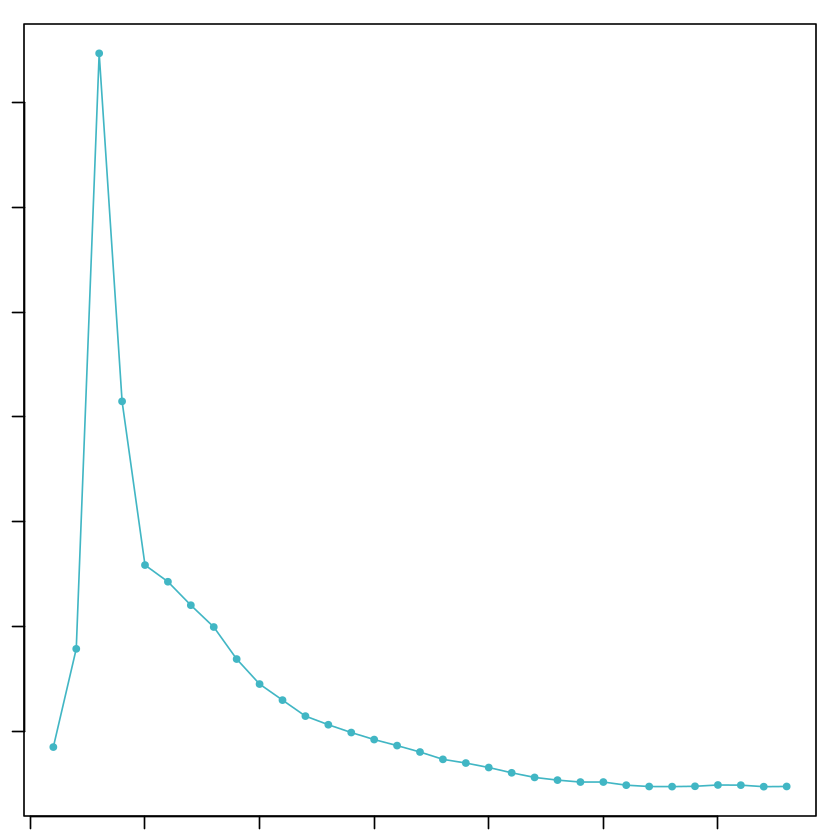

[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
NULL
[1] "Creating 4826 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."
[1] "GSM7937478_CNCL-34-2-clean"


Centering and scaling data matrix

PC_ 1 
Positive:  ALB, APOC3, MT1G, TTR, APOA1, APOA2, FGB, RBP4, CYP2E1, HP 
	   SERPINA1, FGG, APOH, AMBP, APOC1, TF, ORM1, FGA, VTN, APOC2 
	   ALDOB, ADH1B, FABP1, HPX, AHSG, MT1H, ADH4, ORM2, HBB, ASS1 
Negative:  CYBA, CD74, HLA-DRB1, HLA-B, ITM2B, B2M, PSAP, ACTB, HLA-DPA1, RNASET2 
	   TMSB10, GRN, HLA-DRA, HLA-DQA1, PTMA, CTSS, PFN1, ATP6V0C, VIM, HLA-DPB1 
	   FGL2, CD63, HLA-DRB5, RPL28, S100A11, HLA-DQB1, TMSB4X, GSTP1, CTSC, IFI30 
PC_ 2 
Positive:  NKG7, CCL5, S100A4, DUSP2, CCL4, CRIP1, CD52, JUNB, S100A6, CTSC 
	   FOS, IL2RB, DUSP1, HSPA1A, GZMH, LTB, MALAT1, NR4A2, PFN1, ACTG1 
	   CCL4L2, JUN, IFNG, XCL1, CD8B, XCL2, CYBA, RGS2, IL7R, CCL3 
Negative:  PLPP3, FCN3, RAMP3, DNASE1L3, CRHBP, CLEC4G, CLEC3B, TSPAN7, FCN2, CCL14 
	   HSPG2, RAMP2, LIFR, APP, TM4SF1, NPDC1, OIT3, TIMP3, IL33, CLEC1B 
	   GNG11, RNASE1, TINAGL1, CLDN5, KDR, IFI27, PTPRB, EGFL7, SPARC, CAVIN2 
PC_ 3 
Positive:  FOLR2, CFD, C1QC, CD163, C1QB, CSF1R, CD5L, C1Q

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12978
Number of edges: 398847

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8363
Number of communities: 18
Elapsed time: 3 seconds
[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



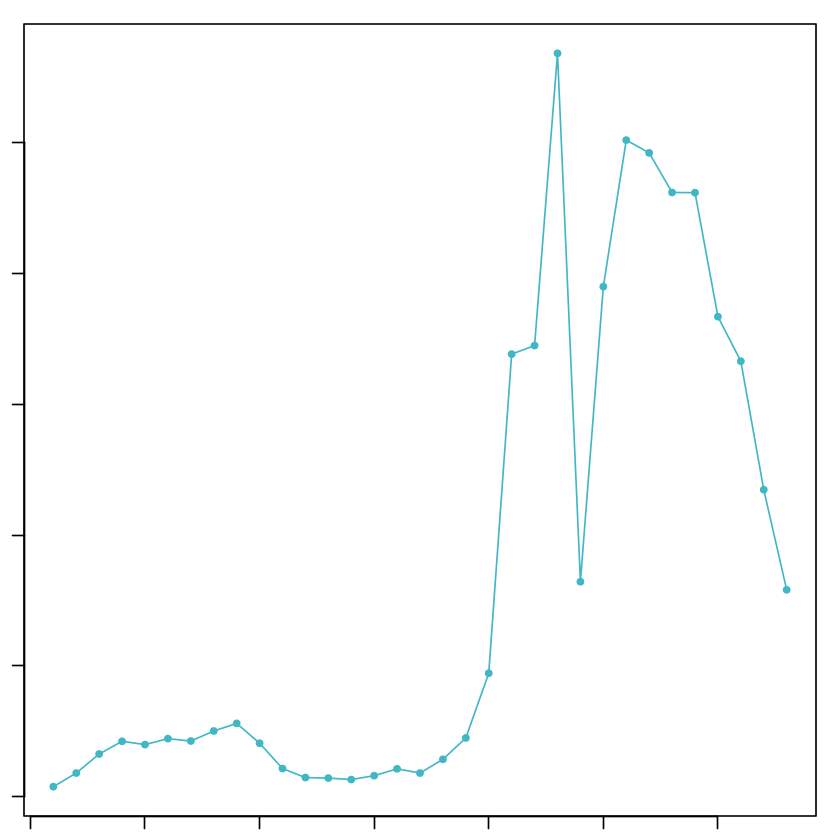

[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
NULL
[1] "Creating 4326 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."
[1] "GSM7937479_CNCL-36-1-clean"


Centering and scaling data matrix

PC_ 1 
Positive:  ESAM, CLEC14A, CLEC3B, HYAL2, RAMP2, PLPP1, EMCN, PODXL, ENG, ADCY4 
	   CDH5, PECAM1, CD34, TIE1, ICAM2, ECSCR, RNASE1, HSPG2, KLF2, HEG1 
	   PTPRB, NOTCH4, A2M, CALCRL, S1PR1, MMRN2, SLCO2A1, ADGRL4, GSN, PLVAP 
Negative:  CALCA, GNAS, CALCB, FTL, CHGB, S100A6, GPX2, CARTPT, PCSK1N, EDN3 
	   AKR1C2, S100A4, CHGA, GRP, SEC11C, STMN2, TFF3, PART1, PHGR1, ALB 
	   GAPDH, SORD, PLN, PLGLB2, DNASE2B, RAMP1, APOA2, MT1G, HP, NR0B1 
PC_ 2 
Positive:  PLVAP, PECAM1, RAMP2, SPARC, CLEC14A, IGFBP7, RNASE1, CD34, EGFL7, PTPRB 
	   ESAM, ENG, HSPG2, FLT1, TIE1, CALCRL, PODXL, CDH5, A2M, ADCY4 
	   EMCN, ADGRL4, ECSCR, NOTCH4, SLC9A3R2, MMP2, COL4A1, LDB2, S1PR1, AQP1 
Negative:  SEZ6L2, CALCA, FOS, TPBG, JUNB, FOSB, MATN2, PCSK2, CADM1, CPE 
	   GFRA4, SCG5, SPINT2, TENM2, EPCAM, ZFP36, PLD3, RET, BCAM, P4HTM 
	   KIAA1324, SCG3, JUN, SYT1, SEMA3E, TMEM59, TUSC3, FAM20A, CLU, ATP1B1 
PC_ 3 
Positive:  CD37, ITGB2, PTPRC, CXCR4, HLA-DRB1, LSP

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 32815
Number of edges: 781766

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7702
Number of communities: 18
Elapsed time: 17 seconds
[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 5e-04..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 5e-04..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 5e-04..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 5e-04..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 5e-04..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



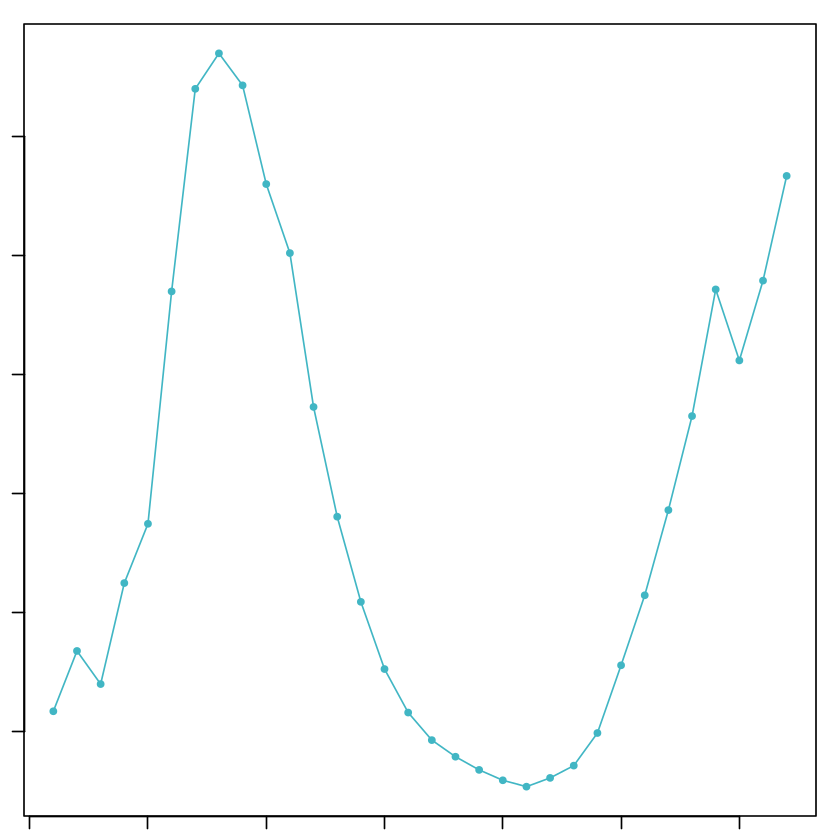

[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 5e-04..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
NULL
[1] "Creating 10938 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."
[1] "GSM7937480_CNCL-36-2-clean"


Centering and scaling data matrix

PC_ 1 
Positive:  HSPG2, PLPP3, TIMP1, PTPRB, ITM2B, CTSD, ACP5, CRHBP, A2M, FCGRT 
	   FOSB, DNASE1L3, IGFBP7, IFITM3, EGFL7, CTSL, HLA-C, TM4SF1, LIFR, CLEC4M 
	   FCN2, HLA-B, CLEC4G, HYAL2, FCGR2B, STAB2, ENG, MEG3, STAB1, TCIM 
Negative:  MT-CO1, ALB, IGKV2-29, IGLV2-14, IGHV3-74, IGLV8-61, IGHV3-7, IGKV2D-28, GSTA1, IGKV3-11 
	   IGKV2-24, IGHV3-73, JCHAIN, IGHV3-48, IGKV3-15, HBB, MT1B, IGLV1-40, SERPINA1, CALCA 
	   IGHV3-23, IGKV4-1, CPA3, IGLV1-44, PPBP, IGHV5-51, IGHV4-31, IGLV3-9, IGHV7-4-1, IGKC 
PC_ 2 
Positive:  MT-CO1, DNASE1L3, FCN3, CRHBP, CLEC4G, FCN2, CCL14, OIT3, HSPG2, STAB2 
	   PLPP3, STAB1, CLEC4M, LIFR, CLEC1B, CTSL, PTPRB, FCGR2B, MEG3, IGFBP7 
	   TSPAN7, ENG, AKAP12, CAVIN2, ACP5, CLEC3B, IGFBP4, TIMP3, RAMP3, RELN 
Negative:  S100A6, VIM, S100A4, TYROBP, CD52, RNASET2, CRIP1, CCL4, NR4A2, VSIR 
	   DUSP2, FCER1G, RPS2, RGS10, ACTG1, CCL5, CD7, MALAT1, CTSS, NKG7 
	   LYZ, CCL3, IFI30, RPL18A, PYCARD, C1orf162, RPS3, FGR, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 14574
Number of edges: 410448

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8176
Number of communities: 17
Elapsed time: 4 seconds
[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



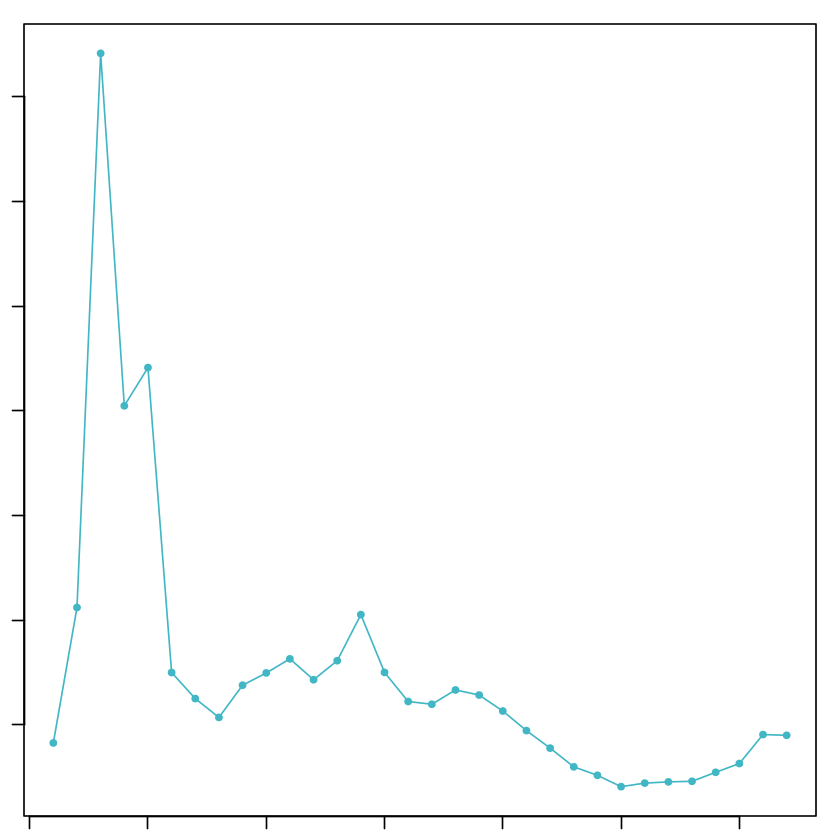

[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
NULL
[1] "Creating 4858 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."
[1] "GSM7937481_CNCL-37-1-clean"


Centering and scaling data matrix

PC_ 1 
Positive:  CXCL14, S100A1, ALB, CLU, IGHG1, APOA1, SCGB1B2P, HP, SERPINA1, SERPINA3 
	   FGB, IGKC, PRSS23, VTN, AMBP, ORM1, FGA, TTR, LTF, HPX 
	   FGG, RBP4, AHSG, APOH, TF, CPB1, TSPAN1, IGHG2, ORM2, BGN 
Negative:  SRGN, CD3E, PTPRCAP, IL2RG, CD69, CD3D, CORO1A, LSP1, HCST, CD52 
	   DUSP2, S100A4, CD7, CD2, CST7, FYB1, TAGAP, CD53, DOK2, TNFAIP3 
	   APOBEC3G, LCP2, VIM, NR4A2, CTSW, ALOX5AP, COTL1, RGCC, GZMA, ITGB2 
PC_ 2 
Positive:  ALB, CD3E, PTPRCAP, CD3D, CD52, IL2RG, CD2, IGHG1, CD7, LTB 
	   APOA1, CST7, CORO1A, IL7R, CD69, HP, CD247, HCST, TRBC2, LAT 
	   SPOCK2, CD27, CCL5, GZMA, CXCR4, CD3G, GZMM, FYB1, RGCC, SRGN 
Negative:  CLDN4, EEF1A2, CLDN3, KLF4, ELF3, SLC25A5, NUCB2, PRSS23, WFDC2, TACSTD2 
	   IER3, RASD1, NAALADL2-AS2, RHOB, TUBB4B, LMCD1, HERPUD1, PTGR1, MGST1, LGALS3 
	   SLC31A2, GDF15, CKS1B, EGR4, TUBB, MANF, MDK, HOXC10, MYC, AGR3 
PC_ 3 
Positive:  CD68, C1QC, FCER1G, TREM2, TYROBP, IFI30, SPI1, C1QB, C1QA, PLAU

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 16996
Number of edges: 494674

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8363
Number of communities: 20
Elapsed time: 4 seconds
[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



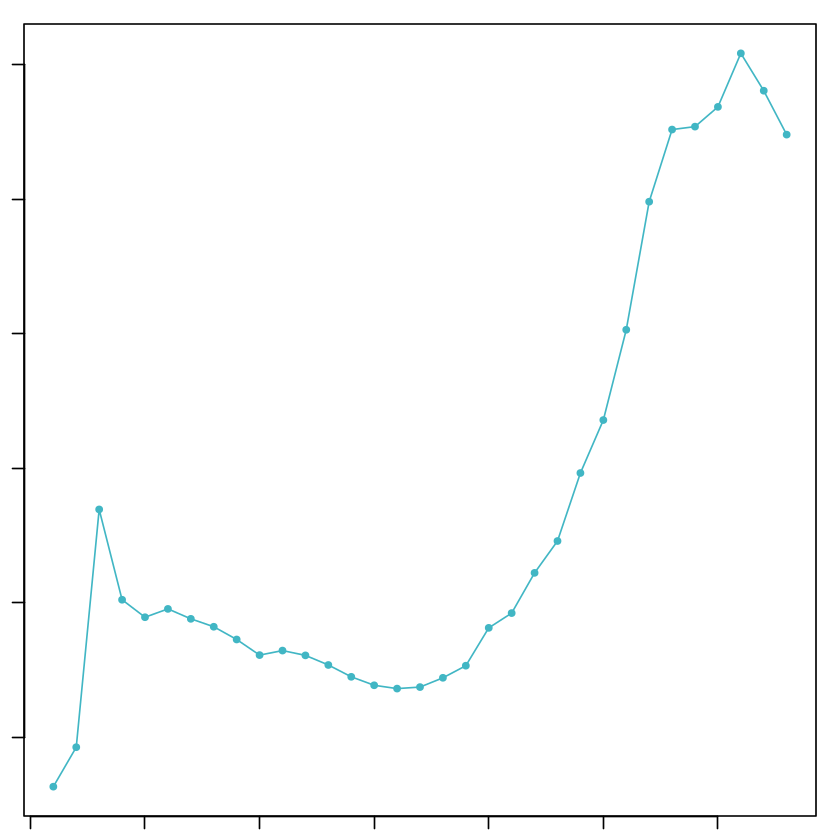

[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
NULL
[1] "Creating 5665 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."
[1] "GSM7937482_CNCL-37-2-clean"


Centering and scaling data matrix

PC_ 1 
Positive:  MT-CO1, VTN, HBB, CLU, SERPINA3, APCS, HBA2, AGT, CPB2, PPBP 
	   ALAS2, HBA1, APOC1, HBM, IGKV1D-16, IGKV2-24, AC099811.3, AC006329.1, ASPN, IGKV3D-20 
	   DBH, IGKV3-11, PGAM2, LUM, TMEM40, CSPG4, DOK6, HDC, AL157895.1, OLFML1 
Negative:  CYBA, HLA-A, SH3BGRL3, SRGN, OAZ1, PFN1, RPS2, ACTB, ITM2B, RPL28 
	   RPS19, PTMA, RPS3, RPL18A, RPS28, ACTG1, B2M, RPLP0, RPS13, RPL19 
	   RPS8, HLA-DRB1, RPS24, RPS23, RPL13, TMSB10, ATP6V0C, VIM, RPS27A, SERF2 
PC_ 2 
Positive:  FOLR2, MS4A7, VSIG4, IGSF6, CD68, CD163, CPVL, CFP, CFD, C1QC 
	   IFI30, LGMN, CD5L, MS4A6A, FCGRT, CST3, LILRB5, C1QB, MAFB, C1QA 
	   CSF1R, CD14, SPI1, AIF1, MS4A4A, CTSB, GRN, VMO1, SDC3, HMOX1 
Negative:  NKG7, CCL5, CD7, KLRB1, IL32, IFITM1, GZMH, GZMK, CD69, LSP1 
	   ACTG1, IL2RB, CD160, RPS3, CD8A, NCR3, CLIC3, CRIP1, XCL1, EOMES 
	   C12orf75, KLRF1, XCL2, GZMB, S100A4, KLRC3, RPS27A, TIGIT, RPS27, TRDC 
PC_ 3 
Positive:  HSPG2, DNASE1L3, EGFL7, CCL14, PLPP

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 31699
Number of edges: 872217

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8273
Number of communities: 26
Elapsed time: 7 seconds
[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 5e-04..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 5e-04..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 5e-04..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 5e-04..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 5e-04..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



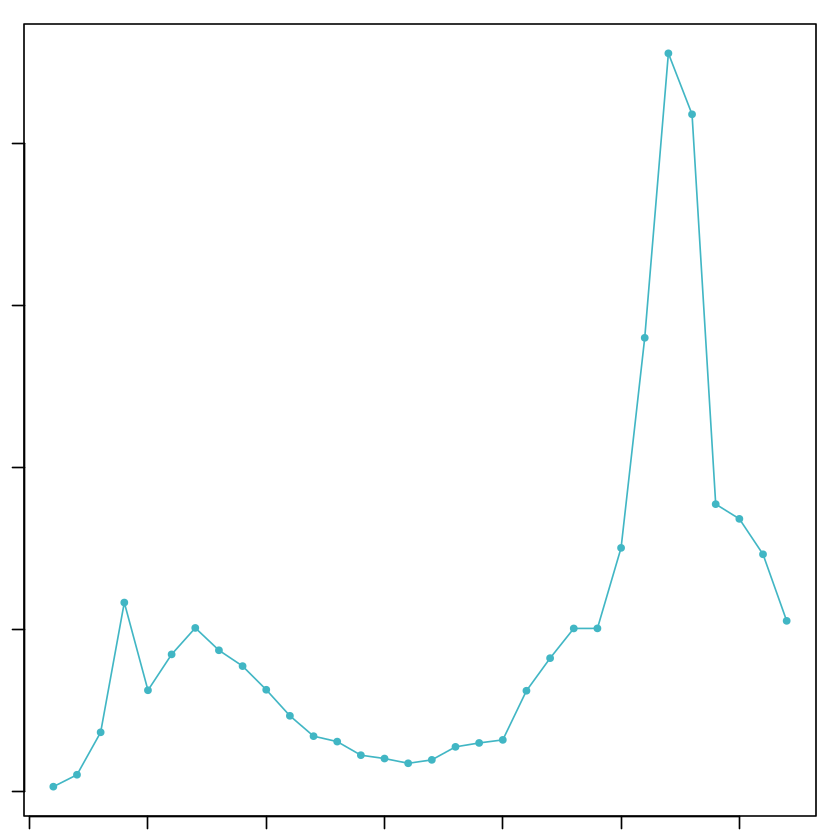

[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 5e-04..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
NULL
[1] "Creating 10566 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."
[1] "GSM7937483_CNCL-43-1"


Centering and scaling data matrix

PC_ 1 
Positive:  MT-CO2, MT-CO1, IGKV4-1, IGLV2-8, ALB, COL1A1, HP, APOC3, IGKV3-20, IGLC1 
	   IGKV3-11, HBB, COL3A1, APOA2, IGHG3, COL1A2, APOA1, IGHM, COL5A1, IGHV3-64 
	   HRG, F2, FGB, FGG, C3, IGHV4-59, IGLV2-14, ITIH3, IGLV1-44, IGHV3-74 
Negative:  BTG1, DNAJB1, SRGN, DUSP2, ZFP36L2, HLA-B, HLA-C, B2M, JUNB, DUSP1 
	   CD69, RAC2, ZFP36, CST7, S100A4, CCL5, CD3D, CD52, HSPA1B, TNFAIP3 
	   RPS15A, RPS12, RPL10, NFKBIA, RPLP1, RPL7A, RPL28, H3F3B, ACTB, CYBA 
PC_ 2 
Positive:  DUSP2, CD69, CCL5, CST7, CD3D, RAC2, SRGN, ZFP36L2, TNFAIP3, NKG7 
	   CD52, BTG1, CTSW, IL7R, IL2RG, TAGAP, CCL4, GZMK, CD7, CD2 
	   S100A4, GZMA, HLA-B, TRBC2, CD8A, LCK, IFITM1, TUBA4A, SOCS1, CORO1A 
Negative:  SCGB2A2, GSTM3, PVALB, KRT19, S100A14, MUCL1, CCT2, TFF3, PPDPF, KRT18 
	   H2AFJ, AC093001.1, ADIRF, MIF, TXN, ATP5PF, MAGEA3, CRABP2, CD24, C15orf48 
	   DCXR, ALDOA, S100A16, S100A13, AKR7A3, ATP5MPL, UQCRQ, RAB5C, ROMO1, CKB 
PC_ 3 
Positive:  HLA-DRA, C1

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 45689
Number of edges: 1230165

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8238
Number of communities: 19
Elapsed time: 17 seconds
[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 5e-04..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 5e-04..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 5e-04..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 5e-04..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 5e-04..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



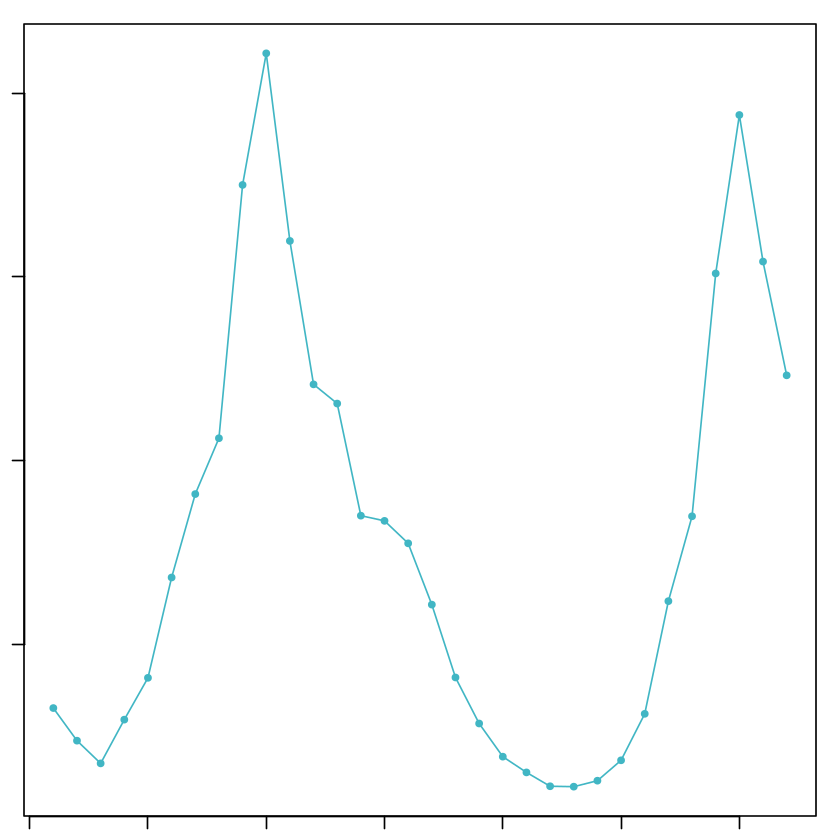

[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 5e-04..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
NULL
[1] "Creating 15230 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."
[1] "GSM7937484_CNCL-43-2"


Centering and scaling data matrix

PC_ 1 
Positive:  CCL5, NKG7, CD69, DUSP2, CD7, CCL4, S100A4, KLRB1, CCL4L2, GZMH 
	   LTB, ANXA1, IL7R, CD160, CD8B, SPON2, IFNG, EOMES, IL2RB, CXCR6 
	   XCL2, XCL1, CD27, CLIC3, CRIP1, TRGV2, CCL3L1, S100A6, TRDC, TNF 
Negative:  PLPP3, IGFBP7, TM4SF1, CRHBP, GNG11, HSPG2, CCL14, A2M, DNASE1L3, CLEC3B 
	   IGFBP4, SPARC, RAMP2, IFITM3, TIMP1, RNASE1, APP, TSPAN7, RAMP3, IFI27 
	   CLDN5, NPDC1, TIMP3, PTPRB, CLEC4G, FCN3, CD36, TGM2, TINAGL1, CLEC4M 
PC_ 2 
Positive:  ALB, FCN3, GNG11, CCL14, HSPG2, CRHBP, SPARC, IGFBP7, TM4SF1, DNASE1L3 
	   PLPP3, CLEC4G, RAMP3, TSPAN7, TIMP3, FCN2, TINAGL1, PTPRB, CLDN5, RNASE1 
	   LDB2, CLEC4M, APP, OIT3, ADGRF5, LIFR, IL33, CLEC3B, NPDC1, TFPI 
Negative:  CFD, IFI30, CPVL, AIF1, CST3, CD68, C1QC, C1QA, C1QB, LILRB2 
	   FOLR2, SPI1, CD5L, FCER1G, MS4A7, CD163, MARCO, CTSS, HLA-DRA, LST1 
	   TYROBP, BLVRB, VSIG4, IGSF6, CSF1R, MAFB, C1orf162, HLA-DPA1, RNASET2, HMOX1 
PC_ 3 
Positive:  ACTG1, IFITM1, NKG7, AC

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5796
Number of edges: 187164

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8778
Number of communities: 18
Elapsed time: 0 seconds
[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



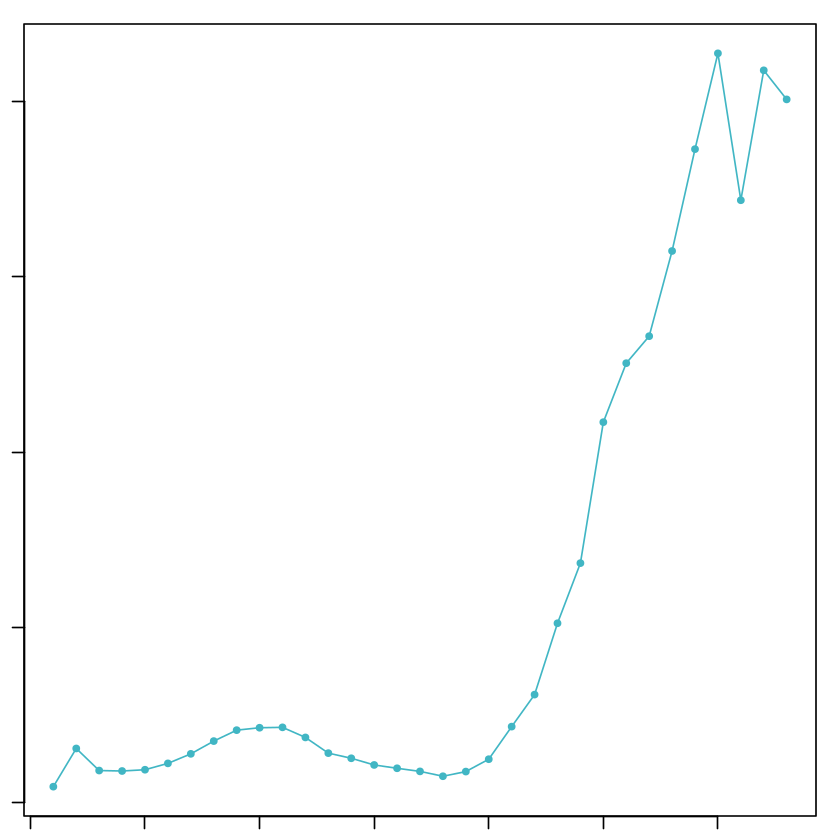

[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
NULL
[1] "Creating 1932 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."
[1] "GSM7937485_CNCL-48-1"


Centering and scaling data matrix

PC_ 1 
Positive:  HEBP2, ELF3, AQP5, CLDN3, C11orf74, S100A14, YBX3, KRT6B, TM4SF1, CITED4 
	   LAPTM4B, EFNA1, SERINC2, RAB25, LSR, IMPA2, CLDN10, MGST1, CRNDE, NME4 
	   TNFRSF12A, PPP1R1A, LDLRAD3, ST3GAL4, ASS1, CXCL3, EFHD1, MAL2, KRT8, NEURL1 
Negative:  IGLV3-19, IGKC, IGKV3-20, IGLV2-14, IGLV1-51, IGHV4-34, IGKV3-11, IGHV4-39, JCHAIN, MZB1 
	   IGHG2, IGKV4-1, ITM2C, IGLC2, IGHV5-51, IGHG3, IGHA1, IGHM, IGKV1-12, IGLC3 
	   CD79A, IGHV1-18, IGKV1-5, FKBP11, IGHV3-74, IGLV3-1, IGKV1-9, PIM2, IGHV3-43, IGLC1 
PC_ 2 
Positive:  CST3, TMEM176B, CD68, IFI30, TMEM176A, TYROBP, FCER1G, LILRB4, CSF1R, LYZ 
	   SERPINA1, FGL2, AIF1, C1QC, CALHM6, C1QB, CYBB, TGFBI, MS4A6A, IGSF6 
	   C1QA, SPI1, C15orf48, LILRB2, FCGR3A, CTSL, GRN, PLXDC2, PILRA, LST1 
Negative:  MGP, PI3, SLPI, IGLV3-19, CALML5, KRT8, IGLV2-14, IGKV3-20, FDCSP, KRT14 
	   IGKC, AQP5, S100A14, MMP7, S100A1, CRABP2, KRT6B, IGLV1-51, IGHV4-34, CLDN10 
	   CLDN3, OLFM4, RAB25, LDLRAD3, TM

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 12107
Number of edges: 383919

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8640
Number of communities: 15
Elapsed time: 1 seconds
[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



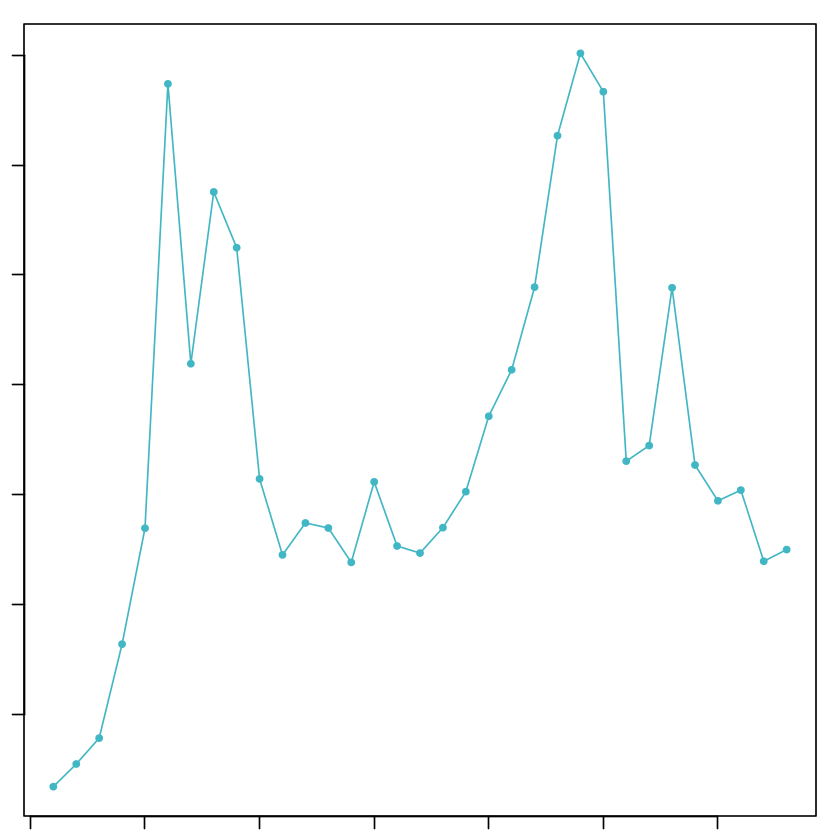

[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
NULL
[1] "Creating 4036 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."
[1] "GSM7937486_CNCL-48-2"


Centering and scaling data matrix

PC_ 1 
Positive:  FCGRT, MS4A6A, LGMN, CFP, TIMP1, GRN, IFI27, CD4, LYVE1, MRC1 
	   CTSB, CETP, NPC2, CTSL, SELENOP, SLC40A1, IFITM3, PLTP, CTSD, PSAP 
	   CXCL16, CD14, FXYD6, TIMP2, CD36, PLD3, CST3, SDC3, CFD, CDH5 
Negative:  ALB, HP, APOA2, IL2RB, APOA1, XCL2, CRIP1, LTB, TTR, CD8B 
	   TF, APOC3, ORM1, CD27, APOH, AMBP, TRDC, TRAV1-2, XCL1, FGB 
	   APOC2, KLRF1, CES1, ISG20, KLRC2, SPON2, CCL4, RBP4, FGG, FGA 
PC_ 2 
Positive:  CFD, C1QC, IFI30, C1QA, MS4A7, CD5L, C1QB, TYROBP, FCER1G, CD68 
	   AIF1, CSF1R, CD163, FOLR2, MARCO, VSIG4, HLA-DRA, HLA-DPB1, IGSF6, MPEG1 
	   HLA-DPA1, RNASET2, CST3, CTSS, CPVL, AXL, CYBB, HLA-DQA1, CD74, SPI1 
Negative:  IGFBP7, HSPG2, DNASE1L3, CLEC3B, PLPP3, RAMP3, SPARC, APP, GNG11, CRHBP 
	   NPDC1, CLEC4G, TIMP3, CCL14, TSPAN7, FCN3, OIT3, FCN2, TM4SF1, RAMP2 
	   RNASE1, PTPRB, EGFL7, KDR, IL33, CAVIN2, CLEC1B, STAB1, TINAGL1, STAB2 
PC_ 3 
Positive:  CCL4, CRIP1, CYBA, LTB, SUB1, IL2RB, XCL2, ISG20, CD8B, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8089
Number of edges: 259595

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8764
Number of communities: 20
Elapsed time: 1 seconds
[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



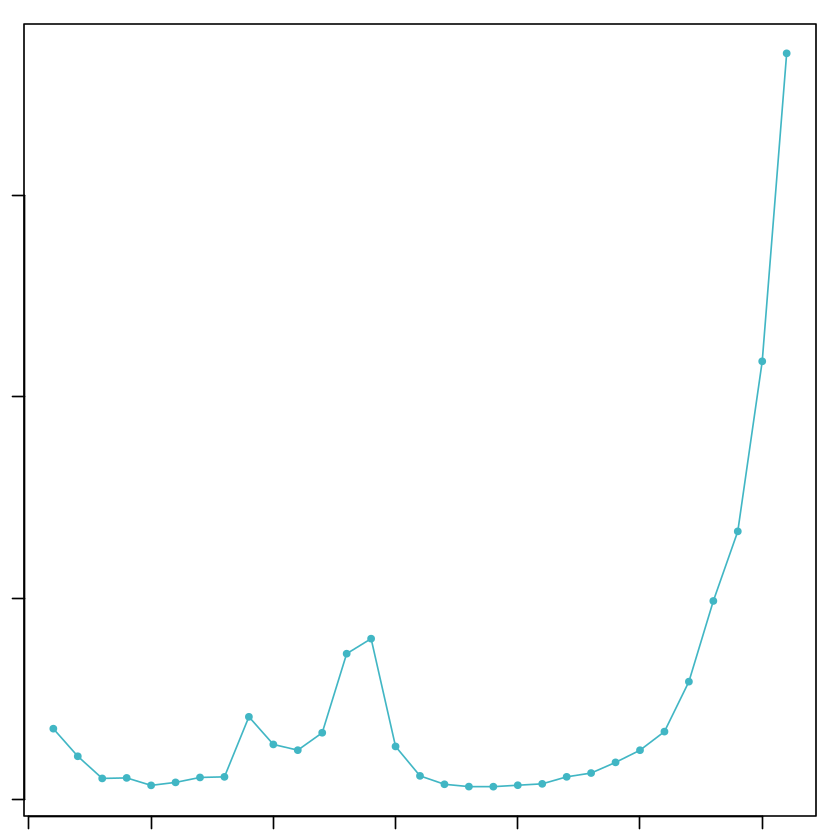

[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
NULL
[1] "Creating 2696 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."
[1] "GSM7937487_CNCL-55-1-clean"


Centering and scaling data matrix

PC_ 1 
Positive:  LYZ, FCER1G, CST3, SERPINA1, TYROBP, PLAUR, TMEM176B, C15orf48, CD68, IL1B 
	   TMEM176A, IGSF6, CD14, IFI30, CSF1R, AIF1, TGFBI, PLXDC2, GRN, OLR1 
	   CTSZ, CTSB, FGL2, LILRB4, CLEC7A, APOC1, SPI1, C1QC, IER3, MS4A6A 
Negative:  IGHG1, MZB1, IGKV3-20, IGKC, FKBP11, ITM2C, DERL3, IGHG4, JCHAIN, IGLC2 
	   IGLV2-14, GZMH, IGLV3-1, IGLC3, IGLV3-21, IGHV4-39, JSRP1, PIM2, IGLC1, IGHG3 
	   IGLV6-57, IGLV1-47, IFNG, LAG3, CXCL13, IGKV3D-20, IGHJ6, IGHV3-7, IGLV1-44, LINC02446 
PC_ 2 
Positive:  CD24, PERP, UBD, STMN1, MARCKSL1, S100A14, IFI27, SOX4, NREP, LDHB 
	   MARCO, TUBA1B, TUBB2B, EPCAM, BEX3, BCL2A1, PRRX1, KRT8, CLDN4, MDK 
	   YBX3, FABP6, HDAC2, TUBA1C, FKBP4, CKS1B, HSPD1, KRT18, KRT19, CSTA 
Negative:  CCL4, CCL4L2, TYROBP, FTL, RGS2, HERPUD1, FCER1G, CD68, CCL3L1, ACP5 
	   CD79A, AIF1, IGHG1, CCL3, MZB1, CYBB, SPI1, ITM2C, CTSD, IGKC 
	   XBP1, C15orf48, LST1, CTSC, SAT1, FGL2, PLEK, IGSF6, GPR183, CD14 
PC_ 3 
Positive: 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8734
Number of edges: 291359

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8785
Number of communities: 21
Elapsed time: 1 seconds
[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



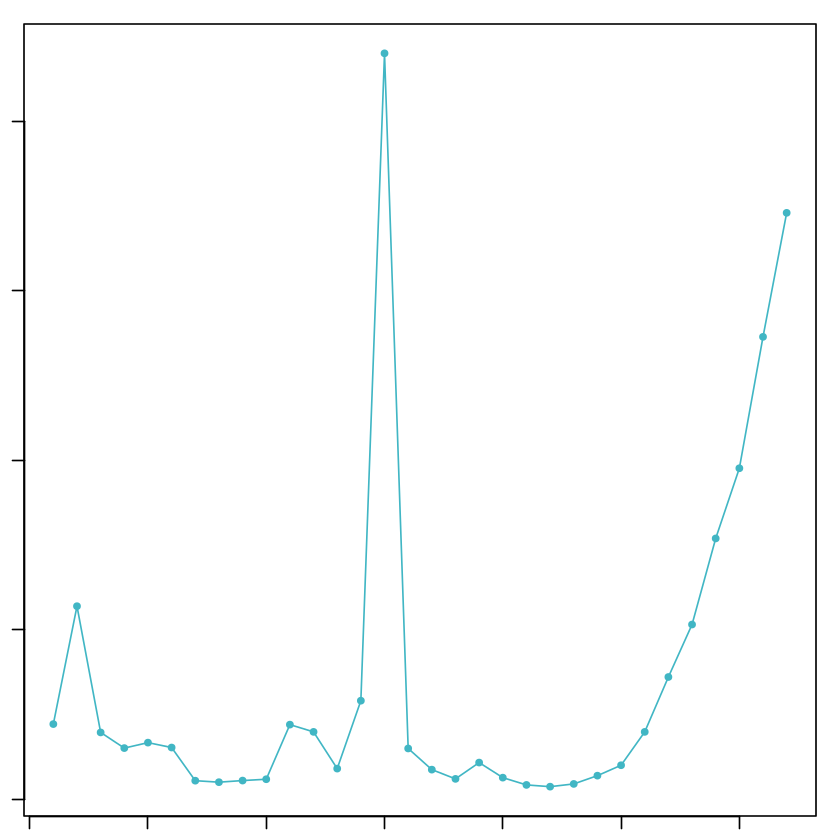

[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
NULL
[1] "Creating 2911 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."
[1] "GSM7937488_CNCL-55-2-clean"


Centering and scaling data matrix

PC_ 1 
Positive:  NKG7, CD7, CD69, GZMH, S100A4, DUSP2, KLRB1, CCL4, XCL2, CD8B 
	   IL2RB, CRIP1, XCL1, MALAT1, DNAJB1, IFNG, NR4A2, LTB, LINC02446, CD27 
	   TRGV9, S100A6, RGS1, CXCR4, JUNB, GNLY, TRDC, SPON2, CLIC3, GZMB 
Negative:  FCGRT, IFITM3, SELENOP, MS4A6A, TIMP1, IFI27, LGMN, CTSL, CTSB, CFP 
	   GRN, CD14, NPC2, CST3, CD4, CETP, CCL14, CD36, DNASE1L3, PLPP3 
	   IFI6, FCN3, CRHBP, IGFBP4, CXCL16, A2M, PSAP, CTSD, CLEC4G, SERPING1 
PC_ 2 
Positive:  IFI30, HLA-DRA, CD74, TYROBP, FCER1G, AIF1, HLA-DPA1, SPI1, LST1, CST3 
	   HLA-DRB1, HLA-DPB1, CSF1R, MS4A7, IGSF6, CD68, CTSS, MPEG1, CFD, RNASET2 
	   CYBB, HLA-DQB1, HLA-DMA, C1QB, LYZ, C1QC, C1QA, CPVL, C1orf162, HLA-DQA1 
Negative:  FCN3, CCL14, DNASE1L3, CLEC4G, CRHBP, FCN2, PLPP3, CLEC1B, GNG11, IGFBP7 
	   OIT3, RAMP3, IGFBP4, APP, CLEC4M, TSPAN7, CLDN5, HSPG2, TM4SF1, SPARC 
	   CLEC3B, NPDC1, STAB2, STAB1, RAMP2, TIMP3, CD36, EGFL7, A2M, IL33 
PC_ 3 
Positive:  FXYD2, DEFB1, KRT7, KR

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6204
Number of edges: 202981

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8699
Number of communities: 21
Elapsed time: 0 seconds
[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



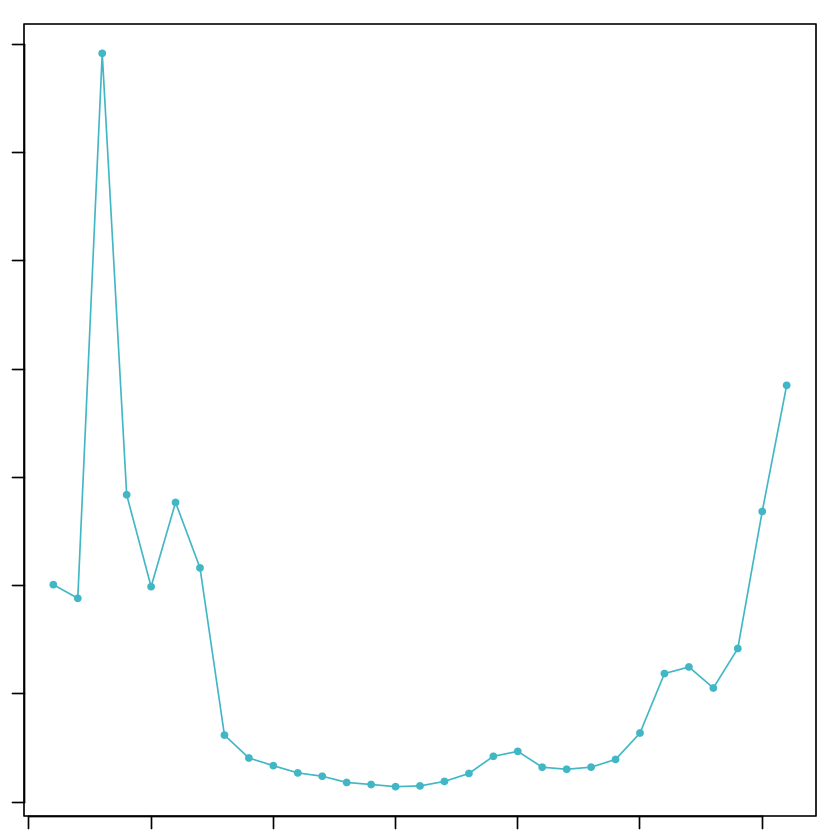

[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."


In [ ]:
file_paths <- list.files("../public_data/Wang_iScience_2024_Liver_Met_Data/",pattern="*.gz")
prefixes <- sapply(file_paths,function(x){gsub("-features.*|-barcode.*|-matrix.*","",x)})

file_df <- data.frame(path=file_paths,prefix=prefixes,row.names=NULL)  %>%
    mutate(file_type=case_when(grepl("matrix",path) ~ "Matrix",
                        grepl("features",path) ~ "Features",
                        grepl("barcodes",path) ~ "Barcodes"))

prefixes <- unique(file_df$prefix)
wang_iscience_2024_pseudobulk_df <- NULL

geo_info <- getGEO("GSE249361")
pdata_df <- pData(geo_info[[1]])

wang_2024_obj <- NULL
for (prefix_ in prefixes) {
    print(prefix_)
    matrix_path <- file_df %>% dplyr::filter(prefix == prefix_ & file_type == "Matrix") %>% pull(path)
    gene_path <- file_df %>% dplyr::filter(prefix == prefix_ & file_type == "Features") %>% pull(path)
    barcode_path <- file_df %>% dplyr::filter(prefix == prefix_ & file_type == "Barcodes") %>% pull(path)

    barcodes <- fread(file.path("../public_data/Wang_iScience_2024_Liver_Met_Data/",barcode_path),header=F) %>% pull(V1)
    gene_info_df <- fread(file.path("../public_data/Wang_iScience_2024_Liver_Met_Data/",gene_path),header=F)
    mat <- readMM(file.path(file.path("../public_data/Wang_iScience_2024_Liver_Met_Data/",matrix_path)))
    
    rownames(mat) <- gene_info_df$V1
    colnames(mat) <- barcodes
    
    num_expressed_genes <- colSums(mat > 0)
    num_counts <- colSums(mat)
    barcodes_to_keep <- names(which(num_expressed_genes > 250 | num_counts > 500))
    mat <- mat[,barcodes_to_keep]
    
    unique_genes <- dplyr::count(gene_info_df,V2) %>% dplyr::filter(n == 1) %>% pull(V2)
    non_unique_genes <- dplyr::count(gene_info_df,V2) %>% dplyr::filter(n > 1) %>% pull(V2)
    
    unique_gene_ids <- dplyr::filter(gene_info_df,V2 %in% unique_genes) %>% pull(V1)
    unique_mat <- mat[unique_gene_ids,barcodes_to_keep]
    non_unique_mat <- matrix(0,nrow=length(non_unique_genes),ncol=length(barcodes_to_keep),
                             dimnames=list(non_unique_genes,barcodes_to_keep))
    for (gene in non_unique_genes) {
        gene_ids <- dplyr::filter(gene_info_df,V2 == gene) %>% pull(V1)
        non_unique_mat[gene,barcodes_to_keep] <- colSums(mat[gene_ids,barcodes_to_keep])
    }

    non_unique_mat <- as(non_unique_mat,"dgCMatrix")
    gene_id_to_name_vec <- dplyr::filter(gene_info_df,V1 %in% rownames(mat)) %>% dplyr::select(-V3) %>% tibble::deframe(.)
    rownames(unique_mat) <- gene_id_to_name_vec[rownames(unique_mat)]
    mat <- rbind(unique_mat,non_unique_mat)

    
    gsm_num <- str_match(matrix_path,"GSM[0-9][0-9]*") %>% unlist %>% as.character

    tissue_info_list <- str_split(pdata_df[gsm_num,"characteristics_ch1"],",")
    cancer_type <- sapply(tissue_info_list,function(x){x[[2]]})
    sample_type <- sapply(tissue_info_list,function(x){ifelse(grepl("adjacent",x[[1]]),"CCME","MME")})
    title <- pdata_df[gsm_num,"title"] %>% gsub("Sample ","",.)

    # sex <- pdata_df[gsm_num,"characteristics_ch1.2"] %>% gsub("Sex: ","",.)
    # sex <- ifelse(sex == "Male","M","F")

    colnames(mat) <- paste(title,colnames(mat),sep="_")
    obj <- CreateSeuratObject(mat,project = title)
    
    obj <- NormalizeData(obj) %>% FindVariableFeatures %>% ScaleData %>% RunPCA(.,npcs=10) %>% 
    RunUMAP(.,dims=1:10) %>% FindNeighbors %>% FindClusters(.,dims=1:10)
    
    sweep.res.list <- paramSweep_v3(obj, PCs = 1:10, sct = FALSE)
    sweep.stats <- summarizeSweep(sweep.res.list, GT = FALSE)
    bcmvn <- find.pK(sweep.stats)
    best_pK <- head(arrange(bcmvn,-BCmetric),1) %>% pull(pK) %>% as.vector %>% as.numeric
    
    homotypic.prop <- modelHomotypic(obj@meta.data$seurat_clusters)           ## ex: annotations <- seu_kidney@meta.data$ClusteringResults
    nExp_poi <- round(0.08*nrow(obj@meta.data))  ## Assuming 7.5% doublet formation rate - tailor for your dataset
    nExp_poi.adj <- round(nExp_poi*(1-homotypic.prop))

    obj <- doubletFinder_v3(obj, PCs = 1:10, pN = 0.25, pK = best_pK, 
                    nExp = nExp_poi, reuse.pANN = FALSE, sct = FALSE)
    
    col_names <- colnames(obj@meta.data)
    pann_col <- col_names[grepl("pANN_",col_names)]
    classification_col <- col_names[grepl("DF.classifications_",col_names)]
    obj$doublet_classification <- obj@meta.data[[classification_col]]
    obj$doublet_pANN <- obj@meta.data[[pann_col]]
    obj[[pann_col]] <- NULL
    obj[[classification_col]] <- NULL
    
    obj$percent.mt <- PercentageFeatureSet(obj, pattern = "^MT-")
    obj <- DietSeurat(obj)   
    
    obj$subsets_mito_percent <- PercentageFeatureSet(obj, pattern = "^MT-")
    
    obj$detected <- obj$nFeature_RNA
    model <- miQC::mixtureModel( as.SingleCellExperiment(obj) )
    intercept1 <- flexmix::parameters(model, component = 1)[1]
    intercept2 <- flexmix::parameters(model, component = 2)[1]
    if (intercept1 > intercept2) {
        compromised_dist <- 1
        intact_dist <- 2
    } else {
        intact_dist <- 1
        compromised_dist <- 2
    }
    
    post <- posterior(model)
    prob_compromised <- post[, compromised_dist]
    obj$prob_dead_cell <- prob_compromised
    obj$detected <- NULL

    obj <- subset(obj, subset = nCount_RNA > 500 & prob_dead_cell < 0.5 & doublet_classification == "Singlet" )
    obj$sample_type <- sample_type

    if (is.null(wang_2024_obj)) {
        wang_2024_obj <- DietSeurat( obj )
    } else {
        wang_2024_obj <- merge( wang_2024_obj, DietSeurat( obj ) )
    }
    sample_name <- paste("Wang_etal_iScience_2024",title,sample_type,sep="_")
    gene_exp_df <- tibble::enframe(rowSums(obj[["RNA"]]@counts),name="gene",value=sample_name)

    if (is.null(wang_iscience_2024_pseudobulk_df)) {
        wang_iscience_2024_pseudobulk_df <- gene_exp_df
    } else {
        wang_iscience_2024_pseudobulk_df <- merge( wang_iscience_2024_pseudobulk_df, gene_exp_df, by="gene")
    }    
}

saveRDS(wang_2024_obj,"../processed_data/Wang_2024_SeuratObject.rds")
fwrite( wang_iscience_2024_pseudobulk_df, "../processed_data/Wang_iScience_2024_Pseudobulk.csv.gz" )

In [5]:
wang_2024_obj <- readRDS("../processed_data/Wang_2024_SeuratObject.rds")

In [140]:
genes_to_use <- names(which(rowMeans(wang_2024_obj[["RNA"]]@counts > 0) >= 0.01))
wang_2024_obj <- subset( wang_2024_obj, features=genes_to_use) %>%
NormalizeData %>% FindVariableFeatures %>% ScaleData %>% RunPCA(.,npcs=30) %>% FindNeighbors %>% FindClusters

Centering and scaling data matrix

PC_ 1 
Positive:  MS4A6A, DNASE1L3, FCGRT, FCN3, CCL14, CTSL, CLEC4G, CRHBP, FCN2, CD4 
	   SELENOP, CLEC1B, OIT3, LYVE1, MRC1, STAB1, CFP, CD14, FCGR2B, CETP 
	   ALB, CD36, ENG, CXCL16, CLEC4M, STAB2, RAMP3, PLPP3, PLTP, FTL 
Negative:  CD24, PCSK1N, TFF3, DSP, SEC11C, ASCL1, SPINT2, GRP, STMN1, KRT18 
	   EPCAM, FN1, MIR205HG, CPE, UCHL1, CALCA, KRT8, ELF3, PERP, PCSK1 
	   TPH1, FXYD3, MAP1B, DNAJC12, CHGA, CLU, CKB, CHGB, BCAM, SNHG29 
PC_ 2 
Positive:  S100A16, LTF, KRT15, MARCKS, MARCKSL1, CD151, CLEC3A, CYP1B1, ANXA2, KRT19 
	   ZG16B, IFI27, CD164, FCGRT, S100A13, SCGB2A2, CLDN4, GRN, AQP5, S100A11 
	   EFNA1, LMNA, TNFSF10, CD36, PLPP3, STAB1, ADAM15, LGMN, CRACR2B, NOSTRIN 
Negative:  CALCA, CHGB, CALCB, PCSK1N, CHGA, CST4, CARTPT, VGF, CCL4, ALB 
	   IL2RB, XCL2, PHGR1, XCL1, APOC3, TFF3, AKR1C2, APOA2, IL7R, CD27 
	   TTR, SCG2, KLRF1, IFNG, UCHL1, TRDC, CPE, FABP1, RARRES2, TESC 
PC_ 3 
Positive:  FCN3, IGFBP7, CLEC4G, CCL14, DNASE1L3, F

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 132503
Number of edges: 3987963

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9360
Number of communities: 39
Elapsed time: 52 seconds


In [141]:
# wang_2024_ptprc_logfc_df <- FindAllMarkers(wang_2024_obj,features=c("PTPRC"))

cd45_clusters <- c(2,5,8,13,18,20,22,23,35,37,30) #Based on log-FC of PTPRC in original object
cd45_wang_2024_obj <- subset( wang_2024_obj, subset = seurat_clusters %in% cd45_clusters ) %>%
NormalizeData %>% FindVariableFeatures %>% ScaleData %>% RunPCA(.,npcs=30) %>% FindNeighbors %>% FindClusters
# non_cd45_wang_2024_obj <- subset( wang_2024_obj, subset = seurat_clusters %in% 
#                                  setdiff(unique(wang_2024_obj$seurat_clusters),cd45_clusters) ) %>%
# NormalizeData %>% FindVariableFeatures %>% ScaleData %>% RunPCA(.,npcs=30) %>% FindNeighbors %>% FindClusters

Centering and scaling data matrix

PC_ 1 
Positive:  CD68, CSF1R, CST3, MS4A7, MS4A6A, CPVL, C1QC, MAFB, C1QA, MS4A4A 
	   C1QB, CD163, IFI30, FCGRT, ADAP2, GRN, LILRB4, CTSB, CYBB, CD14 
	   LGMN, MPEG1, SLC7A7, AIF1, FOLR2, AXL, VSIG4, SDC3, MSR1, TGFBI 
Negative:  NKG7, CD69, CD7, KLRB1, CD8A, KLRD1, DUSP2, GZMH, ITM2A, IL7R 
	   CXCR6, CD8B, IL2RB, CD160, LINC01871, XCL2, CMC1, LTB, NCR3, XCL1 
	   CD27, TIGIT, IFNG, ACTG1, C12orf75, CCL4, TRAV1-2, SPON2, GPR171, CRIP1 
PC_ 2 
Positive:  TMSB4X, TMSB10, HSP90AA1, PFN1, ACTG1, TUBB, TYMS, CD7, GAPDH, HMGB1 
	   MKI67, PCLAF, CALR, STMN1, RRM2, TUBA1B, CTSC, UBE2C, HMGN2, YBX1 
	   TOP2A, NUSAP1, CRIP1, LDHA, NKG7, ATP5MC3, CDK1, HIST1H4C, ENO1, CDKN3 
Negative:  S100A8, S100A9, MNDA, FPR1, CSF3R, SLC25A37, G0S2, NAMPT, FCGR3B, GCA 
	   CXCR2, PTGS2, C5AR1, CDA, SOD2, SERPINA1, TREM1, SMIM25, LST1, TNFRSF10C 
	   SPI1, SLC11A1, PLAUR, NEAT1, FTH1, LILRB3, S100P, NCF2, BASP1, FCN1 
PC_ 3 
Positive:  CAPG, CD83, LGALS2, FCN1, CSTA, CD7

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 36676
Number of edges: 1170207

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8871
Number of communities: 24
Elapsed time: 6 seconds


In [142]:
cd45_clusters <- c(2,5,8,13,18,20,22,23,35,37,30) #Based on log-FC of PTPRC in original object
cd45_wang_2024_obj <- subset( wang_2024_obj, subset = seurat_clusters %in% cd45_clusters ) %>%
NormalizeData %>% FindVariableFeatures %>% ScaleData %>% RunPCA(.,npcs=30) %>% FindNeighbors %>% FindClusters
non_cd45_wang_2024_obj <- subset( wang_2024_obj, subset = seurat_clusters %in% 
                                 setdiff(unique(wang_2024_obj$seurat_clusters),cd45_clusters) ) %>%
NormalizeData %>% FindVariableFeatures %>% ScaleData %>% RunPCA(.,npcs=30) %>% FindNeighbors %>% FindClusters

Centering and scaling data matrix

PC_ 1 
Positive:  CD68, CSF1R, CST3, MS4A7, MS4A6A, CPVL, C1QC, MAFB, C1QA, MS4A4A 
	   C1QB, CD163, IFI30, FCGRT, ADAP2, GRN, LILRB4, CTSB, CYBB, CD14 
	   LGMN, MPEG1, SLC7A7, AIF1, FOLR2, AXL, VSIG4, SDC3, MSR1, TGFBI 
Negative:  NKG7, CD69, CD7, KLRB1, CD8A, KLRD1, DUSP2, GZMH, ITM2A, IL7R 
	   CXCR6, CD8B, IL2RB, CD160, LINC01871, XCL2, CMC1, LTB, NCR3, XCL1 
	   CD27, TIGIT, IFNG, ACTG1, C12orf75, CCL4, TRAV1-2, SPON2, GPR171, CRIP1 
PC_ 2 
Positive:  TMSB4X, TMSB10, HSP90AA1, PFN1, ACTG1, TUBB, TYMS, CD7, GAPDH, HMGB1 
	   MKI67, PCLAF, CALR, STMN1, RRM2, TUBA1B, CTSC, UBE2C, HMGN2, YBX1 
	   TOP2A, NUSAP1, CRIP1, LDHA, NKG7, ATP5MC3, CDK1, HIST1H4C, ENO1, CDKN3 
Negative:  S100A8, S100A9, MNDA, FPR1, CSF3R, SLC25A37, G0S2, NAMPT, FCGR3B, GCA 
	   CXCR2, PTGS2, C5AR1, CDA, SOD2, SERPINA1, TREM1, SMIM25, LST1, TNFRSF10C 
	   SPI1, SLC11A1, PLAUR, NEAT1, FTH1, LILRB3, S100P, NCF2, BASP1, FCN1 
PC_ 3 
Positive:  CAPG, CD83, LGALS2, FCN1, CSTA, CD7

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 36676
Number of edges: 1170207

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8871
Number of communities: 24
Elapsed time: 6 seconds


Centering and scaling data matrix

PC_ 1 
Positive:  LTF, KRT15, GATA3, CLEC3A, KRT19, CD164, SCGB2A2, CYP1B1, CLDN4, ZG16B 
	   AQP5, JUN, ELF3, CREB3L4, SPDEF, TNC, ANXA2, CD24, SMPD2, IER2 
	   JUNB, CALML5, PIP, S100A14, GPRC5A, TRPS1, PDZK1IP1, KRT7, TMC5, CYP4Z1 
Negative:  ALB, CALCA, CHGB, APOC3, CALCB, APOA2, APOC1, TTR, HP, SERPINA1 
	   PCSK1N, MT1G, APOA1, CST4, CYP2E1, FABP1, RBP4, CARTPT, ALDOB, APOC2 
	   ADH1B, APOH, HPD, AMBP, VTN, CST3, ORM1, GSTA1, FGB, GPX3 
PC_ 2 
Positive:  DNASE1L3, CCL14, FCN3, CLEC4G, CRHBP, FCN2, OIT3, CLEC1B, STAB1, PLPP3 
	   CTSL, FCGR2B, CD4, STAB2, CD36, RAMP3, GNG11, CLEC4M, CAVIN2, MRC1 
	   IL33, HSPG2, RAMP2, LYVE1, TFPI, CLEC3B, TGFBR2, KDR, IFI27, RELN 
Negative:  PCSK1N, GRP, SEC11C, TFF3, ASCL1, CALCA, CD24, TPH1, PCSK1, CPE 
	   CHGB, STMN1, DSP, SCG2, SCGN, MAP1B, DDC, SCG3, BEX1, NEB 
	   SNHG29, S100A6, DNAJC12, MS4A8, CEACAM5, CACNA1A, CALCB, CST4, TAGLN3, MIR205HG 
PC_ 3 
Positive:  ASCL1, TPH1, GRP, SEC11C, CACNA1A, NR2F1, 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 95827
Number of edges: 2875549

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9325
Number of communities: 35
Elapsed time: 29 seconds


In [144]:
genes_to_test <- names(which(rowMeans(non_cd45_wang_2024_obj[["RNA"]]@counts > 0) > 0.01))
# non_cd45_markers_df <- FindAllMarkers(non_cd45_wang_2024_obj,features=genes_to_test,logfc.threshold = 1)

dead_clusters<- c(4,5,7,13,14,15)
non_cd45_wang_2024_obj <- subset( non_cd45_wang_2024_obj, 
                                 subset = seurat_clusters %in% setdiff(unique(non_cd45_wang_2024_obj$seurat_clusters),dead_clusters)) %>%
NormalizeData %>% FindVariableFeatures %>% ScaleData %>% RunPCA(.,npcs=30) %>% FindNeighbors %>% FindClusters

Centering and scaling data matrix

PC_ 1 
Positive:  PCSK1N, CALCA, CHGB, TFF3, SEC11C, CALCB, GRP, CPE, SCG2, CST4 
	   PCSK1, BEX1, ASCL1, CLU, SCGN, SCG3, SCG5, MAP1B, TPH1, S100A6 
	   NSG2, NAAA, CEACAM5, DDC, STMN1, CARTPT, TESC, PHGR1, RHOBTB3, TAGLN3 
Negative:  CCL14, DNASE1L3, FCN3, CRHBP, CLEC4G, FCN2, OIT3, CLEC1B, STAB1, PLPP3 
	   FCGR2B, STAB2, CD36, RAMP3, CLEC4M, ENG, CD4, CAVIN2, CTSL, IL33 
	   MRC1, GNG11, CLEC3B, TFPI, LYVE1, KDR, TGFBR2, RAMP2, RELN, HSPG2 
PC_ 2 
Positive:  LTF, SCGB2A2, KRT15, GATA3, CLEC3A, KRT19, CYP1B1, ZG16B, SPDEF, AQP5 
	   MGST1, CLDN4, CD164, CFB, TNC, S100A9, MUCL1, ELF3, CREB3L4, S100A14 
	   GPRC5A, CALML5, PIP, AC093001.1, PPP1R1B, SCGB1D2, MUC1, SMPD2, CYP4Z1, PDZK1IP1 
Negative:  CALCA, FCN3, DNASE1L3, CLEC4G, FCN2, CCL14, CRHBP, OIT3, CLEC1B, CHGB 
	   STAB1, CTSL, FCGR2B, CLEC4M, STAB2, MS4A6A, CD4, RAMP3, LYVE1, ENG 
	   IGFBP7, MRC1, TSPAN7, CALCB, GNG11, PLPP3, CAVIN2, RELN, PCSK1N, KDR 
PC_ 3 
Positive:  CD74, HLA-DRA, HLA-DQ

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 77196
Number of edges: 2272343

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9286
Number of communities: 31
Elapsed time: 21 seconds


In [157]:
genes_to_test <- names(which(rowMeans(non_cd45_wang_2024_obj[["RNA"]]@counts > 0) > 0.01))

non_cd45_markers_df <- FindAllMarkers(non_cd45_wang_2024_obj,features=genes_to_test,logfc.threshold = 2)


Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19

Calculating cluster 20

Calculating cluster 21

Calculating cluster 22

Calculating cluster 23

Calculating cluster 24

Calculating cluster 25

Calculating cluster 26

Calculating cluster 27

Calculating cluster 28

Calculating cluster 29

Calculating cluster 30



In [156]:
genes_to_test <- names(which(rowMeans(cd45_wang_2024_obj[["RNA"]]@counts > 0) > 0.01))


cd45_markers_df <- FindAllMarkers(cd45_wang_2024_obj,features=genes_to_test,logfc.threshold = 2)


Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19

Calculating cluster 20

Calculating cluster 21

Calculating cluster 22

Calculating cluster 23



In [207]:
#CD45-positive object
nk_cell_clusters <- c(0,3,5,14)
cd8_t_cell_clusters <- c(1,2,8,11,16)
cd4_t_cell_clusters <- c(4,12)
malignant_clusters <- c()
dead_clusters <- c(6,15,21)
endothelial <- c(9,20)
macrophages <- c(13,18)
monocytes <- c(17,22)
b_cell_clusters <- c(10,19,23)

lymphoid_clusters <- c(b_cell_clusters,cd8_t_cell_clusters,cd4_t_cell_clusters,nk_cell_clusters)
myeloid_clusters <- c(macrophages,monocytes)
endothelial_clusters <- c(endothelial)
cd45_cluster_df <- rbind( data.frame(seurat_clusters=lymphoid_clusters,compartment="Lymphoid"),
                    data.frame(seurat_clusters=myeloid_clusters,compartment="Myeloid"),
                    data.frame(seurat_clusters=endothelial_clusters,compartment="Endothelial"),
                    data.frame(seurat_clusters=dead_clusters,compartment="Dead cells"))

#CD45-negative object
endothelial_clusters <- c(6,7,18,21)
myeloid_clusters <- c(3,17,26)
b_cell_clusters <- c(11,13,22,27) ##WTF
t_cells <- c(30)
malignant_clusters <- c(0,1,2,4,5,8,9,10,12,14,15,16,19,20,23,28,29)
# unclear <- c(10,16,29)
fibroblasts <- c(25)
hepatocytes <- c(24)

non_cd45_cluster_df <- rbind( data.frame(seurat_clusters=c(b_cell_clusters,t_cells),compartment="Lymphoid"),
                    data.frame(seurat_clusters=endothelial_clusters,compartment="Endothelial"),
                    data.frame(seurat_clusters=myeloid_clusters,compartment="Myeloid"),
                    data.frame(seurat_clusters=fibroblasts,compartment="Fibroblast"),
                    data.frame(seurat_clusters=c(malignant_clusters,hepatocytes),compartment="Epithelial"))



In [208]:
meta_data_df <- merge( tibble::rownames_to_column(non_cd45_wang_2024_obj@meta.data,"cell.name"),
      non_cd45_cluster_df, by="seurat_clusters") %>% dplyr::select(-seurat_clusters) %>%
rbind( ., merge( tibble::rownames_to_column(cd45_wang_2024_obj@meta.data,"cell.name"),
      cd45_cluster_df ) %>% dplyr::select(-seurat_clusters) ) %>% dplyr::select(cell.name,compartment) %>%
tibble::column_to_rownames("cell.name")

wang_2024_obj <- AddMetaData(wang_2024_obj,meta_data_df)

filtered_wang_2024_obj <- subset( wang_2024_obj, subset = compartment %in% c("Endothelial","Fibroblast",
                                                                             "Myeloid","Lymphoid","Malignant","Epithelial") ) %>%
subset(., subset = percent.mt < 25)
saveRDS( filtered_wang_2024_obj, "../processed_data/Filtered_Wang_2024_SeuratObject.rds")

Warning message:
“Removing 18631 cells missing data for vars requested”


### Write pseudo-bulk data

In [213]:
filtered_wang_2024_obj <- readRDS("../processed_data/Filtered_Wang_2024_SeuratObject.rds")
filtered_wang_2024_obj$patient <- gsub("-.*","",filtered_wang_2024_obj$orig.ident)

patients <- unique(filtered_wang_2024_obj$patient)
compartments <- unique(filtered_wang_2024_obj$compartment) 

wang_etal_pseudobulk_df <- NULL
count_mat <- filtered_wang_2024_obj[["RNA"]]@counts
for (patient_ in patients) {
    print(patient_)
    flush.console()
    for (sample_type_ in c("CCME","MME")) {  
       sample_mat <- NULL 
        patient_cols <- c()
        for (compartment_ in compartments) {
            cells <- WhichCells( filtered_wang_2024_obj, expression = compartment == compartment_ & sample_type == sample_type_  &
                               patient == patient_ )
            if (length(cells) <= 1)
                next

            sample_name <- paste("Wang_etal_2024",compartment_,patient_,sample_type_,sep="_")
            sample_df <- count_mat[,cells] %>% rowSums %>% tibble::enframe(.,name="gene",value=sample_name)

            patient_cols <- c(patient_cols,sample_name)
            if (is.null(wang_etal_pseudobulk_df)) {
                wang_etal_pseudobulk_df <- sample_df
            } else {
                wang_etal_pseudobulk_df <- merge(wang_etal_pseudobulk_df,sample_df,by="gene")
            }   
        }
        sample_name <- paste("Wang_etal_2024_Combined",patient_,sample_type_,sep="_")
        full_pseudobulk_df <- dplyr::select(wang_etal_pseudobulk_df,gene,all_of(patient_cols)) %>% tibble::column_to_rownames("gene") %>%
        as.matrix %>% rowSums %>% tibble::enframe(.,name="gene",value=sample_name)

        wang_etal_pseudobulk_df <- merge(wang_etal_pseudobulk_df,full_pseudobulk_df,by="gene")
    }
}

fwrite( wang_etal_pseudobulk_df, "../processed_data/Public_CCME_MME_Pseudobulk//Wang_iScience_2024_Pseudobulk.csv.gz" )

[1] "1"
[1] "2"
[1] "3"
[1] "4"
[1] "5"
[1] "6"
[1] "7"
[1] "8"
[1] "9"
[1] "10"
[1] "11"


In [5]:
temp <- load("../public_data/exprmatrix.rda") #Matrix is called "exprmatrix"
temp <- load("../public_data/metadata.rda")  #Data.frame is called "metadata"

cell_counts_df <- dplyr::count(metadata,patient,tissue) %>%
tidyr::pivot_wider(names_from="tissue",values_from="n",values_fill=0)

patients_to_use <- dplyr::filter(cell_counts_df,Liver_T > 0 & Liver_P > 0) %>%
pull(patient)

# wu_etal_obj <- CreateSeuratObject( exprmatrix, meta.data=metadata, project.name="Wu_etal_2022")
wu_etal_obj$Included_In_Training <- ifelse(wu_etal_obj$patient %in% patients_to_use,"Yes","No")
wu_etal_obj$Included_In_Training <- ifelse(wu_etal_obj$patient %in% patients_to_use,"Yes","No")

wu_etal_obj <- readRDS("../processed_data/Wu_etal_Cancer_Discovery_2022_Seurat_Object.rds")
wu_etal_obj <- AddMetaData( wu_etal_obj, wu_etal_obj@meta.data %>% 
                           mutate(compartment=case_when(main_cell_type %in% c("B","CD4","CD8","MAIT","NK","Plasma","Treg") ~ "Lymphoid",
                                                       main_cell_type %in% c("NEU") ~ "Granulocytes",
                                                       main_cell_type == "Myeloid" ~ "Myeloid"))  )

saveRDS(wu_etal_obj,"../processed_data/Wu_etal_Cancer_Discovery_2022_Seurat_Object.rds")

In [64]:
# wu_etal_obj <- readRDS("../processed_data/Wu_etal_Cancer_Discovery_2022_Seurat_Object.rds")
wu_etal_obj <- AddMetaData( wu_etal_obj, wu_etal_obj@meta.data %>% 
                           mutate(compartment=case_when(main_cell_type %in% c("B","CD4","CD8","MAIT","NK","Plasma","Treg") ~ "Lymphoid",
                                                       main_cell_type %in% c("NEU") ~ "Granulocytes",
                                                       main_cell_type == "Myeloid" ~ "Myeloid"))  )

patients <- unique(wu_etal_obj$patient)
compartments <- unique(wu_etal_obj$compartment)

wu_etal_pseudobulk_df <- NULL
count_mat <- wu_etal_obj[["RNA"]]@counts
for (patient_ in patients) {
    print(patient_)
    flush.console()
    for (sample_type_ in c("CCME","MME")) {  
       sample_mat <- NULL 
        patient_cols <- c()
        for (compartment_ in compartments) {
            cells <- WhichCells( wu_etal_obj, expression = compartment == compartment_ & sample_type == sample_type_  &
                               patient == patient_ )
            if (length(cells) <= 1)
                next

            sample_name <- paste("Wu_etal_2022",compartment_,patient_,sample_type_,sep="_")
            sample_df <- count_mat[,cells] %>% rowSums %>% tibble::enframe(.,name="gene",value=sample_name)

            patient_cols <- c(patient_cols,sample_name)
            if (is.null(wu_etal_pseudobulk_df)) {
                wu_etal_pseudobulk_df <- sample_df
            } else {
                wu_etal_pseudobulk_df <- merge(wu_etal_pseudobulk_df,sample_df,by="gene")
            }   
        }
        sample_name <- paste("Wu_etal_2022_Combined",patient_,sample_type_,sep="_")
        full_pseudobulk_df <- dplyr::select(wu_etal_pseudobulk_df,gene,all_of(patient_cols)) %>% tibble::column_to_rownames("gene") %>%
        as.matrix %>% rowSums %>% tibble::enframe(.,name="gene",value=sample_name)

        wu_etal_pseudobulk_df <- merge(wu_etal_pseudobulk_df,full_pseudobulk_df,by="gene")
    }
}

cols_to_keep <- c("gene",names(which(colSums(dplyr::select(wu_etal_pseudobulk_df,-gene)) == 0)))
fwrite( dplyr::select(wu_etal_pseudobulk_df,all_of(cols_to_keep)), "../processed_data/Public_CCME_MME_Pseudobulk/Wu_2022_Pseudobulk.csv.gz" )

[1] "P5"
[1] "P11"
[1] "P12"
[1] "P10"
[1] "P7"
[1] "P8"
[1] "P4"
[1] "P2"
[1] "P1"
[1] "P3"
[1] "P6"
[1] "P9"
[1] "P13"
[1] "P14"
[1] "P16"
[1] "P15"
[1] "P17"
[1] "P18"
[1] "P19"
[1] "P20"


ERROR: Error in 4 + "": non-numeric argument to binary operator


### Sathe et. al, Clin. Cancer Research, 2023

scRNAseq of 5 Liver CCME samples - CRC: https://aacrjournals.org/clincancerres/article/29/1/244/711973/Colorectal-Cancer-Metastases-in-the-Liver

In [86]:
dirs <- list.files("../public_data/Sathe_Clin_Can_Res_2023_Liver_Met_Data/mCRC_scRNA_filtered/",pattern="CRC|normal")

paired_patients <- data.frame(dir=dirs) %>% mutate(patient=gsub("_.*","",dir)) %>%
dplyr::count(patient) %>% dplyr::filter(n == 2) %>% pull(patient)

sathe_2023_mat <- NULL
sathe_2023_obj <- NULL
for (dir in dirs) {
    parts <- str_split(string = dir,"_") %>% unlist
    patient_id <- parts[1]
    if (!patient_id %in% paired_patients)
        next
    
    sample_type <- paste( parts[2:length(parts)], collapse="_" )
    sample_type <- ifelse(sample_type == "mCRC","MME","CCME")
    
    sample_name <- paste("Sathe_2023",patient_id,sample_type,sep="_")
    mat <- Read10X(file.path("../public_data/Sathe_Clin_Can_Res_2023_Liver_Met_Data/mCRC_scRNA_filtered",dir))
    colnames(mat) <- paste(sample_name,colnames(mat),sep="_")
    obj <- CreateSeuratObject(mat,project=patient_id)
    obj$sample_type <- sample_type
    obj$patient <- patient_id

    obj$percent.mt <- PercentageFeatureSet(obj, pattern = "^MT-")
    
   
    obj <- subset(obj, subset = nFeature_RNA > 200 & percent.mt < 30 & nCount_RNA < 8000 )

    sample_mat <- matrix(0,nrow=nrow(mat),ncol=1,dimnames=list(rownames(mat),sample_name))
    sample_mat[,sample_name] <- rowSums(mat)
    
    if (is.null(sathe_2023_mat)) {
        sathe_2023_mat <- sample_mat
        sathe_2023_obj <- obj
    } else {
        sathe_2023_mat <- cbind( sathe_2023_mat, sample_mat )
        sathe_2023_obj <- merge( sathe_2023_obj, obj )
    }
}

sathe_2023_pseudobulk_df <- as.data.frame(sathe_2023_mat) %>% 
tibble::rownames_to_column("gene")
fwrite( sathe_2023_pseudobulk_df, "../processed_data/Sathe_2023_Pseudobulk.csv.gz")

In [88]:
sathe_2023_obj <- NormalizeData(sathe_2023_obj) %>% FindVariableFeatures %>% ScaleData %>% RunPCA(.,npcs=30) %>% 
FindNeighbors %>% FindClusters

genes_to_test <- names(which(rowMeans(sathe_2023_obj[["RNA"]]@counts > 0) > 0.01))
sathe_markers_df <- FindAllMarkers(sathe_2023_obj,logfc.thresh=1,features=genes_to_test)

lymphoid <- c(0,1,2,15)
epithelial <- c(3,4,7,8,11,13,17,19,21)
endothelial <- c(6,9,16)
fibroblast <- c(14)
myeloid <- c(5,10,12,18,20)
unclear <- c(13)

anno_df <- rbind( data.frame(seurat_clusters=lymphoid,compartment="Lymphoid"),
                    data.frame(seurat_clusters=endothelial,compartment="Endothelial"),
                    data.frame(seurat_clusters=myeloid,compartment="Myeloid"),
                    data.frame(seurat_clusters=fibroblast,compartment="Fibroblast"),
                    data.frame(seurat_clusters=epithelial,compartment="Epithelial"))

meta_data_df <- tibble::rownames_to_column(sathe_2023_obj@meta.data,"cell.name") %>%
merge(.,anno_df,by="seurat_clusters") %>% tibble::column_to_rownames("cell.name")
sathe_2023_obj <- AddMetaData(sathe_2023_obj,meta_data_df)

saveRDS(sathe_2023_obj,"../processed_data/Sathe_etal_2023_SeuratObject.rds")

Centering and scaling data matrix

PC_ 1 
Positive:  S100A4, KLRB1, CCL4, NEAT1, RGS1, CD74, TNFAIP3, TYROBP, VIM, SAMSN1 
	   ANXA1, DUSP1, IL7R, HLA-DRA, HLA-DRB1, HLA-DPB1, CD69, CTSS, FCER1G, REL 
	   HLA-DPA1, LYZ, RGCC, LST1, S100A10, NAMPT, AIF1, EMP3, CMC1, TXNIP 
Negative:  FBLN1, ASPSCR1, SFN, CALCB, CELF4, SOX4, MDK, CLDN4, DEFA6, HES6 
	   DEFA5, CNPY1, SLC1A5, HSPB1, TACSTD2, NOTUM, EPCAM, STMN1, CHGB, CPE 
	   SCCPDH, NKD1, BEX3, CKB, CST1, ELF3, VGF, SPINT2, MARCKSL1, GADD45A 
PC_ 2 
Positive:  KLF4, CTSL, TIMP1, TM4SF1, AKAP12, SOCS3, PDK4, GNG11, PLPP3, CAVIN2 
	   EMP1, A2M, FLT1, CD36, MS4A6A, SGK1, SELENOP, MEF2C, TIMP3, THBD 
	   IGFBP7, CD93, IFI27, LIFR, CAV1, HES1, PTPRB, RHOB, DAB2, CRHBP 
Negative:  KLRB1, RPS18, RPS19, RPS12, RPLP1, RPS4X, CD69, IL7R, CMC1, RGS1 
	   RPS15, GZMB, CCL4, KLRF1, LTB, RPS5, GNLY, TSPAN8, CD160, RPS8 
	   TRDC, FGFBP2, XCL2, HOPX, IL2RB, AL365226.2, KLK1, CRTAM, FABP1, XCL1 
PC_ 3 
Positive:  LYZ, AIF1, C5AR1, LST1, MAFB, CTSS, PL

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 23403
Number of edges: 694250

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8766
Number of communities: 22
Elapsed time: 4 seconds


In [12]:
sathe_etal_obj <- readRDS("../processed_data/Sathe_etal_2023_SeuratObject.rds")


In [13]:
sathe_etal_obj@meta.data

,orig.ident,nCount_RNA,nFeature_RNA,sample_type,patient,percent.mt,RNA_snn_res.0.8,seurat_clusters,compartment
,<chr>,<dbl>,<int>,<chr>,<chr>,<dbl>,<fct>,<fct>,<chr>
Sathe_2023_5915_MME_AAACCTGCAATAGCGG-1,Sathe,595,251,MME,5915,2.184874,4,4,Epithelial
Sathe_2023_5915_MME_AAACCTGCATATGGTC-1,Sathe,767,292,MME,5915,25.554107,4,4,Epithelial
Sathe_2023_5915_MME_AAACCTGGTCTAGAGG-1,Sathe,3527,863,MME,5915,14.233059,11,11,Epithelial
Sathe_2023_5915_MME_AAACGGGAGCTGAAAT-1,Sathe,4084,1430,MME,5915,15.621939,10,10,Myeloid
Sathe_2023_5915_MME_AAACGGGCAAAGGAAG-1,Sathe,2048,587,MME,5915,22.119141,11,11,Epithelial
Sathe_2023_5915_MME_AAACGGGCACGGACAA-1,Sathe,5361,1055,MME,5915,17.384816,11,11,Epithelial
Sathe_2023_5915_MME_AAACGGGCATTGTGCA-1,Sathe,578,282,MME,5915,11.245675,4,4,Epithelial
Sathe_2023_5915_MME_AAACGGGGTTCTCATT-1,Sathe,3768,1002,MME,5915,9.978769,11,11,Epithelial
Sathe_2023_5915_MME_AAAGATGAGACCTTTG-1,Sathe,690,274,MME,5915,26.376812,4,4,Epithelial


In [137]:
sathe_etal_obj <- readRDS("../processed_data/Sathe_etal_2023_SeuratObject.rds")

patients <- sathe_etal_obj@meta.data %>% dplyr::select(patient,sample_type) %>% unique %>% dplyr::count(patient) %>%
dplyr::filter(n == 2) %>% pull(patient)

compartments <- unique(sathe_etal_obj$compartment) %>% na.omit

sathe_etal_pseudobulk_df <- NULL
count_mat <- sathe_etal_obj[["RNA"]]@counts
for (patient_ in patients) {
    print(patient_)
    flush.console()
    for (sample_type_ in c("CCME","MME")) {  
       sample_mat <- NULL 
        patient_cols <- c()
        for (compartment_ in compartments) {
            cells <- WhichCells( sathe_etal_obj, expression = compartment == compartment_ & sample_type == sample_type_  &
                               patient == patient_ )

            if (length(cells) <= 1)
                next

            sample_name <- paste("Sathe_etal_2023",compartment_,patient_,sample_type_,sep="_")
            sample_df <- count_mat[,cells] %>% rowSums %>% tibble::enframe(.,name="gene",value=sample_name)

            patient_cols <- c(patient_cols,sample_name)
            if (is.null(sathe_etal_pseudobulk_df)) {
                sathe_etal_pseudobulk_df <- sample_df
            } else {
                sathe_etal_pseudobulk_df <- merge(sathe_etal_pseudobulk_df,sample_df,by="gene")
            }   
        }
        sample_name <- paste("Sathe_etal_2023_Combined",patient_,sample_type_,sep="_")
        full_pseudobulk_df <- dplyr::select(sathe_etal_pseudobulk_df,gene,all_of(patient_cols)) %>% tibble::column_to_rownames("gene") %>%
        as.matrix %>% rowSums %>% tibble::enframe(.,name="gene",value=sample_name)

        sathe_etal_pseudobulk_df <- merge(sathe_etal_pseudobulk_df,full_pseudobulk_df,by="gene")
    }
}

fwrite( sathe_etal_pseudobulk_df, "../processed_data/Public_CCME_MME_Pseudobulk/Sathe_2023_Pseudobulk.csv.gz" )

[1] "5915"
[1] "6198"
[1] "6335"
[1] "6648"


### Liu et. al, Cancer Cell, 2022

scRNAseq of 17? Liver CCME samples - CRC: https://www.sciencedirect.com/science/article/pii/S1535610822000654?via%3Dihub

In [18]:
liu_etal_obj <- readRDS("../processed_data/Liu_etal_Met_Normal_Object.rds")

meta_data_df <- liu_etal_obj@meta.data %>% 
mutate(compartment=case_when(celltype_major %in% c("Bcell","CD4 T","CD8 T","NK cell","NKT","gdT","ILC3") ~ "Lymphoid",
                            celltype_major %in% c("DC","MAST","Macrophage","Monocyte") ~ "Myeloid",
                            TRUE ~ NA),
      sample_type=ifelse(grepl("normal",sample),"CCME","MME"))                       

liu_etal_obj <- AddMetaData(liu_etal_obj,meta_data_df)

In [248]:
patients <- liu_etal_obj@meta.data %>% dplyr::select(patient,tissue) %>% unique %>% dplyr::count(patient) %>%
dplyr::filter(n == 2) %>% pull(patient)

compartments <- unique(liu_etal_obj$compartment) %>% na.omit

liu_etal_pseudobulk_df <- NULL
count_mat <- liu_etal_obj[["RNA"]]@counts
for (patient_ in patients) {
    print(patient_)
    flush.console()
    for (sample_type_ in c("CCME","MME")) {  
       sample_mat <- NULL 
        patient_cols <- c()
        for (compartment_ in compartments) {
            cells <- WhichCells( liu_etal_obj, expression = compartment == compartment_ & sample_type == sample_type_  &
                               patient == patient_ )

            sample_mat <- as( ( exp(1) ** count_mat[,cells] - 1 ) * 1e2, "CsparseMatrix" )

            if (length(cells) <= 1)
                next

            sample_name <- paste("Liu_etal_2022",compartment_,patient_,sample_type_,sep="_")
            sample_df <- count_mat[,cells] %>% rowSums %>% tibble::enframe(.,name="gene",value=sample_name)

            patient_cols <- c(patient_cols,sample_name)
            if (is.null(liu_etal_pseudobulk_df)) {
                liu_etal_pseudobulk_df <- sample_df
            } else {
                liu_etal_pseudobulk_df <- merge(liu_etal_pseudobulk_df,sample_df,by="gene")
            }   
        }
        sample_name <- paste("Liu_etal_2022_Combined",patient_,sample_type_,sep="_")
        full_pseudobulk_df <- dplyr::select(liu_etal_pseudobulk_df,gene,all_of(patient_cols)) %>% tibble::column_to_rownames("gene") %>%
        as.matrix %>% rowSums %>% tibble::enframe(.,name="gene",value=sample_name)

        liu_etal_pseudobulk_df <- merge(liu_etal_pseudobulk_df,full_pseudobulk_df,by="gene")
    }
}

fwrite( liu_etal_pseudobulk_df, "../processed_data/Public_CCME_MME_Pseudobulk/Liu_2022_Pseudobulk.csv.gz" )

[1] "patient08"
[1] "patient09"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.2 GiB”


[1] "patient10"
[1] "patient11"
[1] "patient12"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.6 GiB”


[1] "patient13"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.1 GiB”


[1] "patient14"
[1] "patient15"
[1] "patient16"


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.6 GiB”


[1] "patient17"


### Massalha et. al, MSB, 2020

scRNAseq of 3 Liver CCME samples - CRC: https://www.embopress.org/doi/full/10.15252/msb.20209682

In [384]:
read_count_df <- fread("../public_data/Massalha_MSB_2020_Liver_Met_Data/GSE146409_UMI_counts_of_filtered_cells.csv.gz")
meta_data_df <- fread("../public_data/Massalha_MSB_2020_Liver_Met_Data/GSE146409_metadata_of_filtered_cells.csv.gz")

treatments <- unique(meta_data_df$treatment)
patients <- dplyr::select(meta_data_df,treatment,human) %>% unique %>% dplyr::count(human) %>%
dplyr::filter(n == 2) %>% pull(human)

meta_data_df <- meta_data_df %>% mutate(compartment=case_when(mergeCarcinoma %in% c("B cells","T cells") ~ "Lymphoid",
                                              mergeCarcinoma %in% c("Kupffer cells","SAMs","TM1","cDC1","cDC2") ~ "Myeloid",    
                                              mergeCarcinoma %in% c("Pericytes","LSEC","LVEC","LVECt","vSMC") ~ "Endothelial",
                                             mergeCarcinoma %in% c("Carcinoma","Hepatocytes") ~ "Epithelial",
                                             mergeCarcinoma %in% c("CAFs","Stellate cells") ~ "Fibroblast")) %>%
tibble::column_to_rownames("cell")

mat <- tibble::column_to_rownames(read_count_df,"gene_names") %>% as.matrix %>% as(.,"dgCMatrix")

massalha_2022_obj <- CreateSeuratObject(mat,meta.data = meta_data_df,project = "Massalha_2022")
massalha_2022_obj$sample_type <- ifelse(massalha_2022_obj$treatment == "far","CCME","MME")

# saveRDS(massalha_2022_obj,"../processed_data/Massalha_etal_2022_SeuratObject.rds")

In [390]:
massalha_2022_obj <- readRDS("../processed_data/Massalha_etal_2022_SeuratObject.rds")

treatments <- unique(massalha_2022_obj$treatment)
patients <- dplyr::select(massalha_2022_obj@meta.data,treatment,human) %>% unique %>% dplyr::count(human) %>%
dplyr::filter(n == 2) %>% pull(human)
compartments <- unique(massalha_2022_obj$compartment)
    
massalha_2022_pseudobulk_df <- NULL
count_mat <- massalha_2022_obj[["RNA"]]@counts
for (patient_ in patients) {
    print(patient_)
    flush.console()
    for (sample_type_ in c("CCME","MME")) {  
       sample_mat <- NULL 
        patient_cols <- c()
        for (compartment_ in compartments) {
            cells <- WhichCells( massalha_2022_obj, expression = compartment == compartment_ & sample_type == sample_type_  &
                               human == patient_ )

            if (length(cells) <= 1)
                next

            sample_name <- paste("Massalha_etal_2022",compartment_,patient_,sample_type_,sep="_")
            sample_df <- count_mat[,cells] %>% rowSums %>% tibble::enframe(.,name="gene",value=sample_name)

            patient_cols <- c(patient_cols,sample_name)
            if (is.null(massalha_etal_pseudobulk_df)) {
                massalha_etal_pseudobulk_df <- sample_df
            } else {
                massalha_etal_pseudobulk_df <- merge(massalha_etal_pseudobulk_df,sample_df,by="gene")
            }   
        }
        sample_name <- paste("Massalha_etal_2022_Combined",patient_,sample_type_,sep="_")
        full_pseudobulk_df <- dplyr::select(massalha_etal_pseudobulk_df,gene,all_of(patient_cols)) %>% tibble::column_to_rownames("gene") %>%
        as.matrix %>% rowSums %>% tibble::enframe(.,name="gene",value=sample_name)

        massalha_etal_pseudobulk_df <- merge(massalha_etal_pseudobulk_df,full_pseudobulk_df,by="gene")
    }
}

fwrite( massalha_etal_pseudobulk_df, "../processed_data/Public_CCME_MME_Pseudobulk/Massalha_2022_Pseudobulk.csv.gz" )

[1] "p1"
[1] "p2"
[1] "p3"
[1] "p4"
[1] "p5"


# CCME classifier 

## Load data for training

Load all pseudobulk CCME and healthy data

In [2]:
massalha_2020_pseudobulk_mat <- fread("../processed_data/Public_CCME_MME_Pseudobulk/Massalha_2022_Pseudobulk.csv.gz") %>%
tibble::column_to_rownames("gene") %>% as.matrix
massalha_2020_pseudobulk_log_cpm_mat <- apply(massalha_2020_pseudobulk_mat,2,function(x){log(1+1e6*x/sum(x))})

liu_2022_pseudobulk_cpm_mat <- fread("../processed_data/Public_CCME_MME_Pseudobulk/Liu_2022_Pseudobulk.csv.gz") %>%
tibble::column_to_rownames("gene") %>% as.matrix
liu_2022_pseudobulk_log_cpm_mat <- apply(liu_2022_pseudobulk_cpm_mat,2,function(x){log(1+x)})

sathe_2023_pseudobulk_mat <- fread("../processed_data/Public_CCME_MME_Pseudobulk/Sathe_2023_Pseudobulk.csv.gz") %>%
tibble::column_to_rownames("gene") %>% as.matrix
sathe_2023_pseudobulk_log_cpm_mat <- apply(sathe_2023_pseudobulk_mat,2,function(x){log(1+1e6*x/sum(x))})

wu_2022_pseudobulk_mat <- fread("../processed_data/Public_CCME_MME_Pseudobulk/Wu_2022_Pseudobulk.csv.gz") %>%
tibble::column_to_rownames("gene") %>% as.matrix
wu_2022_pseudobulk_log_cpm_mat <- apply(wu_2022_pseudobulk_mat,2,function(x){log(1+1e6*x/sum(x))})

wang_2024_pseudobulk_mat <- fread("../processed_data/Public_CCME_MME_Pseudobulk/Wang_iScience_2024_Pseudobulk.csv.gz") %>%
tibble::column_to_rownames("gene") %>% as.matrix
wang_2024_pseudobulk_log_cpm_mat <- apply(wang_2024_pseudobulk_mat,2,function(x){log(1+1e6*x/sum(x))})

wang_2023_pseudobulk_mat <- fread("../processed_data/Public_CCME_MME_Pseudobulk/Wang_Sci_Adv_2023_Pseudobulk.csv.gz") %>%
tibble::column_to_rownames("gene") %>% as.matrix
wang_2023_pseudobulk_log_cpm_mat <- apply(wang_2023_pseudobulk_mat,2,function(x){log(1+1e6*x/sum(x))})

ccme_mme_log_tpm_mat <- tibble::rownames_to_column(as.data.frame(massalha_2020_pseudobulk_log_cpm_mat),"gene") %>%
merge(.,tibble::rownames_to_column(as.data.frame(liu_2022_pseudobulk_log_cpm_mat),"gene"),by="gene",all.x=T,all.y=T) %>%
merge(.,tibble::rownames_to_column(as.data.frame(sathe_2023_pseudobulk_log_cpm_mat),"gene"),by="gene",all.x=T,all.y=T) %>%
merge(.,tibble::rownames_to_column(as.data.frame(wu_2022_pseudobulk_log_cpm_mat),"gene"),by="gene",all.x=T,all.y=T) %>%
merge(.,tibble::rownames_to_column(as.data.frame(wang_2024_pseudobulk_log_cpm_mat),"gene"),by="gene",all.x=T,all.y=T) %>%
merge(.,tibble::rownames_to_column(as.data.frame(wang_2023_pseudobulk_log_cpm_mat),"gene"),by="gene",all.x=T,all.y=T) %>%
tibble::column_to_rownames("gene") %>% as.matrix

ccme_mme_log_tpm_mat[is.na(ccme_mme_log_tpm_mat)] <- 0

healthy_lung_liver_pseudobulk_mat <- fread("../processed_data/Public_CCME_MME_Pseudobulk/Public_Healthy_Lung_Liver_Pseudobulk.csv.gz") %>%
tibble::column_to_rownames("gene") %>% as.matrix
healthy_liver_pseudobulk_log_cpm_mat <- apply(healthy_lung_liver_pseudobulk_mat,2,function(x){log(1+1e6*x/sum(x))})

ccme_healthy_log_tpm_mat <- tibble::rownames_to_column(as.data.frame(ccme_mme_log_tpm_mat[,grepl("CCME",colnames(ccme_mme_log_tpm_mat))]),"gene") %>%
merge(., tibble::rownames_to_column(as.data.frame(healthy_liver_pseudobulk_log_cpm_mat),"gene"), by="gene" ) %>%
tibble::column_to_rownames("gene") %>% as.matrix

In [3]:
num_pseudobulk_ccme_samples <- grep("CCME",colnames(ccme_healthy_log_tpm_mat),value=T) %>% grep("Combined",.,value=T) %>% length
print(sprintf( "# of CCME pseudobulk samples : %s", num_pseudobulk_ccme_samples) )

[1] "# of CCME pseudobulk samples : 55"


In [4]:
num_healthy_ccme_samples <- grep("CCME",colnames(ccme_healthy_log_tpm_mat),value=T,invert=T) %>% grep("Combined",.,value=T) %>% length
print(sprintf( "# of healthy pseudobulk samples : %s", num_healthy_ccme_samples) )

num_healthy_liver_samples <- grep("CCME",colnames(ccme_healthy_log_tpm_mat),value=T,invert=T) %>% 
grep("Combined",.,value=T) %>% grep("Liver",.,value=T) %>% length
print(sprintf( "# of healthy liver pseudobulk samples : %s", num_healthy_liver_samples) )

[1] "# of healthy pseudobulk samples : 37"
[1] "# of healthy liver pseudobulk samples : 21"


## Training CCME vs healthy classifier

### Traditional Logistic Regression

In [5]:
ccme_healthy_scores_df <- data.frame()
tcga_healthy_roc_df <- data.frame()
training_auc_df <- data.frame()
tcga_healthy_ssgsea_df <- data.frame()
tcga_healthy_auc_text_df <- data.frame()
tcga_healthy_pred_score_df <- data.frame()

num_top_genes <- 100

prefixes <- c("All","Liver")
ccme_vs_healthy_model_list <- list()
ccme_tcga_model_list <- list()
all_ccme_vs_healthy_signature_list <- list()

gtex_death_info_df <- fread("../public_data/GTEx_v7_Annotations_SubjectPhenotypesDS.txt",fill=T)

death_causes_to_keep <- c(0,1,2,3,4)

combined_samples <- grep("Combined",colnames(ccme_healthy_log_tpm_mat),value=T)

for (prefix in prefixes) {
     if (prefix == "All") {

        ccme_vs_healthy_markers_df <- fread("../processed_data/CCME_vs_Healthy_ML_Markers.csv")

        sig_prefix <- "Pan_Site"
    } else {
       
        ccme_vs_healthy_markers_df <- fread(sprintf("../processed_data/%s_CCME_vs_Healthy_ML_Markers.csv",prefix))
        sig_prefix <- paste(prefix,"Specific",sep="_")
    }
    all_ccme_vs_healthy_signature_list[[sig_prefix]] <- list()

    ###############################################
    ##Load signatures of each compartment for pan-site and liver-specific models.
    ##############################################
    compartments <- unique(ccme_vs_healthy_markers_df$compartment)
    genes_present <- rownames(ccme_healthy_log_tpm_mat)
    ccme_vs_healthy_signature_score_df <- data.frame()
    ccme_vs_healthy_signature_list <- list()
    for (compartment_ in compartments) {
        print(compartment_)
        signature_name <- compartment_
        
        ccme_vs_healthy_signature_list[[signature_name]] <- dplyr::filter(ccme_vs_healthy_markers_df,
                                                                    compartment == compartment_ &
                                                                   avg_log2FC > 0 & p_val_adj < 0.1 &
                                                                   gene %in% genes_present) %>%
        arrange(-avg_log2FC) %>% pull(gene) %>% head(num_top_genes)
    }
    all_ccme_vs_healthy_signature_list[[sig_prefix]] <- ccme_vs_healthy_signature_list

    ###############################################
    ##Amongst pseudobulk samples of each cohort, compute ssGSEA scores.
    ##############################################
    cohorts = c("Ref_Liver","Liu_etal_2022","Ref_Lung",
            "Wang_etal_2024","Wang_etal_2023","Massalha_etal_2022",
            "Sathe_etal_2023")
    
    ccme_healthy_ssgsea_mat <- NULL
    samples_to_use <- c()
    for (cohort_ in cohorts) {
        if (prefix == "Liver" & cohort_ == "Ref_Lung")
            next
        
        sample_names <- grep(cohort_,colnames(ccme_healthy_log_tpm_mat),value=T) %>%
        grep("Combined",.,value=T) %>% grep("CCME|Ref_Lung|Ref_Liver",.,value=T)
        cohort_ssgsea_mat <-  GSVA::gsva( ccme_healthy_log_tpm_mat[,sample_names], 
                                                    gset.idx.list = ccme_vs_healthy_signature_list, method="ssgsea" )
        if (is.null(ccme_healthy_ssgsea_mat)) {
            ccme_healthy_ssgsea_mat <- cohort_ssgsea_mat
        } else {
            ccme_healthy_ssgsea_mat <- cbind(ccme_healthy_ssgsea_mat,cohort_ssgsea_mat)
        }
        samples_to_use <- c(samples_to_use,sample_names)
        
    }
    
    ccme_vs_healthy_signature_ssgsea_df <- as.data.frame(t(ccme_healthy_ssgsea_mat)) %>% tibble::rownames_to_column("sample_id")
    ccme_vs_healthy_signature_score_df <- mutate(ccme_vs_healthy_signature_ssgsea_df,
                                            sample_type=ifelse(grepl("CCME",sample_id),"CCME","Healthy"),
                                            compartment=str_match(sample_id,pattern="Myeloid|Lymphoid|Granulocytes|Epithelial|Endothelial|Fibroblast|Combined") %>%
                                             unlist %>% as.character,
                                            cohort=str_match(sample_id,
                                                            pattern="Ref_Lung|Ref_Liver|Liu_etal_2022|Wang_etal_2024|Wang_etal_2023|Massalha_etal_2022|Sathe_etal_2023|Wu_etal_2022") %>%
                                            unlist %>% as.character) %>%
    mutate(sample_code=ifelse(sample_type == "CCME",1,0),
          patient_id=ifelse(cohort != "Wang_etal_2024",gsub("_CCME|_Healthy","",sample_id),
                           gsub("_CCME|_Healthy","",sample_id) %>% gsub("-P$|-T$","",.))) 

    ccme_healthy_scores_df <- rbindlist(list(ccme_healthy_scores_df,mutate(ccme_vs_healthy_signature_score_df,prefix=prefix)),
                                    fill=TRUE)
   
    ###############################################
    ##5-fold cross-validation i.e., the samples are split into five equal-sized blocks, with one block used for testing and the remaining
    ##used for training. This is repeated a hundred times to measure the median auROC for both the liver-specific and pan-site models.
    ##############################################
    patients <- unique(ccme_vs_healthy_signature_score_df$patient_id)
    num_blocks <- 5
    num_patients <- length(patients)
    
    set.seed(3020)
    
    num_replicates <- 100
    roc_df <- data.frame()

    for (replicate in 1:num_replicates) {
        print(replicate)
        flush.console()

        if (sig_prefix == "Pan_Site") {
            scores_to_use_df <- ccme_vs_healthy_signature_score_df %>% dplyr::filter(compartment == "Combined") %>%
            dplyr::filter(cohort != "Wu_etal_2022") %>%
            mutate(block=ntile(n=num_blocks)) %>% mutate(block=sample(block)) 
        } else {
            scores_to_use_df <- ccme_vs_healthy_signature_score_df %>% dplyr::filter(compartment == "Combined") %>%
            dplyr::filter(!cohort %in% c("Wu_etal_2022","Ref_Lung")) %>%
            mutate(block=ntile(n=num_blocks)) %>% mutate(block=sample(block)) 
        }
        formula_str <- sprintf('sample_code ~ %s',paste(names(ccme_vs_healthy_signature_list),collapse="+"))
    
        for (test_block in 1:num_blocks) {
            training_blocks <- setdiff(1:num_blocks,test_block)
            training_df <- dplyr::filter(scores_to_use_df,block %in% training_blocks)
            test_df <- dplyr::filter(scores_to_use_df,block == test_block)
    
            if (length(unique(training_df$sample_code)) < 2 || length(unique(test_df$sample_code)) < 2)
                next
        
            ccme_vs_healthy_model <- glm(as.formula(formula_str),
                                    data=training_df, family=binomial(link="logit"))
        
            predictions_vec <- predict(ccme_vs_healthy_model,newdata=test_df)
            test_df$pred_score <- predictions_vec
        
            prediction_obj <- ROCR::prediction(test_df$pred_score,test_df$sample_code)
            performance_obj <- ROCR::performance(prediction_obj, measure="tpr", x.measure="fpr")
        
            auc_ROCR <- performance(prediction_obj, measure = "auc")
            auc_ROCR <- auc_ROCR@y.values[[1]]
            
            fpr_values <- unlist(performance_obj@x.values)
            tpr_values <- unlist(performance_obj@y.values)
            roc_df <- rbind( roc_df, data.frame(FPR=fpr_values,TPR=tpr_values,test_block=test_block,
                                               AUC=auc_ROCR,replicate=replicate) )
        }
    }

    ###############################################
    ##Final model training on pseudobulked CCME and healthy data.
    ##############################################
    ccme_vs_healthy_model <- glm(as.formula(formula_str),
                            data=ccme_vs_healthy_signature_score_df, family=binomial(link="logit"))
    auc_vals <- dplyr::select(roc_df,replicate,AUC,test_block)  %>% unique %>% pull(AUC)
    ccme_vs_healthy_model_list[[sig_prefix]] <- ccme_vs_healthy_model
    
    auc_df <- data.frame(auc=auc_vals,model_type=sig_prefix)
    training_auc_df <- rbind(training_auc_df,auc_df) 


    ###############################################
    ##Model testing on TCGA/GTex. For each cancer/normal pair, we test the ability of the model trained above
    ##in distinguishing primary adjacent-normal samples in TCGA from healthy samples. We test on only on those
    ##cancer types where we have at least 10 adjacent-normal samples. Each TCGA adjacent-normal sample (and by extension, each patient)
    ##is assigned with a prediction score. 
    ##############################################
    tcga_files <- list.files("../public_data/",pattern="TCGA-.*.rds")
    pan_cancer_ame_healthy_ssgsea_score_df <- data.frame()
    for (project_file in tcga_files) {
        project_info <- readRDS(file.path("../public_data/",project_file))
        project_name <- gsub("TCGA-|_.*","",project_file)
        print(project_name)
    
        sample_info_df <- project_info$sample_type  %>% mutate(patient_id=gsub("-01A$|-11A$","",submitter_id),
                                            sample_column_name=gsub("A$","",submitter_id)) %>%
        dplyr::filter(sample_column_name %in% colnames(project_info$Log2_FPKM) & sample_type == "Adj_Norm") %>%
        dplyr::select(-file_id) %>% unique 
    
        print(sprintf('# of adj-norm samples : %d',nrow(sample_info_df)))
        ###If less than ten adjacent-normal samples, skip this cancer type.
        if (nrow(sample_info_df) < 10) {
            print("No paired adj-norm and tumor samples. Skipping!")
            next
            flush.console()
        }
        flush.console()
        
        samples_to_use <- pull(sample_info_df,sample_column_name)
        healthy_samples <- grep("GTEX",colnames(project_info$Log2_FPKM),value=T)
        if (length(healthy_samples) == 0)
            next
        ame_healthy_log_exp_mat <- project_info$Log2_FPKM[,c(healthy_samples,samples_to_use)]
    
        ame_healthy_ssgsea_mat <- GSVA::gsva( ame_healthy_log_exp_mat, gset.idx.list = ccme_vs_healthy_signature_list, method="ssgsea" )
    
        ame_healthy_ssgsea_score_df <- as.data.frame( t(ame_healthy_ssgsea_mat) ) %>% tibble::rownames_to_column("sample_column_name") %>%
        mutate(sample_code=ifelse(grepl("TCGA",sample_column_name),1,0),cancer_type=project_name)
    
        pan_cancer_ame_healthy_ssgsea_score_df <- rbind(pan_cancer_ame_healthy_ssgsea_score_df,ame_healthy_ssgsea_score_df)
        flush.console()
    }
    tcga_healthy_ssgsea_df <- rbindlist(list(tcga_healthy_ssgsea_df,
                             mutate(pan_cancer_ame_healthy_ssgsea_score_df,model_type=sig_prefix)),fill=T)
    
    
    cancer_types_present <- unique(pan_cancer_ame_healthy_ssgsea_score_df$cancer_type)
    auc_text_df <- data.frame()
    for (cancer_type_ in cancer_types_present) {
        tcga_test_df <- pan_cancer_ame_healthy_ssgsea_score_df %>% dplyr::filter(cancer_type == cancer_type_) %>%
         mutate(SUBJID=as.character(unlist(str_match(sample_column_name,"GTEX-.*?-"))) %>%
                 gsub("-$","",.),sample_type=ifelse(grepl("GTEX",sample_column_name),"Norm","Adj-Norm")) %>%
            merge(.,gtex_death_info_df,by="SUBJID",all.x=T) %>%
            dplyr::filter( (DTHHRDY %in% death_causes_to_keep & sample_type == "Norm") |
                          sample_type=="Adj-Norm")
        
        num_sample_types <- length(unique(tcga_test_df$sample_type))
        if (num_sample_types < 2)
            next
        
        predictions_vec <- predict(ccme_vs_healthy_model,newdata=tcga_test_df)
        
        tcga_test_df$pred_score <- predictions_vec
    
        tcga_healthy_pred_score_df <- rbind(tcga_healthy_pred_score_df,
                                    mutate(dplyr::select(tcga_test_df,sample_column_name,cancer_type,pred_score),
                                           model_type=sig_prefix))
        
        prediction_obj <- ROCR::prediction(tcga_test_df$pred_score,tcga_test_df$sample_code)
        performance_obj <- ROCR::performance(prediction_obj, measure="tpr", x.measure="fpr")
        
        auc_ROCR <- performance(prediction_obj, measure = "auc")
        auc_ROCR <- auc_ROCR@y.values[[1]]
        
        fpr_values <- unlist(performance_obj@x.values)
        tpr_values <- unlist(performance_obj@y.values)
        tcga_healthy_roc_df <- rbind( tcga_healthy_roc_df, data.frame(FPR=fpr_values,TPR=tpr_values,cancer_type=cancer_type_,model_type=sig_prefix))
    
        auc_text_df <- rbind(auc_text_df,data.frame(AUC=auc_ROCR,cancer_type=cancer_type_,num_samples=nrow(tcga_test_df),
                                                    model_type=sig_prefix,display_text=sprintf('AUC = %s\nn = %s',round(auc_ROCR,2),nrow(tcga_test_df))))
    }
    tcga_healthy_auc_text_df <- rbind(tcga_healthy_auc_text_df,auc_text_df)
}

#saveRDS(ccme_vs_healthy_model_list,"../processed_data/CCME_vs_Healthy_Model_Parameters.rds")
#saveRDS( all_ccme_vs_healthy_signature_list, 
#        sprintf("../processed_data/CCME_vs_Healthy_Top%s_Signature_Genes.rds",num_top_genes))

[1] "Fibroblast"
[1] "Endothelial"
[1] "Myeloid"
[1] "Lymphoid"


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“5783 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 4 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“14570 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 4 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“4824 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 4 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“20367 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 4 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“14915 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 4 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“18368 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 4 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“10916 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 4 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
[1] 41
[1] 42
[1] 43
[1] 44
[1] 45
[1] 46
[1] 47
[1] 48
[1] 49
[1] 50
[1] 51
[1] 52
[1] 53
[1] 54
[1] 55
[1] 56
[1] 57
[1] 58
[1] 59
[1] 60
[1] 61
[1] 62
[1] 63
[1] 64
[1] 65
[1] 66
[1] 67
[1] 68
[1] 69
[1] 70
[1] 71
[1] 72
[1] 73
[1] 74
[1] 75
[1] 76
[1] 77
[1] 78
[1] 79
[1] 80
[1] 81
[1] 82
[1] 83
[1] 84
[1] 85
[1] 86
[1] 87
[1] 88
[1] 89
[1] 90
[1] 91
[1] 92
[1] 93
[1] 94
[1] 95
[1] 96
[1] 97
[1] 98
[1] 99
[1] 100
[1] "BLCA"
[1] "# of adj-norm samples : 19"


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“11570 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 4 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
[1] "BRCA"
[1] "# of adj-norm samples : 99"


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“7848 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 4 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
[1] "COAD"
[1] "# of adj-norm samples : 41"


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“8150 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 4 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
[1] "ESCA"
[1] "# of adj-norm samples : 13"


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“7066 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 4 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
[1] "GBM"
[1] "# of adj-norm samples : 5"
[1] "No paired adj-norm and tumor samples. Skipping!"
[1] "KICH"
[1] "# of adj-norm samples : 24"


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“10189 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 4 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
[1] "KIRC"
[1] "# of adj-norm samples : 72"


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“9392 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 4 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
[1] "KIRP"
[1] "# of adj-norm samples : 32"


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“10075 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 4 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
[1] "LIHC"
[1] "# of adj-norm samples : 50"


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“9884 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 4 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
[1] "LUAD"
[1] "# of adj-norm samples : 58"


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“8059 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 4 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
[1] "LUSC"
[1] "# of adj-norm samples : 48"


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“8020 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 4 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
[1] "PRAD"
[1] "# of adj-norm samples : 51"


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“8687 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 4 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
[1] "SKCM"
[1] "# of adj-norm samples : 1"
[1] "No paired adj-norm and tumor samples. Skipping!"
[1] "STAD"
[1] "# of adj-norm samples : 35"


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“7992 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 4 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
[1] "THCA"
[1] "# of adj-norm samples : 57"


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“7903 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 4 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
[1] "UCEC"
[1] "# of adj-norm samples : 23"


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“9435 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 4 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
[1] "Endothelial"
[1] "Myeloid"
[1] "Lymphoid"


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“5783 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 3 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“14570 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 3 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“20367 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 3 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“14915 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 3 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“18368 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 3 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“10916 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 3 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
[1] 41
[1] 42
[1] 43
[1] 44
[1] 45
[1] 46
[1] 47
[1] 48
[1] 49
[1] 50
[1] 51
[1] 52
[1] 53
[1] 54
[1] 55
[1] 56
[1] 57
[1] 58
[1] 59
[1] 60
[1] 61
[1] 62
[1] 63
[1] 64
[1] 65
[1] 66
[1] 67
[1] 68
[1] 69
[1] 70
[1] 71
[1] 72
[1] 73
[1] 74
[1] 75
[1] 76
[1] 77
[1] 78
[1] 79
[1] 80
[1] 81
[1] 82
[1] 83
[1] 84
[1] 85
[1] 86
[1] 87
[1] 88
[1] 89
[1] 90
[1] 91
[1] 92
[1] 93
[1] 94
[1] 95
[1] 96
[1] 97
[1] 98
[1] 99
[1] 100
[1] "BLCA"
[1] "# of adj-norm samples : 19"


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“11570 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 3 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
[1] "BRCA"
[1] "# of adj-norm samples : 99"


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“7848 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 3 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
[1] "COAD"
[1] "# of adj-norm samples : 41"


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“8150 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 3 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
[1] "ESCA"
[1] "# of adj-norm samples : 13"


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“7066 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 3 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
[1] "GBM"
[1] "# of adj-norm samples : 5"
[1] "No paired adj-norm and tumor samples. Skipping!"
[1] "KICH"
[1] "# of adj-norm samples : 24"


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“10189 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 3 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
[1] "KIRC"
[1] "# of adj-norm samples : 72"


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“9392 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 3 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
[1] "KIRP"
[1] "# of adj-norm samples : 32"


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“10075 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 3 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
[1] "LIHC"
[1] "# of adj-norm samples : 50"


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“9884 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 3 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
[1] "LUAD"
[1] "# of adj-norm samples : 58"


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“8059 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 3 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
[1] "LUSC"
[1] "# of adj-norm samples : 48"


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“8020 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 3 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
[1] "PRAD"
[1] "# of adj-norm samples : 51"


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“8687 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 3 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
[1] "SKCM"
[1] "# of adj-norm samples : 1"
[1] "No paired adj-norm and tumor samples. Skipping!"
[1] "STAD"
[1] "# of adj-norm samples : 35"


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“7992 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 3 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
[1] "THCA"
[1] "# of adj-norm samples : 57"


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“7903 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 3 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."
[1] "UCEC"
[1] "# of adj-norm samples : 23"


Warning message:
“Calling gsva(expr=., gset.idx.list=., method=., ...) is deprecated; use a method-specific parameter object (see '?gsva').”
Warning message in .filterFeatures(expr, method):
“9435 genes with constant expression values throughout the samples.”


Estimating ssGSEA scores for 3 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."


### AUROC during training

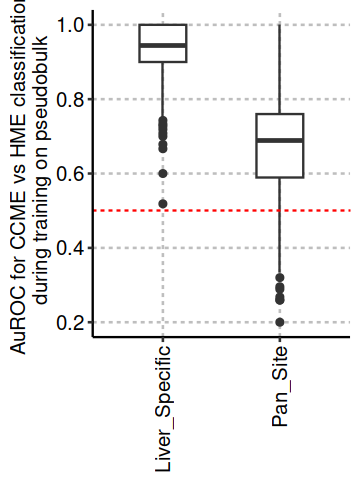

In [6]:
plot_df <- training_auc_df #%>% mutate(Wu_Fibroblast=paste(model_type, "\nWu Included? ",Include_Wu,"\nFibroblast Included? ",
                                                           # Include_Fibroblast)) # %>% dplyr::filter(Include_Wu == "No" &
options(repr.plot.width=3,repr.plot.height=4)
p <- ggplot(plot_df, aes(x=model_type,y=auc) ) + 
geom_boxplot(width=0.4) +
geom_hline(aes(yintercept=0.5),color="red",linetype="dashed") + ylab("AuROC for CCME vs HME classification\n during training on pseudobulk") +
theme_pubr(base_size=12) + theme(axis.text.x=element_text(angle=90,hjust=1,vjust=0.5),
                                panel.grid.major=element_line(color="gray",linetype="dashed")) + xlab(NULL)

print(p)
# ggsave("plots/Training-CCMEvsHealthy-ROC-Boxplot.pdf",p,width=4,height=4)

options(repr.plot.width=7,repr.plot.height=7)


### HRs associated with CCME model evaluated on adjacent-normal samples

In the code block above, each TCGA patient is associated with a prediction score based on the CCME vs Healthy logistic regression model we just trained. Our hypothesis is that the score represents the "CCME-ness" of the adjacent-normal sample, with higher scores meaning that the sample is more deviated from a healthy microenvironment than a sample with a lower score. We now test whether the extent to which an adjacent-normal sample deviates from a healthy microenvironment is actually prognostic of overall survival.

Importantly, we test this hypothesis amongst early-stage (Stage I and Stage II) samples only because they are less likely to have received systemic therapy. We only run our model in those cancer types where there are at least 5 survival events i.e., deaths that have occurred in order for parameters of our Cox regression model to be estimated with sufficient statistical significance. 

In [9]:
cox_df <- data.frame()
tcga_cdr_df <- fread("../public_data/TCGA_CDR.csv")
tme_classification_dt <- fread("../public_data/Bagaev_Classifcation.csv")
tcga_purity_df <- fread("../public_data/pancan_tumor_purity.tsv") %>% mutate(submitter_id=gsub("-01$","",array))

model_type_ <- "Pan_Site"
early_stages <- c("Stage I","Stage IA","Stage IB","Stage II","Stage IIA","Stage IIB")
late_stages <- setdiff( na.omit( unique(tcga_cdr_df$ajcc_pathologic_tumor_stage) ), early_stages )

tcga_pred_score_clinical_df <- tcga_healthy_pred_score_df %>%
merge( ., tcga_healthy_ssgsea_df %>% dplyr::select(sample_column_name,
                                                   names(all_ccme_vs_healthy_signature_list[[model_type_]])), by="sample_column_name") %>%
mutate(sample_column_name=gsub("-11$","",sample_column_name)) %>%
merge( ., tcga_cdr_df, by.x="sample_column_name",by.y="bcr_patient_barcode" ) %>%
merge(., tme_classification_dt %>% dplyr::select(submitter_id,MFP),by.x="sample_column_name",by.y="submitter_id") %>%
merge(.,tcga_purity_df,by.x="sample_column_name",by.y="submitter_id") %>%
dplyr::filter( ajcc_pathologic_tumor_stage %in% early_stages)

num_event_threshold <- 5
scores_to_use <- c("pred_score","Myeloid","Endothelial","Lymphoid","Fibroblast")

cancer_types <- c("BRCA","KIRC","LIHC","LUAD","LUSC")
for (score_to_use in scores_to_use) {
    if (!score_to_use %in% colnames(tcga_pred_score_clinical_df))
        next
    
    for (cancer_type_ in cancer_types) {
        data_df <- tcga_pred_score_clinical_df %>% 
                            dplyr::filter(cancer_type == cancer_type_ & model_type == model_type_) %>%
                        dplyr::rename(age=age_at_initial_pathologic_diagnosis,sex=gender)
    
        num_events <- dplyr::filter(data_df,OS == 1) %>% nrow
    
        if (num_events < num_event_threshold)
            next
        
        if (nrow(data_df) < 30)
            next
        
        cox_obj <- coxph( as.formula( sprintf('Surv(OS.time,OS) ~ age + `%s`',score_to_use)), data=data_df)
        coef_df <- coef(summary(cox_obj)) %>% as.data.frame %>% tibble::rownames_to_column("coef_name")
        lr_p_value <- summary(cox_obj)$logtest["pvalue"]
        
        cox_df <- rbind(cox_df,
                        dplyr::filter(coef_df,coef_name == score_to_use) %>% mutate(cancer_type=cancer_type_) %>%
                       dplyr::rename(HR=`exp(coef)`) %>% mutate(logrank_p=lr_p_value,score_type=score_to_use) )
    }
}


# tcga_pred_score_clinical_df <- merge( tcga_healthy_pred_score_df, tcga_cdr_df,
#                                      by.x="patient_id",by.y="bcr_patient_barcode" ) 



#### Pan-cancer survival analysis

In [17]:
# Cox regression using CCME score
library(coxme)
tcga_pred_score_clinical_df_2<- tcga_pred_score_clinical_df %>% 
                            dplyr::filter(model_type == model_type_) %>%
                        dplyr::rename(age=age_at_initial_pathologic_diagnosis,sex=gender)

# cox_obj <- coxph( as.formula( sprintf('Surv(OS.time,OS) ~ age + cancer_type + `%s`',"pred_score")), data=tcga_pred_score_clinical_df_2)
# coef_df <- coef(summary(cox_obj)) %>% as.data.frame %>% tibble::rownames_to_column("coef_name")
# lr_p_value <- summary(cox_obj)$logtest["pvalue"]

extract_coxme_table <- function (mod){
    #From https://stackoverflow.com/questions/43720260/how-to-extract-p-values-from-lmekin-objects-in-coxme-package\n",
    beta <- mod$coefficients
    nvar <- length(beta)
    nfrail <- nrow(mod$var) - nvar
    se <- sqrt(diag(mod$var)[nfrail + 1:nvar])
    z<- round(beta/se, 2)
    p<- signif(1 - pchisq((beta/se)^2, 1), 2)
    table=data.frame(cbind(beta,se,z,p))
    return(table)
}

##Subsample cancer types to understand if HR variation is high across cancer types
cancer_types_present <- unique(tcga_pred_score_clinical_df_2$cancer_type)
num_types_to_subsample <- 10
subsampled_df <- tcga_pred_score_clinical_df_2 %>% dplyr::filter(cancer_type %in% sample(cancer_types_present,num_types_to_subsample))


cox_obj <- coxme( as.formula( sprintf('Surv(OS.time,OS) ~ age + (1|cancer_type) + `%s`',"pred_score")), data=tcga_pred_score_clinical_df_2)
p_value_info <- extract_coxme_table(cox_obj)
p_values <- p_value_info[,"p"]
names(p_values) <- rownames(p_value_info)
hr_values <- exp(cox_obj$coefficients)

print(hr_values)
print(p_values)

       age pred_score 
  1.036231   1.240271 
       age pred_score 
   1.0e-07    4.4e-03 


In [86]:
# Cox regression using scaled pred_score
library(coxme)

tcga_pred_score_clinical_df_2<- tcga_pred_score_clinical_df %>% 
                            dplyr::filter(model_type == model_type_) %>%
                        dplyr::rename(age=age_at_initial_pathologic_diagnosis,sex=gender) 

tcga_pred_score_clinical_df_2$z_score_scale <- scale(tcga_pred_score_clinical_df_2$pred_score)[,1]

# cox_obj <- coxph( as.formula( sprintf('Surv(OS.time,OS) ~ age + cancer_type + `%s`',"pred_score")), data=tcga_pred_score_clinical_df_2)
# coef_df <- coef(summary(cox_obj)) %>% as.data.frame %>% tibble::rownames_to_column("coef_name")
# lr_p_value <- summary(cox_obj)$logtest["pvalue"]

extract_coxme_table <- function (mod){
    #From https://stackoverflow.com/questions/43720260/how-to-extract-p-values-from-lmekin-objects-in-coxme-package\n",
    beta <- mod$coefficients
    nvar <- length(beta)
    nfrail <- nrow(mod$var) - nvar
    se <- sqrt(diag(mod$var)[nfrail + 1:nvar])
    z<- round(beta/se, 2)
    p<- signif(1 - pchisq((beta/se)^2, 1), 2)
    table=data.frame(cbind(beta,se,z,p))
    return(table)
}

##Subsample cancer types to understand if HR variation is high across cancer types
cancer_types_present <- unique(tcga_pred_score_clinical_df_2$cancer_type)
num_types_to_subsample <- 10
subsampled_df <- tcga_pred_score_clinical_df_2 %>% dplyr::filter(cancer_type %in% sample(cancer_types_present,num_types_to_subsample))


cox_obj <- coxme( as.formula( sprintf('Surv(OS.time,OS) ~ age + (1|cancer_type) + `%s`',"z_score_scale")), data=tcga_pred_score_clinical_df_2)
p_value_info <- extract_coxme_table(cox_obj)
p_values <- p_value_info[,"p"]
names(p_values) <- rownames(p_value_info)
hr_values <- exp(cox_obj$coefficients)

print(hr_values)
print(p_values)

          age z_score_scale 
     1.036231      1.846191 
          age z_score_scale 
      1.0e-07       4.4e-03 


In [11]:
median_score <- median(tcga_pred_score_clinical_df$pred_score)
quartiles <- quantile(tcga_pred_score_clinical_df$pred_score, probs = c(0.25, 0.5, 0.75))

tcga_pred_score_clinical_df$score_group_median <- ifelse(tcga_pred_score_clinical_df$pred_score >= median_score, "high", "low")

tcga_pred_score_clinical_df$score_group_quartile <- cut(tcga_pred_score_clinical_df$pred_score, 
                               breaks = c(-Inf, quartiles[1], quartiles[2], quartiles[3], Inf), 
                               labels = c("Q1", "Q2", "Q3", "Q4"))

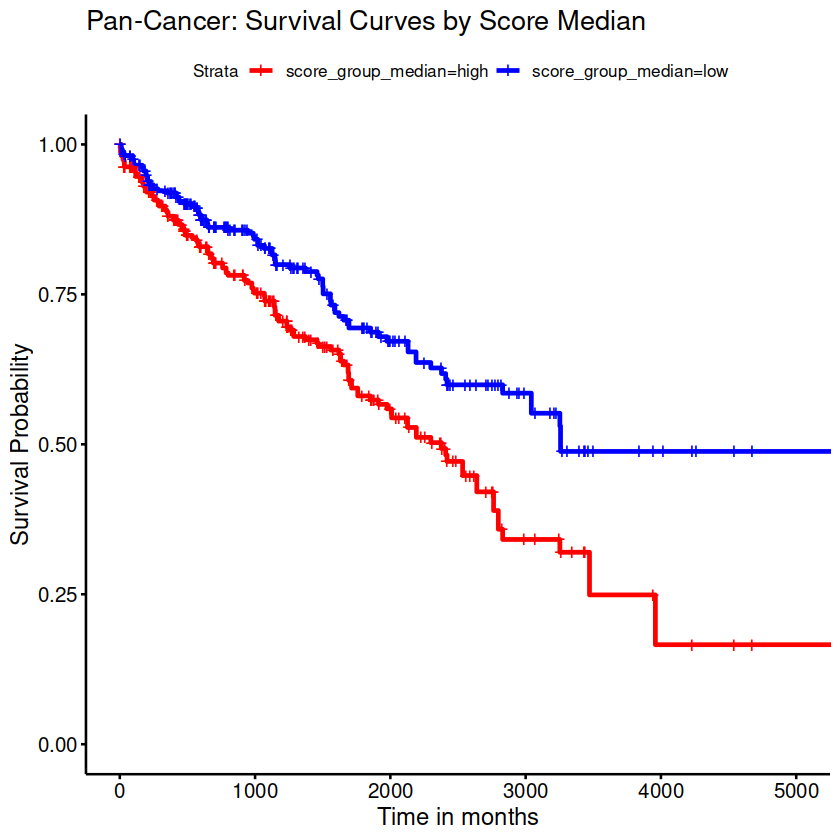

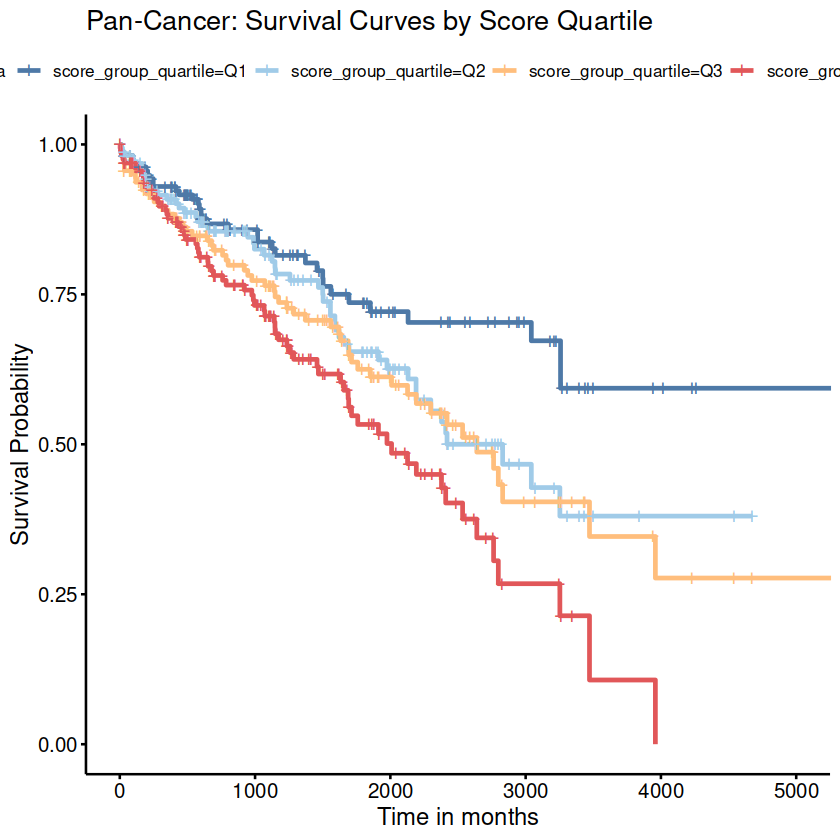

In [23]:
median_fit <- survfit(Surv(OS.time,OS) ~ score_group_median, data = tcga_pred_score_clinical_df) 

p_m <- ggsurvplot(median_fit, 
           data = tcga_pred_score_clinical_df,
           pval = FALSE,  
           conf.int = FALSE, 
           risk.table = FALSE, 
           xlab = "Time in months",
           ylab = "Survival Probability",
           palette = c('red', 'blue'),
           title = "Pan-Cancer: Survival Curves by Score Median")

quart_fit <- survfit(Surv(OS.time,OS) ~ score_group_quartile, data = tcga_pred_score_clinical_df) 

p_q <- ggsurvplot(quart_fit, 
           data = tcga_pred_score_clinical_df,
           pval = FALSE,  
           conf.int = FALSE, 
           risk.table = FALSE, 
           xlab = "Time in months",
           ylab = "Survival Probability",
           palette = c('#4E79A7', '#A0CBE8', '#FFBE7D', '#E15759'), # c('#4E79A7', '#A0CBE8', '#FF9D9A', '#E15759'), #c('blue', 'green', 'orange', 'red'),
           title = "Pan-Cancer: Survival Curves by Score Quartile")

p_m

p_q

In [27]:
#pdf('../Etan/Output/CCME_model_PanCancer_Survival_Quartile.pdf', width = 7, height = 7)
#p_q
#dev.off()

pdf 
  2

#### log(HR) for each evaluable cancer type

In [10]:
tcga_pred_score_clinical_df$z_score_scale <- scale(tcga_pred_score_clinical_df$pred_score)[,1]


In [17]:
cox_df <- data.frame()
tcga_cdr_df <- fread("../public_data/TCGA_CDR.csv")
tme_classification_dt <- fread("../public_data/Bagaev_Classifcation.csv")
tcga_purity_df <- fread("../public_data/pancan_tumor_purity.tsv") %>% mutate(submitter_id=gsub("-01$","",array))
scores_to_use <- c('z_score_scale')

model_type_ <- "Pan_Site"
early_stages <- c("Stage I","Stage IA","Stage IB","Stage II","Stage IIA","Stage IIB")
late_stages <- setdiff( na.omit( unique(tcga_cdr_df$ajcc_pathologic_tumor_stage) ), early_stages )

tcga_pred_score_clinical_df <- tcga_healthy_pred_score_df %>%
merge( ., tcga_healthy_ssgsea_df %>% dplyr::select(sample_column_name,
                                                   names(all_ccme_vs_healthy_signature_list[[model_type_]])), by="sample_column_name") %>%
mutate(sample_column_name=gsub("-11$","",sample_column_name)) %>%
merge( ., tcga_cdr_df, by.x="sample_column_name",by.y="bcr_patient_barcode" ) %>%
merge(., tme_classification_dt %>% dplyr::select(submitter_id,MFP),by.x="sample_column_name",by.y="submitter_id") %>%
merge(.,tcga_purity_df,by.x="sample_column_name",by.y="submitter_id") %>%
dplyr::filter( ajcc_pathologic_tumor_stage %in% early_stages)

# change to Z score scale
tcga_pred_score_clinical_df$z_score_scale <- scale(tcga_pred_score_clinical_df$pred_score)[,1]

num_event_threshold <- 5
scores_to_use <- c("z_score_scale","Myeloid","Endothelial","Lymphoid","Fibroblast")

cancer_types <- c("BRCA","KIRC","LIHC","LUAD","LUSC")
for (score_to_use in scores_to_use) {
    if (!score_to_use %in% colnames(tcga_pred_score_clinical_df))
        next
    
    for (cancer_type_ in cancer_types) {
        data_df <- tcga_pred_score_clinical_df %>% 
                            dplyr::filter(cancer_type == cancer_type_ & model_type == model_type_) %>%
                        dplyr::rename(age=age_at_initial_pathologic_diagnosis,sex=gender)
    
        num_events <- dplyr::filter(data_df,OS == 1) %>% nrow
    
        if (num_events < num_event_threshold)
            next
        
        if (nrow(data_df) < 30)
            next
        
        cox_obj <- coxph( as.formula( sprintf('Surv(OS.time,OS) ~ age + `%s`',score_to_use)), data=data_df)
        coef_df <- coef(summary(cox_obj)) %>% as.data.frame %>% tibble::rownames_to_column("coef_name")
        lr_p_value <- summary(cox_obj)$logtest["pvalue"]
        
        cox_df <- rbind(cox_df,
                        dplyr::filter(coef_df,coef_name == score_to_use) %>% mutate(cancer_type=cancer_type_) %>%
                       dplyr::rename(HR=`exp(coef)`) %>% mutate(logrank_p=lr_p_value,score_type=score_to_use) )
    }
}


# tcga_pred_score_clinical_df <- merge( tcga_healthy_pred_score_df, tcga_cdr_df,
#                                      by.x="patient_id",by.y="bcr_patient_barcode" ) 



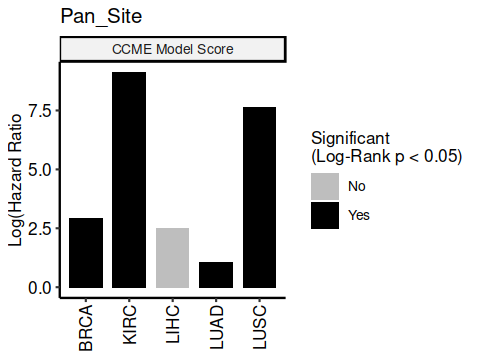

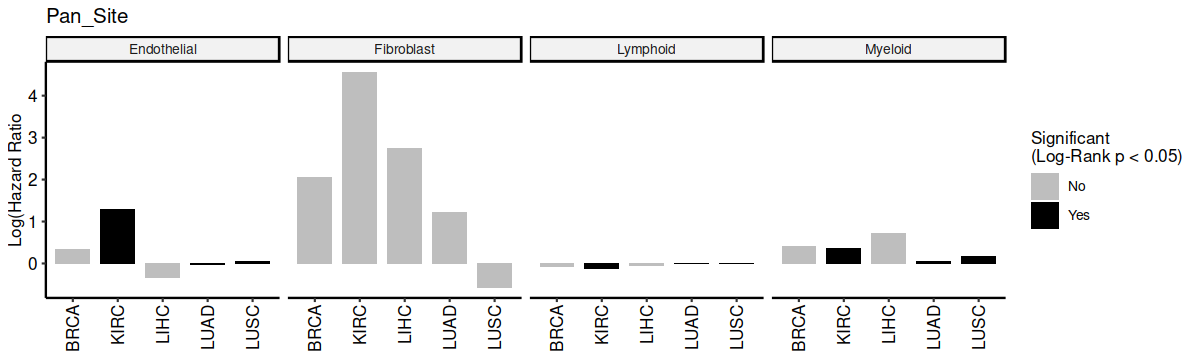

In [18]:
options(repr.plot.height=3,repr.plot.width=4)
plot_df <- mutate(cox_df,signif=ifelse(logrank_p < 0.05,"Yes","No")) %>%
mutate(score_type=ifelse(score_type == "z_score_scale","CCME Model Score",score_type)) %>%
dplyr::filter(score_type == "CCME Model Score")

p1 <- ggplot( plot_df ) + geom_bar(aes(x=cancer_type,y=coef,fill=signif),stat="identity",width=0.75) +
theme_pubr(base_size=10) + scale_fill_manual(values=c("Yes"="black","No"="gray")) +
labs(fill="Significant\n(Log-Rank p < 0.05)") + ylab("Log(Hazard Ratio") +
facet_wrap(~score_type,nrow=1) + theme(axis.text.x=element_text(angle=90,hjust=1,vjust=0.5),
                                      legend.position="right") +
xlab(NULL) + ggtitle(model_type_)
print(p1)

#ggsave("plots/TCGA-Early-Samples-Pan_Site-ModelScore-OS-HR.pdf",p1,width=4,height=3)

options(repr.plot.height=3,repr.plot.width=10)
plot_df <- mutate(cox_df,signif=ifelse(logrank_p < 0.05,"Yes","No")) %>%
mutate(score_type=ifelse(score_type == "z_score_scale","CCME Model Score",score_type)) %>%
dplyr::filter(score_type != "CCME Model Score")

p2 <- ggplot( plot_df ) + geom_bar(aes(x=cancer_type,y=coef,fill=signif),stat="identity",width=0.75) +
theme_pubr(base_size=10) + scale_fill_manual(values=c("Yes"="black","No"="gray")) +
labs(fill="Significant\n(Log-Rank p < 0.05)") + ylab("Log(Hazard Ratio") +
facet_wrap(~score_type,nrow=1) + theme(axis.text.x=element_text(angle=90,hjust=1,vjust=0.5),
                                      legend.position="right") +
xlab(NULL) + ggtitle(model_type_)
print(p2)
#ggsave("plots/TCGA-Early-Samples-Pan_Site-Compartments-OS-HR.pdf",p2,width=8,height=3)



options(repr.plot.height=7,repr.plot.width=7)

# Bojmar et. al

https://pubmed.ncbi.nlm.nih.gov/38942992/

In [38]:
ccme_vs_healthy_model_list <- readRDS("../processed_data/CCME_vs_Healthy_Model_Parameters.rds")
bojmar_dt <- fread("../public_data/GSE245535_counts_scaled_DESeq_GEO.txt.gz",skip=1)
gene_name_dt <- fread("../public_data/GRCh38_p14.gene_names.tsv.gz")

bojmar_dt <- bojmar_dt %>% mutate(GeneID=gsub("\\.[0-9][0-9]*","",GeneID))

sig_type <- "Pan_Site"
ensg_ccme_vs_healthy_signature_list <- list()
for (signature in names(all_ccme_vs_healthy_signature_list[[sig_type]])) {
    ensg_ccme_vs_healthy_signature_list[[signature]] <- dplyr::filter(gene_name_dt,`Gene name` %in% 
                                                                      all_ccme_vs_healthy_signature_list[[sig_type]][[signature]]) %>%
    pull(`Gene stable ID`)
}

expr_mat <- tibble::column_to_rownames(bojmar_dt,"GeneID") %>% as.matrix

patient_id <- c(3,6,9,11,34,43,53,58,67,78,1,13,16,23,27,32,49,57,
64,71,76,77,85,2,10,37,46,47,48,75,84,91,
7,14,15,24,30,41,44,50,65)
event_type <- c("Early","Early","Early","Early","Early","Early","Early","Early","Early","Early",
"Late","Late","Late","Late","Late","Late","Late","Late","Late","Late","Late","Late","Late",
"EHM","EHM","EHM","EHM","EHM","EHM","EHM","EHM","EHM","NED","NED","NED","NED","NED","NED","NED","NED","NED")
liver_met_event <- c("Y","Y","Y","Y","Y","Y","Y","Y","Y","Y","Y","Y","Y","Y","Y",
                     "Y","Y","Y","Y","Y","Y","Y","Y","N","N","N","N","N","N","N","N","N","N","N","N","N","N","N","N","N","N")
time_to_liver_event <- c(4.5,4.1,1.3,1.8,4.5,1.6,3.2,1.2,5.9,1.8,8.3,
7.3,8.4,32.3,9.6,10.1,9.8,10.4,11.3,17.2,7.2,19.6,
6.0,35.6,22.1,15.7,4.3,25.5,26.1,36.0,34.4,15.9,36.0,36.0,34.7,
35.3,35.2,36.0,36.0,36.0,20.6)
time_to_first_met <- c(4.5,4.1,1.3,1.8,4.5,1.6,3.2,1.2,5.9,1.8,8.3,7.3,8.4,32.3,4.2,8.7,9.8,10.4,
11.3,17.2,7.2,19.6,6.0,13.8,22.0,1.9,4.3,11.4,14.2,17.9,34.4,7.5,NA,NA,NA,NA,NA,NA,NA,NA,NA)

patient_info_df <- data.frame(patient_id=patient_id,event_type,liver_met_event=liver_met_event,
                              time_to_liver_event=time_to_liver_event,time_to_first_met=time_to_first_met) %>%
mutate(liver_met_event=ifelse(liver_met_event == "Y",1,0))

pdac_samples <- grep("NON",colnames(expr_mat),value=T,invert=T)

bojmar_ssgsea_score_mat <- GSVA::gsva( expr_mat[,pdac_samples], ensg_ccme_vs_healthy_signature_list, method="ssgsea" )

bojmar_ssgsea_score_df <- t(bojmar_ssgsea_score_mat) %>% as.data.frame %>% tibble::rownames_to_column("sample_id") %>%
mutate(sample_code=ifelse(grepl("__PDAC",sample_id),1,0),sample_type=ifelse(grepl("__PDAC",sample_id),"PMN","Non_PMN"))


time_to_first_event <- sapply(1:length(time_to_liver_event), function(idx) return( min(time_to_first_met[idx],time_to_liver_event[idx],na.rm=T) ))
patient_info_df$time_to_first_event <- time_to_first_event

bojmar_ssgsea_score_df <- mutate(bojmar_ssgsea_score_df,patient_id=as.character(str_match(sample_id,pattern="[0-9][0-9]*")))

bojmar_ssgsea_score_df <- merge(bojmar_ssgsea_score_df,patient_info_df,by="patient_id",all.x=T)

bojmar_ssgsea_score_df$pred_score <- predict(ccme_vs_healthy_model_list[[sig_type]],newdata=bojmar_ssgsea_score_df)

bojmar_ssgsea_score_df <- mutate(bojmar_ssgsea_score_df,any_met_event=ifelse(event_type %in% c("Late","EHM","Early"),1,0))

Warning message in .filterFeatures(expr, method):
“2 genes with constant expression values throuhgout the samples.”


Estimating ssGSEA scores for 4 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."


Warning message in wilcox.test.default(c(3.31173365902657, 3.31173365902657, 3.31173365902657, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(3.31173365902657, 3.31173365902657, 3.31173365902657, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(3.27768127675518, 3.27768127675518, 3.27768127675518, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(3.27750656816071, 3.27750656816071, 3.27750656816071, :
“cannot compute exact p-value with ties”


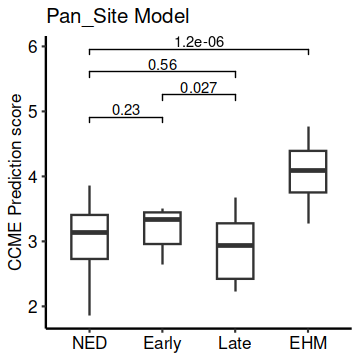

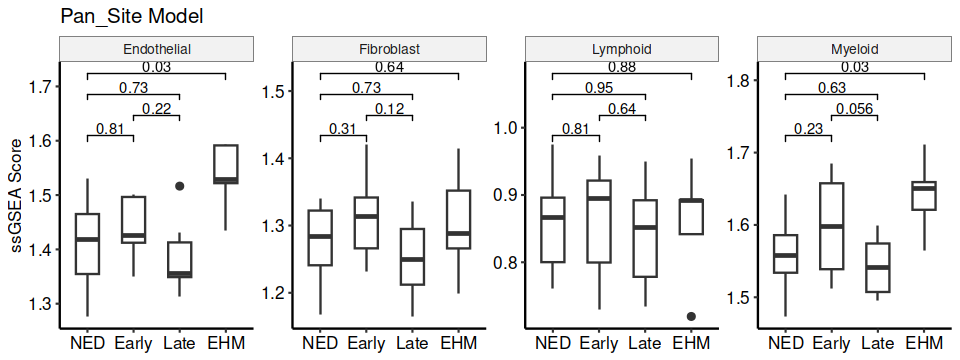

In [39]:
plot_df <- tidyr::pivot_longer( bojmar_ssgsea_score_df, cols=names( all_ccme_vs_healthy_signature_list[[sig_type]]),
                               names_to="compartment", values_to="ssGSEA Score") %>%
mutate(event_type=factor(event_type,levels=c(NA,"NED","Early","Late","EHM"))) %>%
dplyr::filter(!is.na(event_type))
options(repr.plot.width=3,repr.plot.height=3)
p1 <- ggplot( plot_df, aes(x=event_type,y=pred_score) ) + geom_boxplot(width=0.5) + 
theme_pubr(base_size=10) + ggtitle(sprintf('%s Model',sig_type)) + ylab("CCME Prediction score") +
# facet_wrap(~compartment,scales="free",nrow=1,strip.position="top") +
# theme(strip.clip = "on",strip.background = element_rect(linewidth=0.1)) +
stat_compare_means(comparisons=list(c("Early","NED"),c("Early","Late"),c("Late","NED"),c("EHM","NED")),vjust=0.1,size=3 ) +
xlab(NULL)
print(p1)
# ggsave(sprintf("plots/Bojmar-%s-TruncatedModelScore-Boxplots.pdf",sig_type),p1,width=3,height=3)

options(repr.plot.width=8,repr.plot.height=3)
p2 <- ggplot( plot_df, aes(x=event_type,y=`ssGSEA Score`) ) + geom_boxplot(width=0.5) + 
theme_pubr(base_size=10) + ggtitle(sprintf('%s Model',sig_type)) +
facet_wrap(~compartment,scales="free",nrow=1,strip.position="top") +
theme(strip.clip = "on",strip.background = element_rect(linewidth=0.1)) +
stat_compare_means(comparisons=list(c("Early","NED"),c("Early","Late"),c("Late","NED"),c("EHM","NED")),vjust=0.1,size=3 ) +
xlab(NULL)
print(p2)
# ggsave(sprintf("plots/Bojmar-%s-CompartmentScore-Boxplots.pdf",sig_type),p2,width=8,height=3)

options(repr.plot.width=7,repr.plot.height=7)

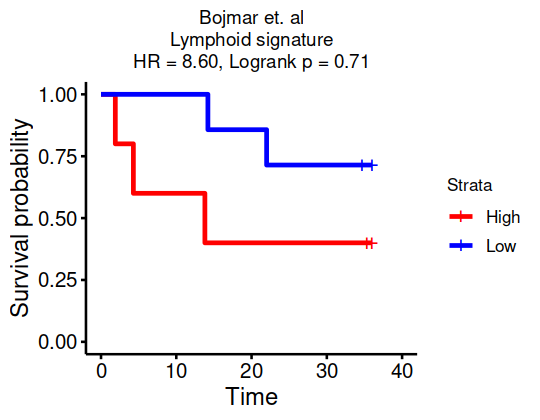

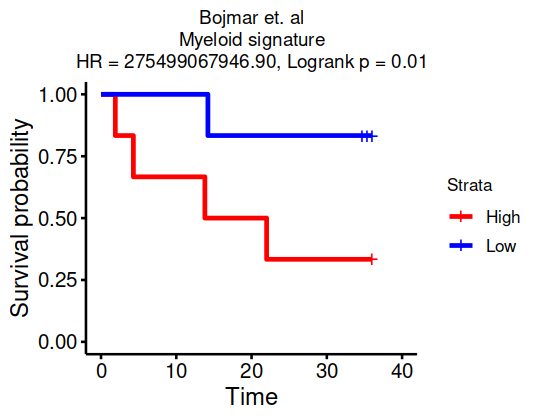

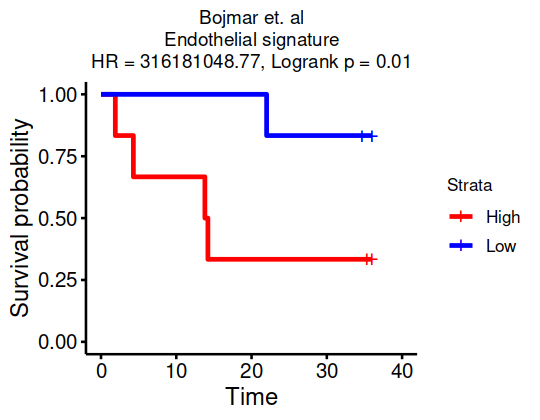

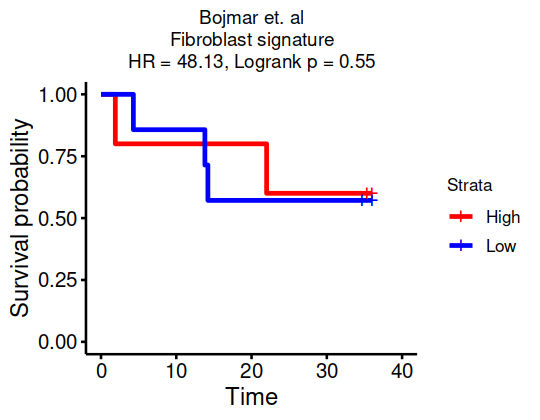

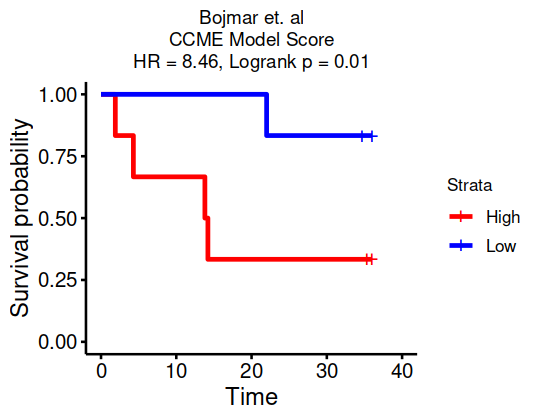

In [40]:
options(repr.plot.height=3.5,repr.plot.width=4.5)

for (compartment in c("Lymphoid","Myeloid","Endothelial","Fibroblast","pred_score")) {

    if (!compartment %in% colnames(bojmar_ssgsea_score_df))
        next

    data_df <- bojmar_ssgsea_score_df
    data_df$Status <- ifelse( bojmar_ssgsea_score_df[[compartment]] > quantile(bojmar_ssgsea_score_df[[compartment]],0.5),"High","Low")
     data_df <- data_df %>% dplyr::filter(event_type %in% c("EHM","NED") )
 
    p <- ggsurvplot( survfit( Surv(time_to_first_event,any_met_event) ~ Status, data=data_df ))
    
    cox_obj <- coxph( as.formula( sprintf("Surv(time_to_first_event,any_met_event) ~ `%s`", compartment)), data=data_df )
    coef_table <- coef( summary(cox_obj) )
    hr <- coef_table[,"exp(coef)"]
    p_val <- summary(cox_obj)$logtest["pvalue"]

    if (compartment == "pred_score") {
        title_text <- sprintf("Bojmar et. al\nCCME Model Score\nHR = %.2f, Logrank p = %.2f",
                                                                   hr,p_val)
    } else {
        title_text <- sprintf("Bojmar et. al\n%s signature\nHR = %.2f, Logrank p = %.2f",
                                                                   compartment, hr,p_val)
    }
    
    final_plot <- p$plot + theme(legend.position="right") + ggtitle(title_text) +
         theme(plot.title=element_text(size=11,hjust=0.5)) +
           scale_color_manual(labels = c("Status=High"="High", "Status=Low"="Low"),values=c("red","blue"))
    print(final_plot)

    # ggsave(sprintf("plots/Bojmar-EHM-Only-%s-%s-KM-MedianStratification-Curves.pdf",sig_type,compartment),final_plot,width=4.5,height=3.5)
}
options(repr.plot.height=7,repr.plot.width=7)

# Dolgalev et. al, 2023

https://www.nature.com/articles/s41467-023-42327-x

## Bulk RNA-seq analysis

In [20]:
ccme_vs_healthy_model_list <- readRDS("../processed_data/CCME_vs_Healthy_Model_Parameters.rds")

dolgalev_count_dt <- fread("../public_data/GSE229705_counts-raw.csv.gz")
clinical_info_dt <- readxl::read_xlsx("../public_data/Dolgalev_2023_Source_Data.xlsx",sheet="Figure 1e") %>%
dplyr::rename(patient=subjs) %>% mutate(patient=as.character(patient))

dolgalev_module_dt <- readxl::read_xlsx("../public_data/Dolgalev_2023_Source_Data.xlsx",sheet="Figure 3ab")

module_20_genes <- dplyr::filter(dolgalev_module_dt,module == 20) %>% pull(gene)

dolgalev_adj_norm_count_mat <- dplyr::select(dolgalev_count_dt,gene,ends_with("-N")) %>%
tibble::column_to_rownames("gene") %>% as.matrix
sample_info_df <- data.frame(sample_id=colnames(dolgalev_adj_norm_count_mat)) %>%
mutate(patient=as.character(unlist(str_match(sample_id,"[0-9][0-9]*"))))

dolgalev_obj <- DGEList( counts=dolgalev_adj_norm_count_mat )
dolgalev_adj_norm_log_cpm_mat <- cpm(dolgalev_obj,log=T)

sig_type <- "Pan_Site"

dolgalev_ssgsea_score_mat <- GSVA::gsva( dolgalev_adj_norm_log_cpm_mat, all_ccme_vs_healthy_signature_list[[sig_type]], method="ssgsea" )

dolgalev_ssgsea_score_df <- t(dolgalev_ssgsea_score_mat) %>% as.data.frame %>% tibble::rownames_to_column("sample_id") %>%
merge(.,sample_info_df,by="sample_id") %>%
merge(.,clinical_info_dt,by="patient")
dolgalev_ssgsea_score_df$pred_score <- predict(ccme_vs_healthy_model_list[[sig_type]],newdata=dolgalev_ssgsea_score_df)

#Censoring samples at ten years followup.
dolgalev_ssgsea_score_df <- dplyr::filter(dolgalev_ssgsea_score_df, time <= 3653 ) %>%
mutate(time_in_years=time/365.25)

Warning message in .filterFeatures(expr, method):
“4721 genes with constant expression values throuhgout the samples.”


Estimating ssGSEA scores for 4 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."


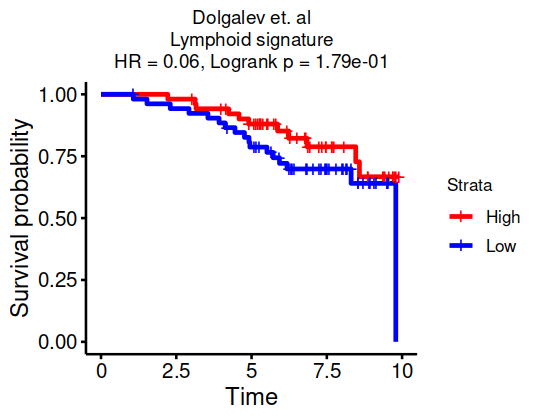

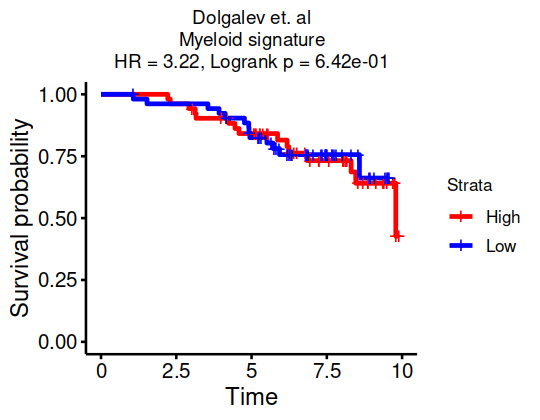

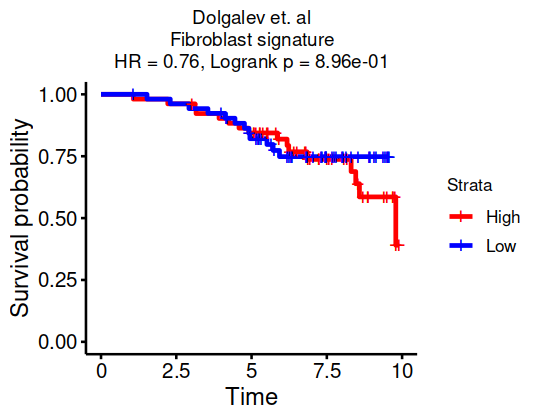

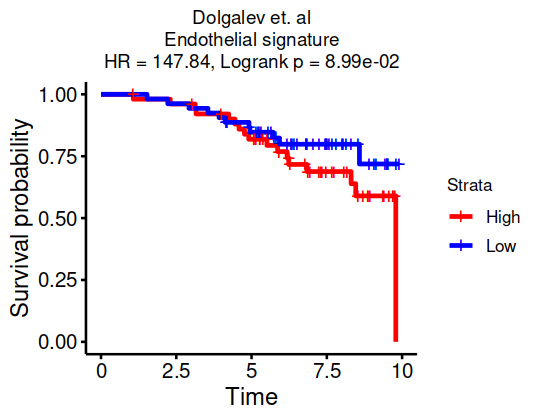

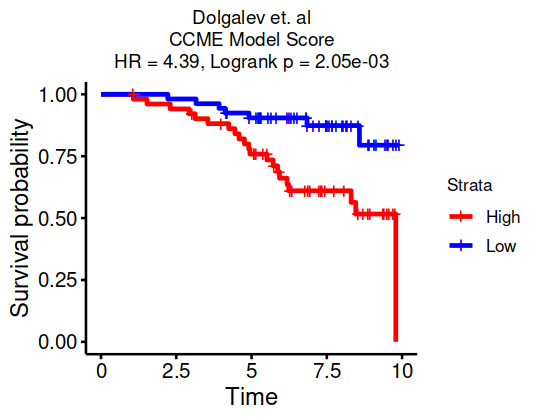

In [24]:
options(repr.plot.height=3.5,repr.plot.width=4.5)

for (compartment in c("Lymphoid","Myeloid","Fibroblast","Endothelial","pred_score")) {

    if (!compartment %in% colnames(dolgalev_ssgsea_score_df))
        next
    

    data_df <- dolgalev_ssgsea_score_df
    data_df$Status <- ifelse( dolgalev_ssgsea_score_df[[compartment]] > quantile(dolgalev_ssgsea_score_df[[compartment]],0.5),"High","Low")
 
    p <- ggsurvplot( survfit( Surv(time_in_years,status) ~ Status, data=data_df ))
    
    cox_obj <- coxph( as.formula( sprintf("Surv(time_in_years,status) ~ `%s`", compartment)), data=dolgalev_ssgsea_score_df )
    coef_table <- coef( summary(cox_obj) )
    hr <- coef_table[,"exp(coef)"]
    p_val <- summary(cox_obj)$logtest["pvalue"]

    if (compartment == "pred_score") {
        title_text <- sprintf("Dolgalev et. al\nCCME Model Score\nHR = %.2f, Logrank p = %.2e",
                                                                   hr,p_val)
    } else {
        title_text <- sprintf("Dolgalev et. al\n%s signature\nHR = %.2f, Logrank p = %.2e",
                                                                   compartment, hr,p_val)
    }
    
    final_plot <- p$plot + theme(legend.position="right") + ggtitle(title_text) +
         theme(plot.title=element_text(size=11,hjust=0.5)) +
           scale_color_manual(labels = c("Status=High"="High", "Status=Low"="Low"),values=c("red","blue"))
    print(final_plot)

    ggsave(sprintf("plots/Dolgalev-Censored10Y-%s-%s-KM-MedianStratification-Curves.pdf",sig_type,compartment),final_plot,width=4.5,height=3.5)

}
options(repr.plot.height=7,repr.plot.width=7)

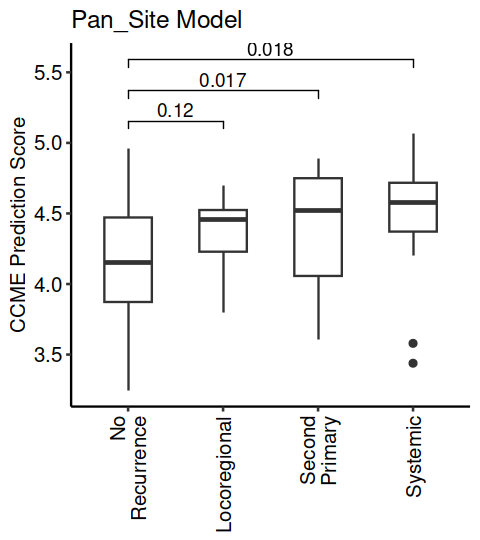

In [25]:
options(repr.plot.width=4,repr.plot.height=4.5)
p <- ggplot( dolgalev_ssgsea_score_df %>%
mutate(subtype=factor(subtype,levels=c("No Recurrence","Locoregional","Second Primary","Systemic"))), aes(x=subtype,y=pred_score) ) + geom_boxplot(width=0.5) + 
theme_pubr(base_size=12) + ggtitle(sprintf('%s Model',sig_type)) +
theme(axis.text.x=element_text(angle=90,hjust=1,vjust=0.5)) +
scale_x_discrete(labels = function(x) str_wrap(x, width = 10)) +
stat_compare_means(comparisons=list(c("No Recurrence","Locoregional"),c("No Recurrence","Second Primary"),c("No Recurrence","Systemic"))) +
                 ylab("CCME Prediction Score") + xlab(NULL)
print(p)
                 
ggsave(sprintf("plots/Dolgalev-Censored10Y-%s-ModelScore-Boxplots.pdf",sig_type),p,width=4,height=4.5)

options(repr.plot.width=7,repr.plot.height=7)